<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo Fin de Máster</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Autor: César Fernández Domínguez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Análisis descriptivo de datos de contaminación del aire para la ciudad de Barcelona

Este análisis se ha organizado en los siguientes apartados:

 <ol start="1">
  <li>Carga del conjunto de datos</li>
  <li>Análisis de los datos
  <br>2.1 Análisis estadístico básico
  <br>2.3 Transformación de los datos
  <br>2.4 Análisis exploratorio de los datos
  <li>Selección de estaciones
  <li>Imputación de datos
</ol>
   
En primer lugar, cargamos algunas librerías que vamos a necesitar, y definimos la carpeta raiz de donde cargaremos nuestros datos y, finalmente,  guardaremos los resultados:

In [1]:
# Mount folder in Google Drive (only for execution in Google Colab)
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os, sys
import numpy as np
import pandas as pd
import datetime as dt
import folium
import random
import seaborn;
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from matplotlib.pylab import rcParams
from statistics import mean
%matplotlib inline
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 10

rootDataFolder="../data/"
#rootDataFolder="/content/drive/My Drive/colab/data/"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Carga del conjunto de datos

El objetivo principal de este trabajo es el construir un modelo capaz de predecir la concentración de contaminantes en el aire en la ciudad de Barcelona. Para realizar este modelo, en primer lugar, debemos de contar con registros de datos de inmisión. La comunidad autónoma de Cataluña ofrece estos datos, en abierto, a través de su portal de [Open Data](https://analisi.transparenciacatalunya.cat/es). Concretamente en el enlace enlace: [aqui](https://analisi.transparenciacatalunya.cat/es/Medi-Ambient/Dades-d-immissi-dels-punts-de-mesurament-de-la-Xar/uy6k-2s8r), encontramos datos de inmisión de los puntos de medición de la Red de Vigilancia y Previsión de la Contaminación Atmosférica de Cataluña. Estos datos se ofrecen con distinta periodicidad horaria para distintos contaminantes del aire. Se tienen datos desde el año 1991 hasta el día anterior a la actual. En nuestro caso, nos interesan los datos registrados desde enero de 2010, en las estaciones de vigilancia ubicadas en la ciudad de Barcelona. Esta información se actualiza diariamente. Aparte de la concentración de los diferentes contaminantes también se podrá consultar: las coordenadas donde está ubicado el punto de medición, el tipo de estación, las unidades y la fecha de alta y de baja.

Estos datos se ofrecen con Licencia: [Open Data Commons Attribution License](https://opendatacommons.org/licenses/by/1.0/)

El siguiente código nos permite cargar los datos de inmisión, disponibles entre dos meses, en la ciudad de Barcelona (los datos predescargados están filtrados para Barcelona). Para ello, debemos modificar los valores asignados a las variables 'dataStartTime' y 'dataEndTime'.

In [3]:
dataStartTime = "2010-01"
dataEndTime = "2020-04"

# Header definition
columns=['CODI_MESURAMENT','CODI_EOI','PROVINCIA','CODI_MUNICIPI','CODI_ESTACIO','NOM_ESTACIO','MUNICIPI',
         'LATITUD','LONGITUD','ALTITUD','TIPUS_ESTACIO','AREA URBANA','MAGNITUD','CONTAMINANT','UNITATS',
         'PUNT_MOSTREIG','ANY','MES','DIA','DATA','H01','V01','H02','V02','H03','V03','H04','V04','H05','V05',
         'H06','V06','H07','V07','H08','V08','H09','V09','H10','V10','H11','V11','H12','V12','H13','V13',
         'H14','V14','H15','V15','H16','V16','H17','V17','H18','V18','H19','V19','H20','V20','H21','V21',
         'H22','V22','H23','V23','H24','V24','Georeferencia']
dtype={'CODI_MESURAMENT':object,
       'CODI_EOI':object,'PROVINCIA':object,'CODI_MUNICIPI':object,
       'CODI_ESTACIO':object,'NOM_ESTACIO':object,'MUNICIPI':object,
       'LATITUD':np.number,'LONGITUD':np.number,'ALTITUD':np.number,
       'TIPUS_ESTACIO':object,'AREA URBANA':object,'MAGNITUD':object,
       'CONTAMINANT':object,'UNITATS':object,'PUNT_MOSTREIG':object,
       'ANY':object,'MES':object,'DIA':object,'DATA':object,
       'H01':np.number,'V01':np.character,'H02':np.number,'V02':np.character,'H03':np.number,'V03':np.character,
       'H04':np.number,'V04':np.character,'H05':np.number,'V05':np.character,'H06':np.number,'V06':np.character,
       'H07':np.number,'V07':np.character,'H08':np.number,'V08':np.character,'H09':np.number,'V09':np.character,
       'H10':np.number,'V10':np.character,'H11':np.number,'V11':np.character,'H12':np.number,'V12':np.character,
       'H13':np.number,'V13':np.character,'H14':np.number,'V14':np.character,'H15':np.number,'V15':np.character,
       'H16':np.number,'V16':np.character,'H17':np.number,'V17':np.character,'H18':np.number,'V18':np.character,
       'H19':np.number,'V19':np.character,'H20':np.number,'V20':np.character,'H21':np.number,'V21':np.character,
       'H22':np.number,'V22':np.character,'H23':np.number,'V23':np.character,'H24':np.number,'V24':np.character,
       'Georeferencia':object}

# Read data to dataframe
data_air = pd.DataFrame(columns=columns)
for time in pd.date_range(dataStartTime+"-01T00:00:00.000", dataEndTime+"-01T00:00:00.000", freq='MS'):
    filename = time.strftime("aire/aire_%Y_%m.zip")
    sys.stdout.write(200*' '+'\r')
    sys.stdout.write('Reading file: \x1b[31m{}\x1b[0m \r'.format(filename))
    sys.stdout.flush()
    data_air = data_air.append(
        pd.read_csv(os.path.join(rootDataFolder, filename), names=columns, sep=';', encoding = "UTF-8", dtype=dtype)
        , ignore_index = True)

In [4]:
data_air.shape

(172917, 69)

Comprobamos que no se ha cargado ninguna instancia repetida. Si así fuera, tendríamos que eliminar aquellas que se repitan.

In [5]:
# Check whether duplicated rows and remove them, if so
duplicateRowsDF = data_air[data_air.duplicated()]
if len(duplicateRowsDF):
    data_air.drop_duplicates(inplace=True)  
    
print("Número de instancias duplicadas eliminadas: %d" % (len(duplicateRowsDF))) 

Número de instancias duplicadas eliminadas: 0


Mostramos las primeras instancias de nuestro dataframe para ver cómo son nuestros datos:

In [6]:
# Show first values in dataframe
data_air.head()

CODI_MESURAMENT CODI_EOI PROVINCIA CODI_MUNICIPI CODI_ESTACIO  \
0  8019056_10_20100101  8019056         8            19           56   
1  8019044_14_20100101  8019044         8            19           44   
2   8019004_8_20100101  8019004         8            19            4   
3   8019043_6_20100101  8019043         8            19           43   
4   8019042_6_20100101  8019042         8            19           42   

                         NOM_ESTACIO   MUNICIPI    LATITUD  LONGITUD  ALTITUD  \
0       Barcelona (Parc Vall Hebron)  Barcelona  41.426109  2.148002    136.0   
1  Barcelona (Gracia - Sant Gervasi)  Barcelona  41.398722  2.153399     57.0   
2               Barcelona (Poblenou)  Barcelona  41.403878  2.204501      3.0   
3               Barcelona (Eixample)  Barcelona  41.385314  2.153800     26.0   
4                  Barcelona (Sants)  Barcelona  41.378783  2.133099     35.0   

  TIPUS_ESTACIO AREA URBANA MAGNITUD CONTAMINANT UNITATS PUNT_MOSTREIG   ANY  \
0    background         NaN       10        PM10   µg/m3           NaN  2010   
1       traffic         NaN       14          O3   µg/m3           NaN  2010   
2    background         NaN        8         NO2   µg/m3           NaN  2010   
3       traffic         NaN        6          CO   mg/m3           NaN  2010   
4       traffic         NaN        6          CO   mg/m3           NaN  2010   

  MES DIA                     DATA   H01 V01   H02 V02   H03 V03   H04 V04  \
0   1   1  2010-01-01T00:00:00.000   NaN   N   NaN   N   NaN   N   NaN   N   
1   1   1  2010-01-01T00:00:00.000  64.0   V  58.0   V  64.0   V  70.0   V   
2   1   1  2010-01-01T00:00:00.000  12.0   V  17.0   V  13.0   V   6.0   V   
3   1   1  2010-01-01T00:00:00.000   NaN   N   NaN   N   NaN   N   NaN   N   
4   1   1  2010-01-01T00:00:00.000   0.2   V   0.2   V   0.2   V   0.2   V   

    H05 V05   H06 V06   H07 V07   H08 V08   H09 V09   H10 V10   H11 V11   H12  \
0   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   
1  74.0   V  77.0   V  78.0   V  79.0   V  78.0   V  76.0   V  75.0   V  75.0   
2   5.0   V   6.0   V   8.0   V   5.0   V   5.0   V   5.0   V   5.0   V   6.0   
3   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   
4   0.2   V   0.2   V   0.2   V   0.2   V   0.2   V   0.2   V   0.2   V   0.2   

  V12   H13 V13   H14 V14   H15 V15   H16 V16   H17 V17   H18 V18   H19 V19  \
0   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   
1   V  73.0   V  70.0   V  69.0   V  69.0   V  68.0   V  63.0   V  57.0   V   
2   V   9.0   V  13.0   V  12.0   V   8.0   V  10.0   V  12.0   V  16.0   V   
3   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   
4   V   0.2   V   0.2   V   0.2   V   0.2   V   0.2   V   0.2   V   0.2   V   

    H20 V20   H21 V21   H22 V22   H23 V23   H24 V24  \
0   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   
1  54.0   V  54.0   V  54.0   V  54.0   V  53.0   V   
2  20.0   V  20.0   V  14.0   V  13.0   V  11.0   V   
3   NaN   N   NaN   N   NaN   N   NaN   N   NaN   N   
4   0.2   V   0.2   V   0.2   V   0.2   V   0.2   V   

                Georeferencia  
0   (41.4261091, 2.148001585)  
1  (41.39872171, 2.153398848)  
2  (41.40387833, 2.204500953)  
3   (41.3853145, 2.153799918)  
4  (41.37878278, 2.133098953)

Vemos como los datos están organizados en 69 columnas, que son:

- 'CODI_MESURAMENT', campo único formado por la concatenación de: EOI_Codi contaminant_AnyMesDia.
- 'CODI_EOI', código formado por: Província, Codi_Municipi y Codi_Estació.
- 'PROVINCIA', código numérico correspondiente a la provincia (08- Barcelona / 17 – Girona / 25 -Lleida / 43 -Tarragona).
- 'CODI_MUNICIPI', código numérico correspondiente al municipio.
- 'CODI_ESTACIO',cCódigo numérico correspondiente a la estación.
- 'NOM_ESTACIO', nombre de la estación de vigilancia. Valor alfanumérico de unos 100 caracteres. por ejemplo: Perafort (Puigdelfí).
- 'MUNICIPI', nombre del municipio donde se encuentra la estación. Valor alfanumérico de unos 100 caracteres. Por ejemplo: Perafort
- 'LATITUD' y 'LONGITUD', valores de latitud y longitud, respectivamente, expresadas en grados decimales en el sistema de referencia WGS84.
- 'ALTITUD, valor numérico de altitud de la estación dado en metros.
- 'TIPUS_ESTACIO', valores posibles: Fons (fondo), Industrial o Trànsit (tráfico).
- 'AREA URBANA', valores posibles: Rural, Suburbana o Urbana.
- 'MAGNITUD', código numérico que identifica el contaminante.
- 'CONTAMINANT', fórmula o mnemotécnico del contaminante.
- 'UNITATS', unidades de medida en la que está expresado el valor del contaminante.
- 'PUNT_MOSTREIG', identificador del punto de muestreo, incluye información de la estación de vigilancia y del contaminante.
- 'ANY', 'MES' y 'DIA', año, mes y día correspondiente al dato medida.
- 'DATA', fecha de la medida. Incluye los tres campos anteriores.
- 'Hxx' y'Vxx', pares de columnas que se repiten para cada hora del día, de 01 a 24, que contienen el valor medido del contaminante en la hora marcada y, un  flag de validacion que podrá tomar los valores: V, si el dato es válido; y N, en caso contrario.
- 'Georeferencia', columna de georeferencia (resulta redundante con los campos de latitud y longitud).

En nuestro caso, los datos descargados solamente incluyen valores registrados en las estaciones ubicadas en Barcelona.

In [7]:
data_air['CODI_EOI'].unique()

array(['8019056', '8019044', '8019004', '8019043', '8019042', '8019054',
       '8019057', '8019050', '8019003', '8019039', '8019058'],
      dtype=object)

# 2. Análisis de los datos

## 2.1 Análisis estadístico básico

Veamos como se distribuyen los datos de nuestro dataframe. 

En primer lugar vemos la distribución de las variables categóricas:

In [8]:
data_air.describe(include='O')

CODI_MESURAMENT CODI_EOI PROVINCIA CODI_MUNICIPI CODI_ESTACIO  \
count               172917   172917    172917        172917       172829   
unique              172917       11         1             1           11   
top     08019054_6_2019312  8019044         8            19           44   
freq                     1    27644    172917        172917        27630   

                         NOM_ESTACIO   MUNICIPI TIPUS_ESTACIO AREA URBANA  \
count                         172829     172917        172609      137934   
unique                            13          1             3           3   
top     Barcelona (Parc Vall Hebron)  Barcelona    background       urban   
freq                           30550     172917        102364      133294   

       MAGNITUD CONTAMINANT UNITATS PUNT_MOSTREIG     ANY     MES     DIA  \
count    172917      172917  172917        138242  172917  172917  172917   
unique        9           9       3            75      11      12      31   
top          12         NOX   µg/m3  08019044_8_8    2019       1       1   
freq      29348       29348  154374          3167   21428   16624    5724   

                           DATA     V01     V02     V03     V04     V05  \
count                    172917  172917  172917  172917  172917  172917   
unique                     3773       2       2       2       2       2   
top     2019-01-29T00:00:00.000       V       V       V       V       V   
freq                        132  138022  138678  140299  140501  140458   

           V06     V07     V08     V09     V10     V11     V12     V13  \
count   172917  172917  172917  172917  172917  172917  172917  172917   
unique       2       2       2       2       2       2       2       2   
top          V       V       V       V       V       V       V       V   
freq    140453  140388  140256  140088  139328  136988  135506  135690   

           V14     V15     V16     V17     V18     V19     V20     V21  \
count   172917  172917  172917  172917  172917  172917  172917  172917   
unique       2       2       2       2       2       2       2       2   
top          V       V       V       V       V       V       V       V   
freq    136742  137044  137769  139598  140459  140540  140623  140639   

           V22     V23     V24              Georeferencia  
count   172917  172917  172917                     170276  
unique       2       2       2                         23  
top          V       V       V  (41.4261091, 2.148001585)  
freq    140377  140282  139606                      23352

En primer lugar, se puede observar en la tabla, como el número de estaciones de vigilancia (campo CODI_ESTACIO) y el nombre de la estación (campo NOM_ESTACIO) no coinciden. Veremos más adelante cual es la razón de esta diferencia. Por otra parte, vemos, también, que el número de contaminates, para los cuales se han registrado datos, es de siete. Por otra parte, el número de coordenadas geográficas tampoco coincide con el número de estaciones. Lo cual, posiblemente se deba a una diferencia de precisión de estas.

A continuación, mostramos también los estadísticos básicos para los atríbutos cualitativos. En este caso, se han cargado como tales: latitud, longitud, altitud y cada una de las medidas registradas a cada hora. Los estadísticos mostrados aquí no tienen demasiada validez, pues están calculados para todos los contaminantes, sin distinción.

In [9]:
data_air.describe()

LATITUD       LONGITUD        ALTITUD            H01  \
count  172917.000000  172917.000000  172917.000000  138022.000000   
mean       41.397774       2.151264      68.786406      29.585606   
std         0.015581       0.026896      73.631869      41.196814   
min        41.378780       2.115200       3.000000      -1.000000   
25%        41.386403       2.133099      26.000000       2.000000   
50%        41.389726       2.153399      57.000000      17.000000   
75%        41.403878       2.153800      81.000000      44.000000   
max        41.426110       2.204501     415.000000    1138.000000   

                 H02            H03            H04            H05  \
count  138678.000000  140299.000000  140501.000000  140458.000000   
mean       27.054559      24.785458      23.310064      22.118823   
std        37.564176      34.448228      31.946489      29.836250   
min        -1.000000       0.000000      -1.000000      -1.000000   
25%         2.000000       1.000000       1.000000       1.000000   
50%        15.000000      13.000000      12.000000      12.000000   
75%        40.000000      37.000000      35.000000      33.000000   
max       910.000000    1263.000000     879.000000     866.000000   

                 H06            H07            H08            H09  \
count  140453.000000  140388.000000  140256.000000  140088.000000   
mean       22.348708      26.296265      37.013976      45.718937   
std        29.247761      34.352829      52.198858      68.055438   
min        -1.000000      -1.000000      -2.000000      -1.000000   
25%         1.000000       2.000000       3.000000       3.000000   
50%        12.000000      16.000000      21.000000      25.000000   
75%        34.000000      40.000000      52.000000      60.000000   
max       748.000000     830.000000    1361.000000    1325.000000   

                 H10            H11            H12            H13  \
count  139328.000000  136988.000000  135506.000000  135690.000000   
mean       43.413843      37.509887      34.200172      32.194953   
std        64.627779      51.493288      42.727488      38.333991   
min         0.000000       0.000000       0.000000       0.000000   
25%         4.000000       4.000000       4.000000       4.000000   
50%        25.000000      23.000000      22.000000      21.000000   
75%        57.000000      52.000000      49.000000      47.000000   
max      1341.000000    1011.000000     915.000000     683.000000   

                 H14            H15            H16            H17  \
count  136742.000000  137044.000000  137769.000000  139598.000000   
mean       30.573430      28.719914      27.846678      28.647474   
std        35.230026      33.070714      32.575365      33.846106   
min         0.000000       0.000000       0.000000       0.000000   
25%         4.000000       3.000000       3.000000       3.000000   
50%        20.000000      18.000000      17.000000      17.000000   
75%        45.000000      43.000000      41.000000      43.000000   
max       664.000000     614.000000     632.000000     640.000000   

                 H18            H19            H20            H21  \
count  140459.000000  140540.000000  140623.000000  140639.000000   
mean       30.393009      32.510440      34.338553      35.395993   
std        36.371424      39.885424      43.281866      45.915672   
min         0.000000       0.000000       0.000000       0.000000   
25%         3.000000       2.000000       2.000000       2.000000   
50%        18.000000      20.000000      21.000000      22.000000   
75%        46.000000      50.000000      52.000000      53.000000   
max       766.000000     747.000000     956.000000     986.000000   

                 H22            H23           H24  
count  140377.000000  140282.000000  139606.00000  
mean       34.811624      33.215911      31.52544  
std        46.535972      45.524503      43.93169  
min         0.000000       0.000000       0.00000  
25%         2.000000 

Ahora vamos a visualizar la ubicación de las estaciones de vigilancia sobre un mapa de Barcelona. Pero lo primero que haremos será corregir algunas discrepancias en los datos. En primer lugar, corregimos la discrepancia entre los campos 'CODI_EOI' y 'NOM_ESTACIO (en nuestro caso, al tener unicamente las estaciones en el área de Barcelona, los campos 'CODI_ESTACIO' y 'CODI_EOI' son equivalentes). Para lo cual, vemos, primeramente, cuales son los valores únicos para cada una de estas dos columnas :

In [10]:
data_air['CODI_EOI'].unique()

array(['8019056', '8019044', '8019004', '8019043', '8019042', '8019054',
       '8019057', '8019050', '8019003', '8019039', '8019058'],
      dtype=object)

In [11]:
data_air['NOM_ESTACIO'].unique()

array(['Barcelona (Parc Vall Hebron)',
       'Barcelona (Gracia - Sant Gervasi)', 'Barcelona (Poblenou)',
       'Barcelona (Eixample)', 'Barcelona (Sants)',
       'Barcelona (Palau Reial)', 'Barcelona (Ciutadella)',
       'Barcelona (Torre Girona)', 'Barcelona (St. Gervasi)',
       'Barcelona (Sagrera)', 'Barcelona Observatori Fabra',
       'Barcelona (Observatori Fabra)',
       'Barcelona (Gràcia - Sant Gervasi)', nan], dtype=object)

Vemos como hay una discrepancia en el nombre dado a dos de las estaciones. Con el siguiente código corregimos este error en los datos:

In [12]:
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona (Gràcia - Sant Gervasi)'), ['NOM_ESTACIO']] = 'Barcelona (Gracia - Sant Gervasi)'
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona Observatori Fabra'), ['NOM_ESTACIO']] = 'Barcelona (Observatori Fabra)'
data_air['NOM_ESTACIO'].unique()

array(['Barcelona (Parc Vall Hebron)',
       'Barcelona (Gracia - Sant Gervasi)', 'Barcelona (Poblenou)',
       'Barcelona (Eixample)', 'Barcelona (Sants)',
       'Barcelona (Palau Reial)', 'Barcelona (Ciutadella)',
       'Barcelona (Torre Girona)', 'Barcelona (St. Gervasi)',
       'Barcelona (Sagrera)', 'Barcelona (Observatori Fabra)', nan],
      dtype=object)

Vemos ahora cómo están catalogadas cada una de las estaciones según las variables 'TIPUS_ESTACIO' y 'AREA URBANA'.

In [13]:
data_air_type_stations=data_air.reset_index().groupby(['NOM_ESTACIO','TIPUS_ESTACIO','AREA URBANA'])['CODI_EOI']\
        .agg(lambda x:x.value_counts().index[0])
data_air_type_stations

NOM_ESTACIO                        TIPUS_ESTACIO  AREA URBANA
Barcelona (Ciutadella)             background     urban          8019050
Barcelona (Eixample)               traffic        urban          8019043
Barcelona (Gracia - Sant Gervasi)  traffic        urban          8019044
Barcelona (Observatori Fabra)      0              0              8019058
                                   background     suburban       8019058
Barcelona (Palau Reial)            background     urban          8019057
Barcelona (Parc Vall Hebron)       background     urban          8019054
Barcelona (Poblenou)               background     urban          8019004
Barcelona (Sagrera)                traffic        urban          8019039
Barcelona (Sants)                  background     urban          8019042
                                   traffic        urban          8019042
Barcelona (St. Gervasi)            traffic        urban          8019003
Barcelona (Torre Girona)           background     urban       

Vemos que hay dos estaciones que tienen catalogaciones confusas según estos parámetros. Estas estaciones son las de:

- Observatori Fabra, que por una parte contiene instancias en las que no se ha especificado denominación y, otras en las que su denominación es de tipo estación 'background' y area 'suburban'. En este caso, optaremos por considerar esta segunda denominación.
- Sants, que, aunque siempre es considerada como una estación en area urbana, en algunos casos se considera como tipo de estación 'background' y en otros de tipo 'traffic'. Esto puede ser debido al cambio de denominación de la estación a lo largo del tiempo. Para simplicidad, en nuestro caso, vamos a considerar esta estación de tipo 'traffic'.

In [ ]:
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona (Observatori Fabra)'), ['TIPUS_ESTACIO']] = 'background'
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona (Observatori Fabra)'), ['AREA URBANA']] = 'suburban'
data_air.loc[(data_air['NOM_ESTACIO'] == 'Barcelona (Sants)'), ['TIPUS_ESTACIO']] = 'traffic'

La otra discrepancia que vimos fué en las coordenadas geográficas dadas para cada estación. En este caso, lo que vamos a hacer para corregir esta diferencia, es obtener una tabla, con la información que necesitamos para su representación en el mapa, agregando por el valor más frecuente. De esta forma nos quedamos únicamente con una coordenada válida para cada estación.

In [15]:
# Aggregate by most frequent value
data_air_stations=data_air.reset_index().groupby(['CODI_EOI','NOM_ESTACIO','TIPUS_ESTACIO','AREA URBANA'])['LATITUD','LONGITUD','ALTITUD']\
        .agg(lambda x:x.value_counts().index[0]).reset_index()
data_air_stations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


CODI_EOI                        NOM_ESTACIO TIPUS_ESTACIO AREA URBANA  \
0   8019003            Barcelona (St. Gervasi)       traffic       urban   
1   8019004               Barcelona (Poblenou)    background       urban   
2   8019039                Barcelona (Sagrera)       traffic       urban   
3   8019042                  Barcelona (Sants)       traffic       urban   
4   8019043               Barcelona (Eixample)       traffic       urban   
5   8019044  Barcelona (Gracia - Sant Gervasi)       traffic       urban   
6   8019050             Barcelona (Ciutadella)    background       urban   
7   8019054       Barcelona (Parc Vall Hebron)    background       urban   
8   8019056           Barcelona (Torre Girona)    background       urban   
9   8019057            Barcelona (Palau Reial)    background       urban   
10  8019058      Barcelona (Observatori Fabra)    background    suburban   

      LATITUD  LONGITUD  ALTITUD  
0   41.401128  2.146942     75.0  
1   41.403878  2.204501      3.0  
2   41.422213  2.190555     12.0  
3   41.378783  2.133099     35.0  
4   41.385314  2.153800     26.0  
5   41.398722  2.153399     57.0  
6   41.386403  2.187398      7.0  
7   41.426109  2.148002    136.0  
8   41.389726  2.115836     81.0  
9   41.387492  2.115200     81.0  
10  41.418430  2.123897    415.0

Queremos ver ahora los contaminantes que son registrados en cada una de las estaciones.

In [16]:
data_air_contaminants_stations=data_air.reset_index().groupby(['CODI_EOI','NOM_ESTACIO','TIPUS_ESTACIO','AREA URBANA'])['CONTAMINANT']\
    .unique().reset_index()
data_air_contaminants_stations

CODI_EOI                        NOM_ESTACIO TIPUS_ESTACIO AREA URBANA  \
0   8019003            Barcelona (St. Gervasi)       traffic       urban   
1   8019004               Barcelona (Poblenou)    background       urban   
2   8019039                Barcelona (Sagrera)       traffic       urban   
3   8019042                  Barcelona (Sants)       traffic       urban   
4   8019043               Barcelona (Eixample)       traffic       urban   
5   8019044  Barcelona (Gracia - Sant Gervasi)       traffic       urban   
6   8019050             Barcelona (Ciutadella)    background       urban   
7   8019054       Barcelona (Parc Vall Hebron)    background       urban   
8   8019056           Barcelona (Torre Girona)    background       urban   
9   8019057            Barcelona (Palau Reial)    background       urban   
10  8019058      Barcelona (Observatori Fabra)    background    suburban   

                                   CONTAMINANT  
0                                   [H2S, NOX]  
1            [CO, NO, NO2, NOX, O3, PM10, SO2]  
2                                        [NOX]  
3                      [CO, NO, NO2, NOX, SO2]  
4            [CO, NO, NO2, NOX, O3, PM10, SO2]  
5            [CO, NO, NO2, NOX, O3, PM10, SO2]  
6                       [CO, NO, NO2, NOX, O3]  
7            [CO, NO, NO2, NOX, O3, PM10, SO2]  
8   [PM10, CO, H2S, NO, NO2, NOX, O3, SO2, PS]  
9            [CO, NO, NO2, NOX, O3, PM10, SO2]  
10                    [NO, NO2, NOX, O3, PM10]

Unimos ahora ambas tablas en una sola.

In [17]:
data_air_stations = pd.merge(data_air_stations, data_air_contaminants_stations, how='inner')
data_air_stations

CODI_EOI                        NOM_ESTACIO TIPUS_ESTACIO AREA URBANA  \
0   8019003            Barcelona (St. Gervasi)       traffic       urban   
1   8019004               Barcelona (Poblenou)    background       urban   
2   8019039                Barcelona (Sagrera)       traffic       urban   
3   8019042                  Barcelona (Sants)       traffic       urban   
4   8019043               Barcelona (Eixample)       traffic       urban   
5   8019044  Barcelona (Gracia - Sant Gervasi)       traffic       urban   
6   8019050             Barcelona (Ciutadella)    background       urban   
7   8019054       Barcelona (Parc Vall Hebron)    background       urban   
8   8019056           Barcelona (Torre Girona)    background       urban   
9   8019057            Barcelona (Palau Reial)    background       urban   
10  8019058      Barcelona (Observatori Fabra)    background    suburban   

      LATITUD  LONGITUD  ALTITUD                                 CONTAMINANT  
0   41.401128  2.146942     75.0                                  [H2S, NOX]  
1   41.403878  2.204501      3.0           [CO, NO, NO2, NOX, O3, PM10, SO2]  
2   41.422213  2.190555     12.0                                       [NOX]  
3   41.378783  2.133099     35.0                     [CO, NO, NO2, NOX, SO2]  
4   41.385314  2.153800     26.0           [CO, NO, NO2, NOX, O3, PM10, SO2]  
5   41.398722  2.153399     57.0           [CO, NO, NO2, NOX, O3, PM10, SO2]  
6   41.386403  2.187398      7.0                      [CO, NO, NO2, NOX, O3]  
7   41.426109  2.148002    136.0           [CO, NO, NO2, NOX, O3, PM10, SO2]  
8   41.389726  2.115836     81.0  [PM10, CO, H2S, NO, NO2, NOX, O3, SO2, PS]  
9   41.387492  2.115200     81.0           [CO, NO, NO2, NOX, O3, PM10, SO2]  
10  41.418430  2.123897    415.0                    [NO, NO2, NOX, O3, PM10]

Vemos que tenemos casi todas las estaciones son urbanas, excepto la estación de Observatori Fabra, que es suburbana. Además, cinco estaciones catalogadas como de tipo de estación 'traffic' y otras seis de tipo 'background'. Por otra parte, vemos que no todas las estaciones recogen todas las variables de contaminación.  

Guardamos estos datos por si nos pueden ser útiles en el futuro.

In [ ]:
data_air_stations.to_csv(os.path.join(rootDataFolder, 'data_air_stations.csv'), index = False)

Ahora tenemos ya los datos que necesitamos para visualizar las estaciones. Así, sobre el siguiente mapa de Barcelona podremos ver la ubicación de las estaciones de vigilancia.

In [19]:
lon=data_air_stations['LONGITUD'].tolist()
lat=data_air_stations['LATITUD'].tolist()

# Create a Map instance
m = folium.Map(location=[mean(lat), mean(lon)], 
               width=1250, height=700,
               zoom_start=13, min_zoom=13, max_zoom=13, 
               control_scale=False, zoom_control=False)

for index, row in data_air_stations.iterrows():
    text='''<b>{}</b>
<br>Code station: <b>{}</b>
<br>Type: <b>{}</b>
<br>Area: <b>{}</b>'''.format(row['NOM_ESTACIO'],row['CODI_EOI'],row['TIPUS_ESTACIO'],row['AREA URBANA'])
    folium.Marker(
        location=[row['LATITUD'], row['LONGITUD']], 
        tooltip=text,
        icon=folium.Icon(color='blue', icon='exclamation-sign'),
    ).add_to(m)
m

## 2.2 Transformación de los datos

A continuación, vamos a realizar algunas transformaciones en los datos para que nos sea más fácil trabajar con ellos.

En primer lugar, vamos a asignar el valor especial **NaN** a cada valor medido que tiene su correspondiente columna **Vxx** con el valor 'N'. Lo cual indica que ese dato no es válido.

In [ ]:
# Set NaN value for observed data marked as not valid
for i in range(1,25):
    index='{:02d}'.format(i)
    data_air.loc[data_air['V'+index] == 'N', 'H'+index] = np.NaN

Lo siguiente que hacemos es cambiar la disposición de nuestros datos de tal forma que, tengamos una columna/atríbuto por cada contaminante, otra para la fecha y hora de la medida y, un atríbuto para el código de la estación de vigilancia.

In [21]:
data_air_hourly = pd.DataFrame()
codiEois = data_air['CODI_EOI'].unique()
for codiEoi in codiEois:
    data = data_air.loc[(data_air["CODI_EOI"] == codiEoi), ['DATA','CONTAMINANT','TIPUS_ESTACIO','AREA URBANA','H01','H02','H03','H04','H05','H06','H07','H08','H09','H10','H11','H12',
                          'H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','H24']]
    for hour in range(0,24):
        index='{:02d}'.format(hour+1) 
        dataGrouped = data.reset_index().groupby(['DATA','CONTAMINANT'])['H'+index].aggregate('first').unstack()    
        dataGrouped = dataGrouped.reset_index()
        dataGrouped['DATA'] = pd.DatetimeIndex(dataGrouped['DATA']) + pd.DateOffset(hours=hour)
        dataGrouped['CODI_EOI'] = codiEoi
        data_air_hourly = data_air_hourly.append(dataGrouped, ignore_index=True, sort=False)
data_air_hourly = data_air_hourly.sort_values(by='DATA')
data_air_hourly.shape

(741936, 11)

Vemos como las dimensiones de nuestro dataframe han cambiado respecto al dataframe original. Veamos ahora las primeras instancias de nuestro dataframe para hacernos una idea de su formato:

In [22]:
data_air_hourly.head()

DATA   CO  H2S   NO   NO2   NOX    O3  PM10  PS  SO2 CODI_EOI
0      2010-01-01  NaN  NaN  NaN   NaN   NaN   NaN   NaN NaN  NaN  8019056
432336 2010-01-01  0.2  NaN  1.0   4.0   NaN  79.0   NaN NaN  2.0  8019054
251232 2010-01-01  NaN  NaN  NaN   NaN   NaN   NaN   NaN NaN  NaN  8019043
522888 2010-01-01  NaN  NaN  NaN   NaN   NaN   NaN   NaN NaN  NaN  8019057
160680 2010-01-01  0.2  NaN  3.0  12.0  17.0  44.0   NaN NaN  1.0  8019004

Ahora podemos obtener estadísticos básicos para cada uno de los contaminantes de forma independiente.

In [23]:
stats=data_air_hourly.describe()
stats

CO  H2S             NO            NO2            NOX  \
count  354782.000000  0.0  616001.000000  615570.000000  584300.000000   
mean        0.421297  NaN      16.920394      39.944829      64.743816   
std         0.311656  NaN      32.038283      26.374837      69.074994   
min         0.000000  NaN      -2.000000       0.000000       1.000000   
25%         0.200000  NaN       2.000000      19.000000      23.000000   
50%         0.300000  NaN       5.000000      34.000000      42.000000   
75%         0.500000  NaN      17.000000      56.000000      82.000000   
max         9.500000  NaN     810.000000     262.000000    1387.000000   

                  O3           PM10   PS            SO2  
count  450832.000000  230308.000000  0.0  362174.000000  
mean       46.974645      24.612172  NaN       2.325059  
std        29.027621      17.526909  NaN       2.361690  
min         0.000000       1.000000  NaN       1.000000  
25%        24.000000      15.000000  NaN       1.000000  
50%        47.000000      22.000000  NaN       2.000000  
75%        68.000000      31.000000  NaN       3.000000  
max       236.000000    1409.000000  NaN     114.000000

Guardaremos estos datos en un fichero por si lo necesitaramos para estudios posteriores.

In [ ]:
data_air_hourly.to_csv(os.path.join(rootDataFolder, 'data_air_hourly.csv'), index = False)

## 2.3 Análisis exploratorio de los datos

Hasta ahora hemos visto como están organizados nuestros datos y analizado los estadísticos básicos de estos. Ahora vamos a explorar visualmente como es la distribución de nuestros datos y como varian en el tiempo.

En primer lugar, representamos gráficamente, en forma de boxplot, como se distribuyen los datos observados, en todas las estaciones, para cada una de las variables.

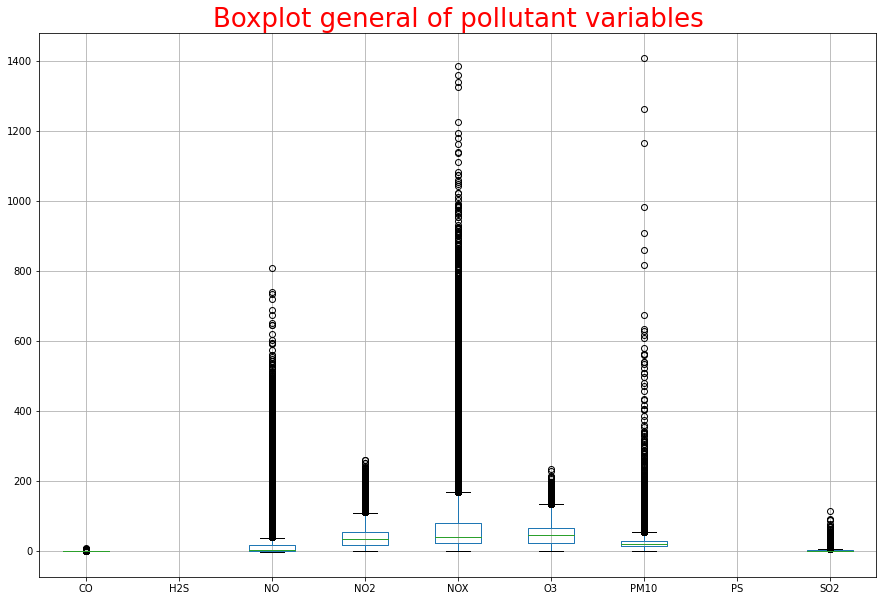

In [25]:
axes=data_air_hourly.boxplot(figsize=(15,10))
plt.title("Boxplot general of pollutant variables", fontsize=26, color='red')
plt.show()

La misma información la podemos representar agrupando los datos para cada variable por estaciones.

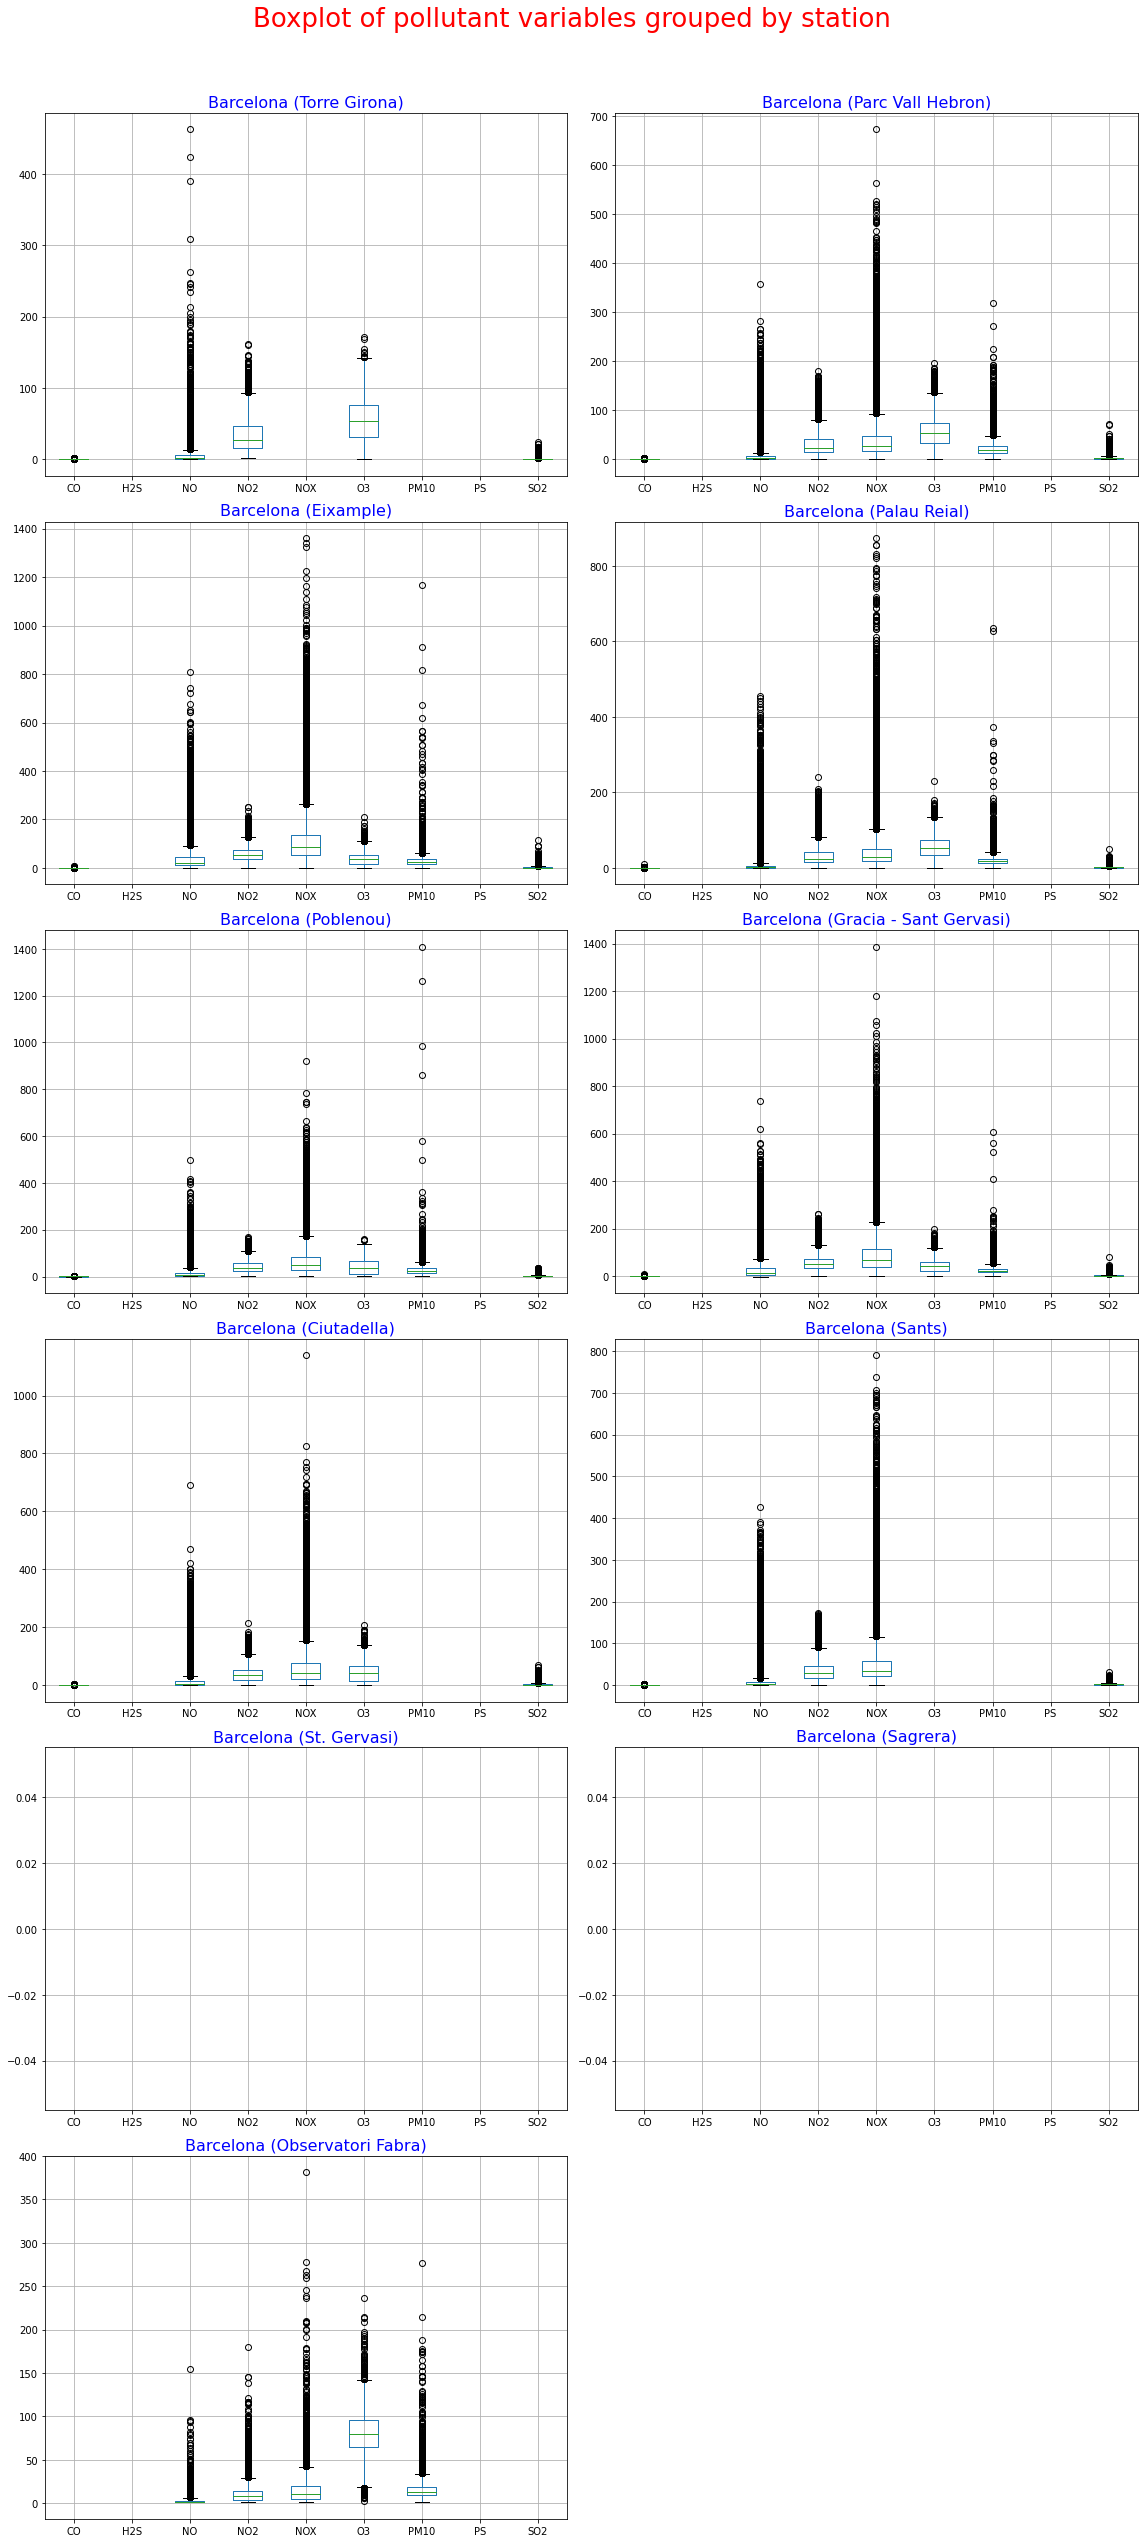

In [26]:
codiEois = data_air_hourly['CODI_EOI'].unique()
nroItems=len(codiEois)
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

codiEois=np.append(codiEois, [None] * (nroItems % ncols))
        
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*8,nrows*6))
for codiEoi, ax in zip(codiEois, axes.flatten()):
    if codiEoi:
        nom_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == codiEoi,'NOM_ESTACIO'].iloc[0]
        title='{}'.format(nom_estacio)
        data_air_hourly[data_air_hourly["CODI_EOI"] == codiEoi].boxplot(ax=ax)
        ax.set_title(title, fontsize=16, color='blue')
    else:
        ax.remove()
plt.suptitle('Boxplot of pollutant variables grouped by station', fontsize=26, color='red')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Podemos observar, en estas figuras, la presencia de valores extremos. Sin embargo, en nuestro caso, optaremos por mantener estos datos, pues se entiende que son valores correctamente observados y posibles. También vemos en este gráfico, como no todos los contaminantes, de los que tenemos datos, son registrados en todas las estaciones. Así, por ejemplo, hay dos estaciones que no registran datos ni de CO, ni de O<sub>3</sub>, ni de SO<sub>2</sub>.

A continuación, evaluamos la correlación existente entre las distintas variables de nuestro conjunto de datos. Para ello podemos aplicar un índice de correlación lineal o de rango, como por ejemplo Pearson, Kendall o Spearman. Cualquiera de estos tres índices lo podemos aplicar utilizando el método: DataFrame.corr(method : {‘pearson’, ‘kendall’, ‘spearman’}) incluido en la libreria pandas.

In [27]:
#method : {‘pearson’, ‘kendall’, ‘spearman’}
data_air_hourly.corr(method='pearson')

CO  H2S        NO       NO2       NOX        O3      PM10  PS  \
CO    1.000000  NaN  0.756497  0.677009  0.779051 -0.422563  0.426141 NaN   
H2S        NaN  NaN       NaN       NaN       NaN       NaN       NaN NaN   
NO    0.756497  NaN  1.000000  0.669888  0.959111 -0.482047  0.410474 NaN   
NO2   0.677009  NaN  0.669888  1.000000  0.849375 -0.673048  0.449133 NaN   
NOX   0.779051  NaN  0.959111  0.849375  1.000000 -0.590489  0.455587 NaN   
O3   -0.422563  NaN -0.482047 -0.673048 -0.590489  1.000000 -0.195907 NaN   
PM10  0.426141  NaN  0.410474  0.449133  0.455587 -0.195907  1.000000 NaN   
PS         NaN  NaN       NaN       NaN       NaN       NaN       NaN NaN   
SO2   0.304818  NaN  0.349237  0.344937  0.350357 -0.098663  0.352289 NaN   

           SO2  
CO    0.304818  
H2S        NaN  
NO    0.349237  
NO2   0.344937  
NOX   0.350357  
O3   -0.098663  
PM10  0.352289  
PS         NaN  
SO2   1.000000

Vemos, en los resultados de la tabla anterior, que exite una relación directa entre los distintos tipos de óxidos de nitrógeno: óxido nítrico (NO), óxido de nitrógeno (NO2), dióxido de nitrógeno (NOX). No obstante, conocemos que NO<sub>X</sub>=NO+NO<sub>2</sub>. Sin embargo, dado que la forma en la que se produce la concentración de estos gases es distinta según diversos factores y, todos ellos resultan nocivos para la salud, conservaremos todos estos datos para ser analizados durante nuestra modelización. 


A continuación, evaluaremos la variabilidad de cada una de estas variables en el tiempo. Para ello, representamos los valores para cada una de los contaminantes, en cada una de las estaciones, con la variable de tiempo, 'DATA', en el eje de abscisas.

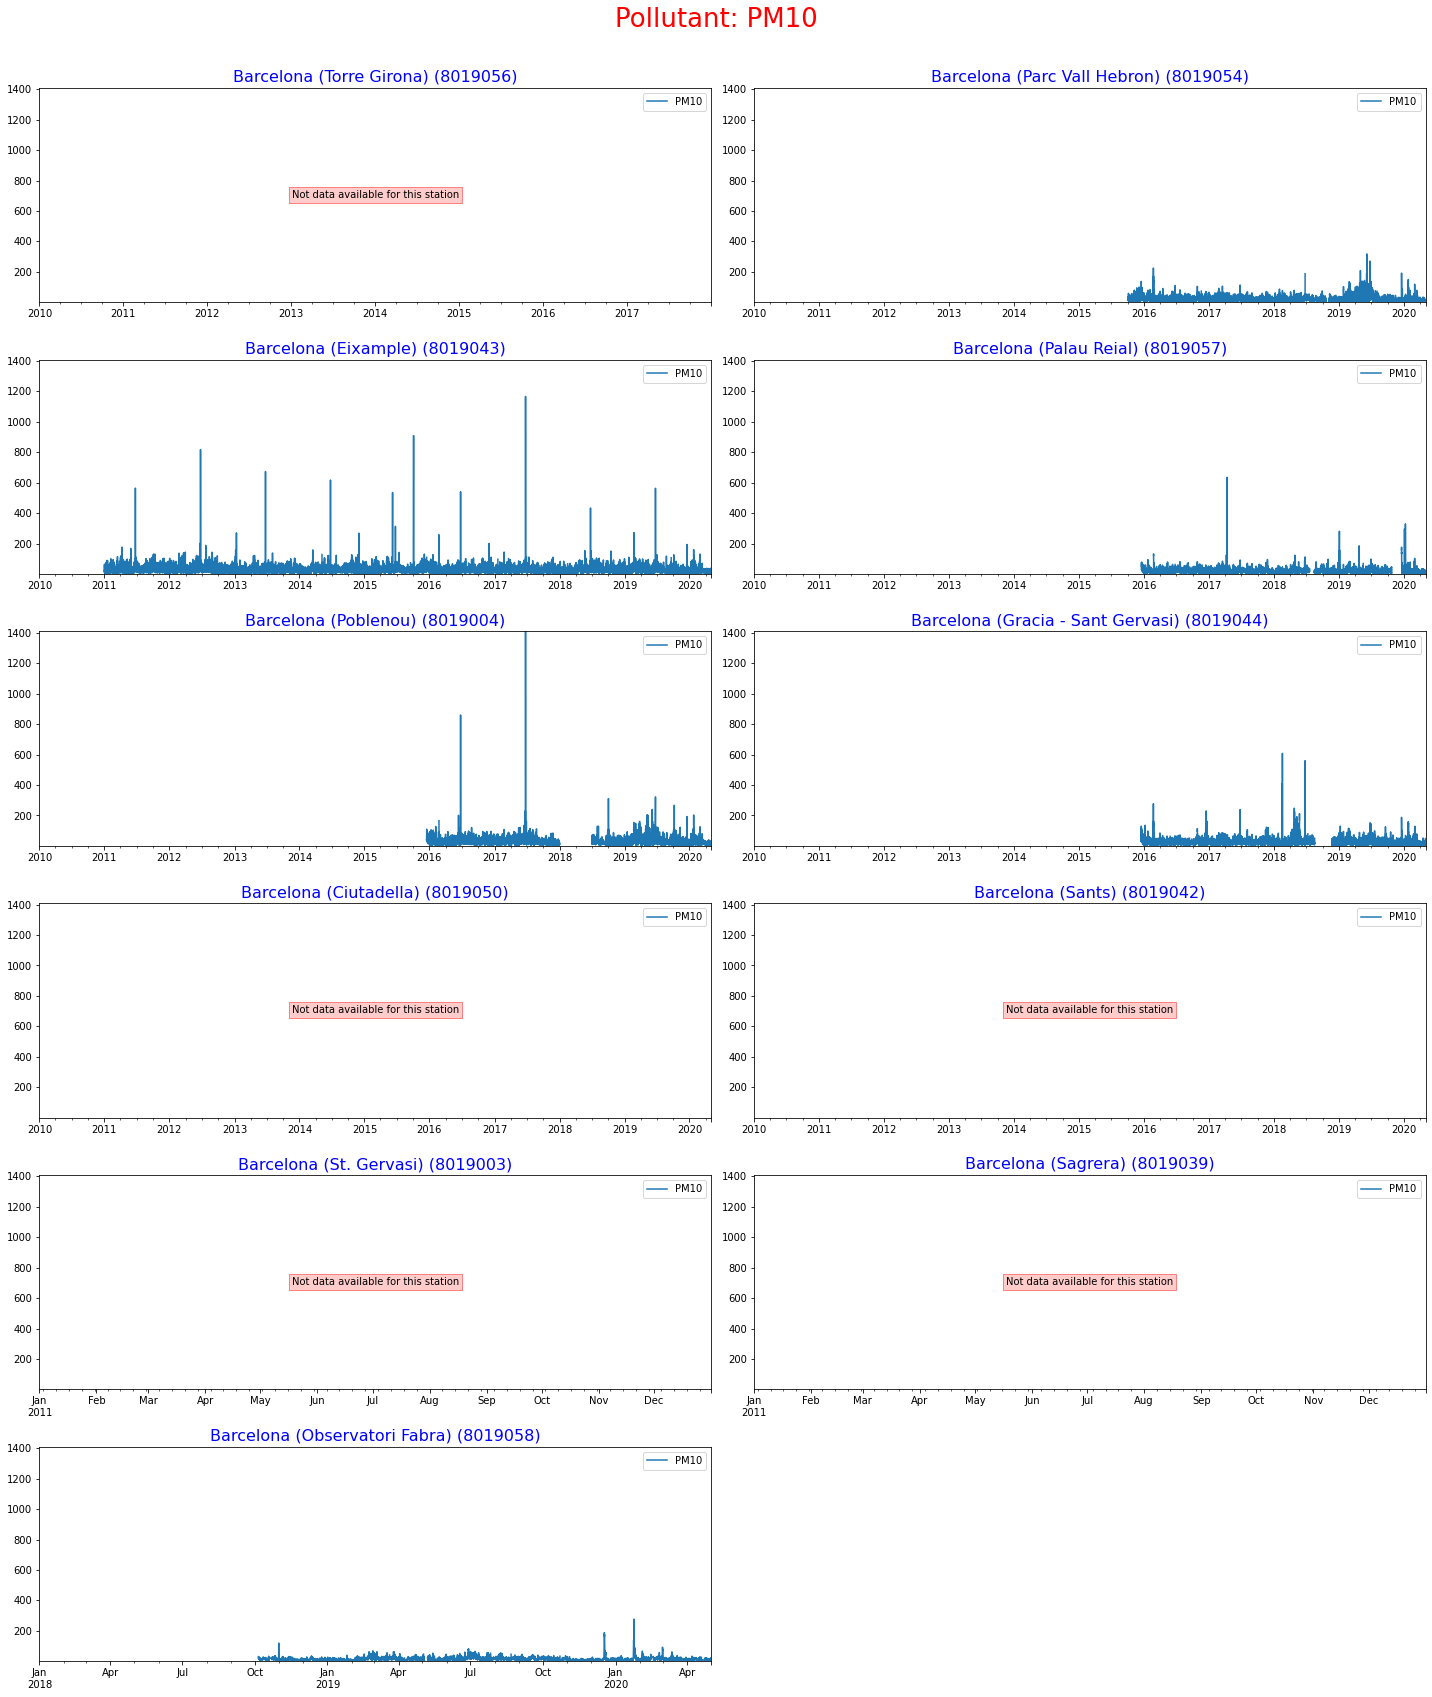

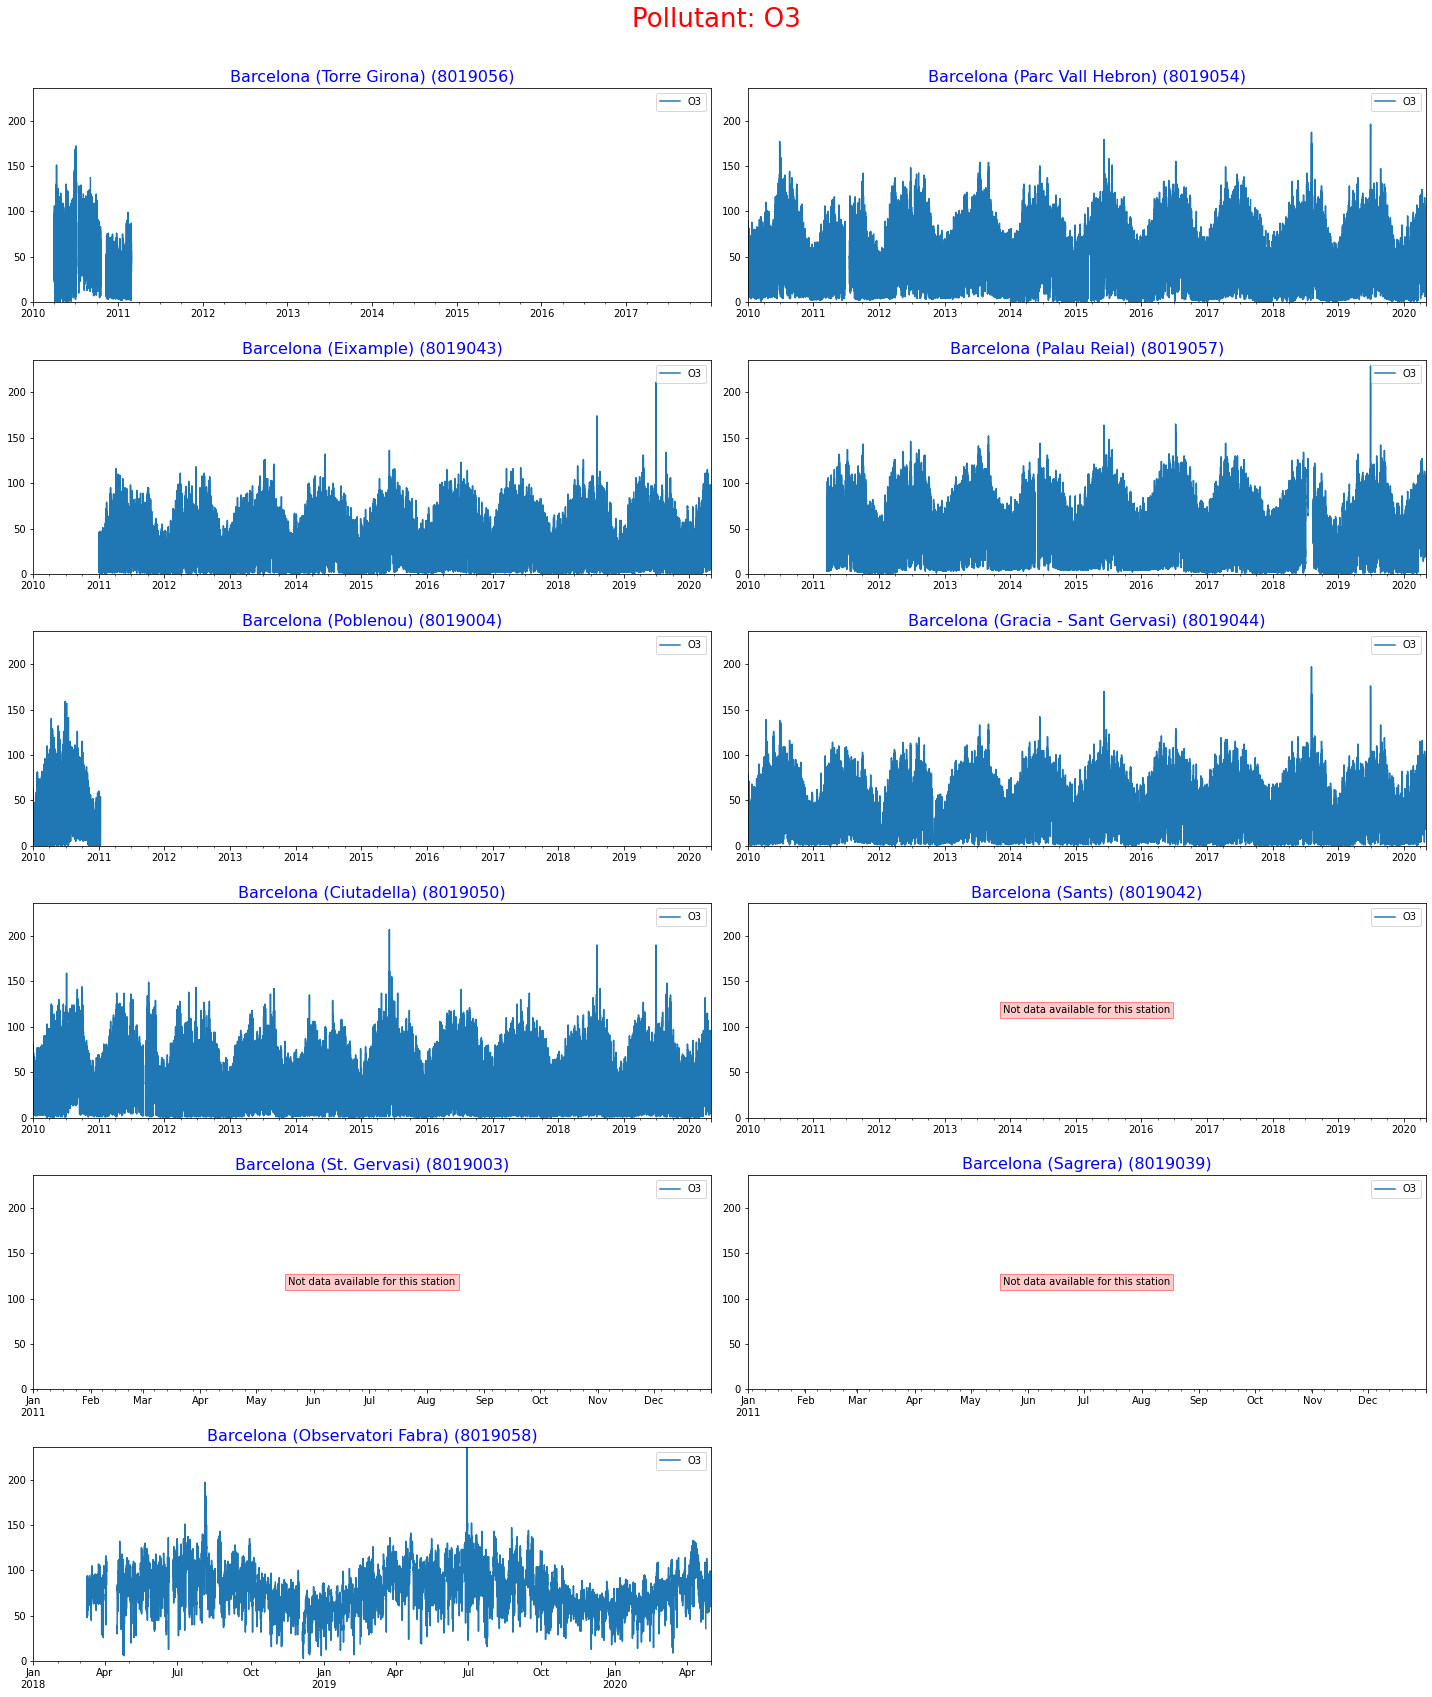

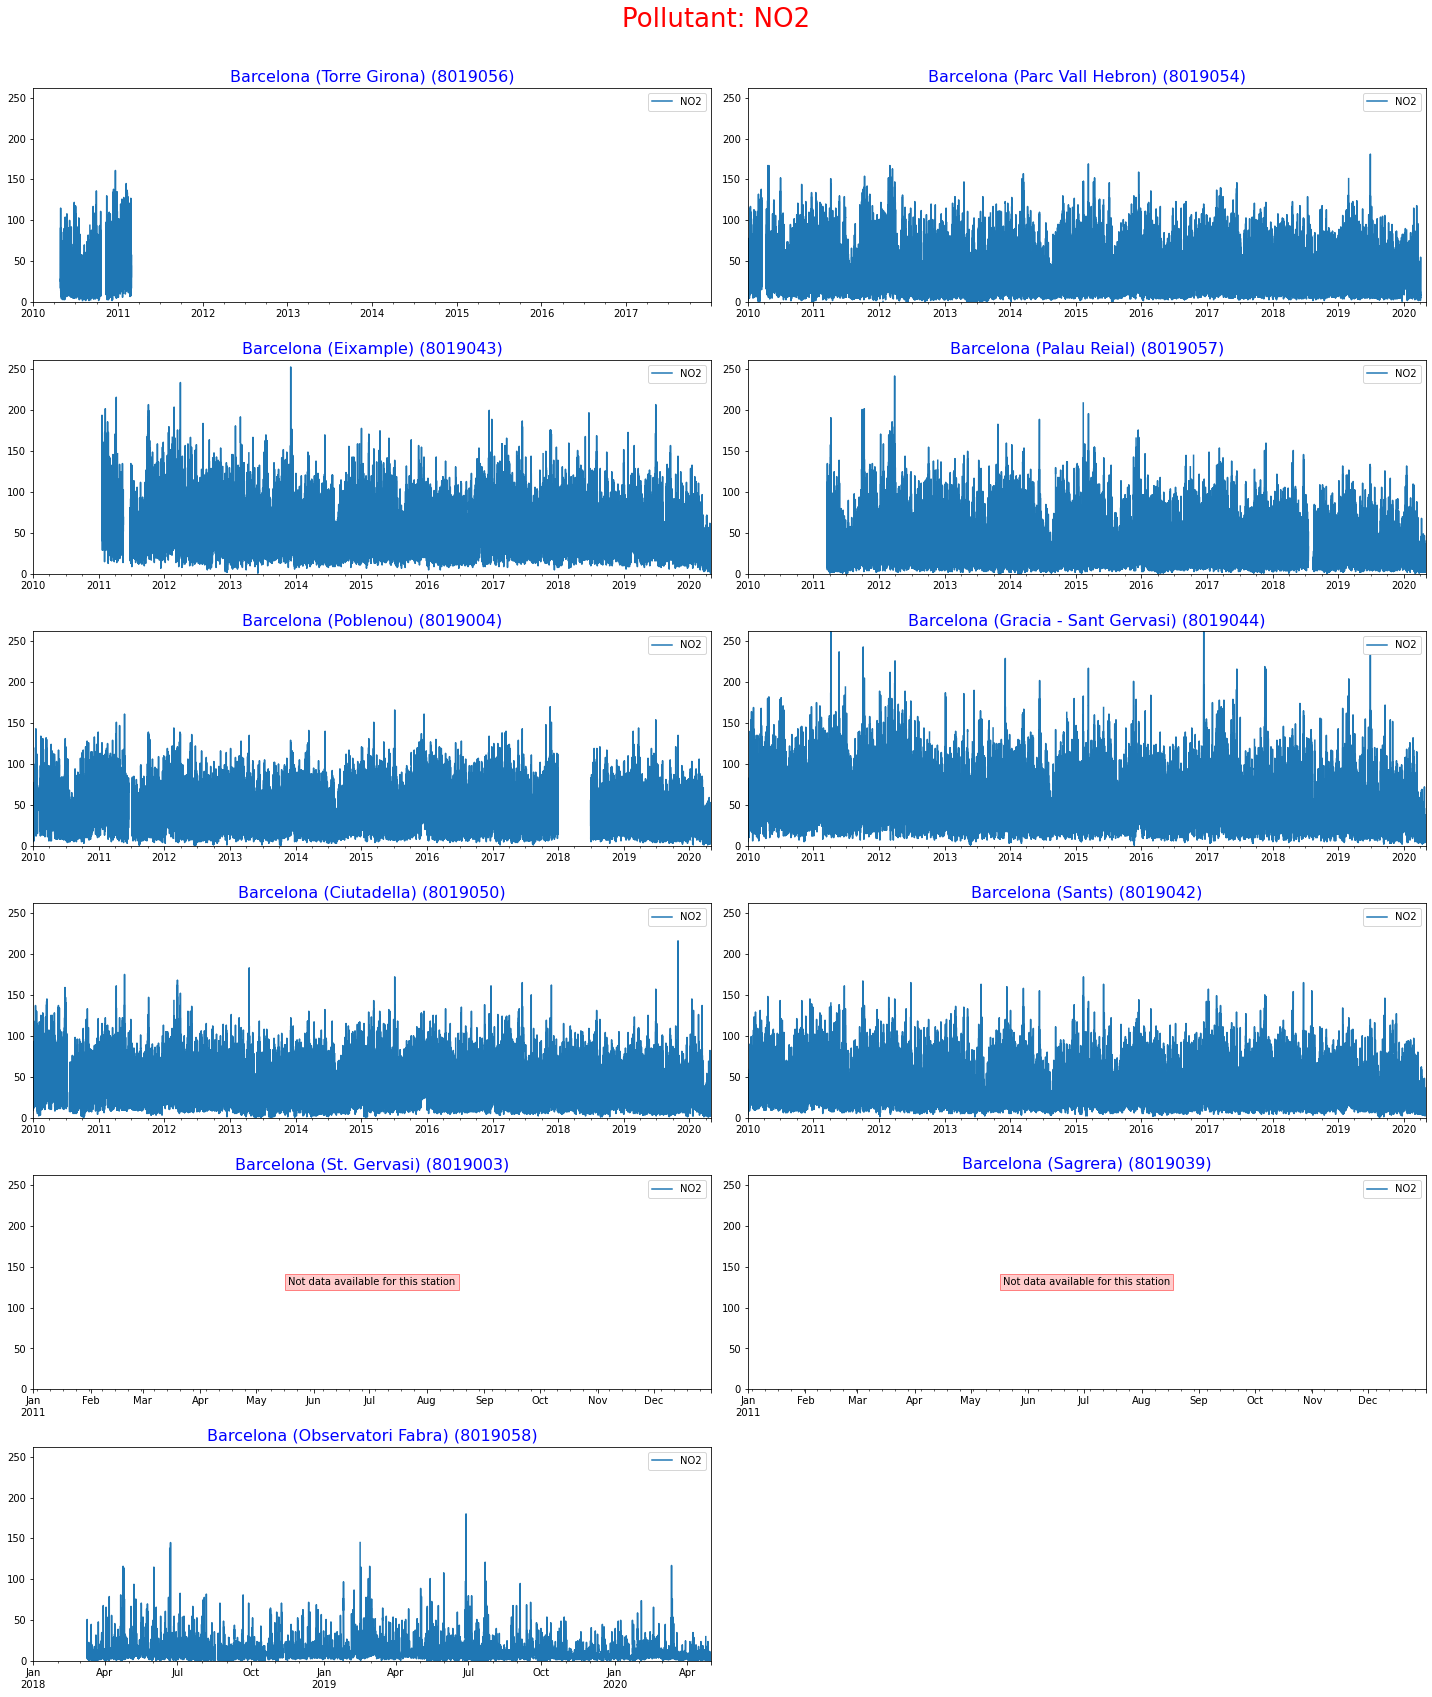

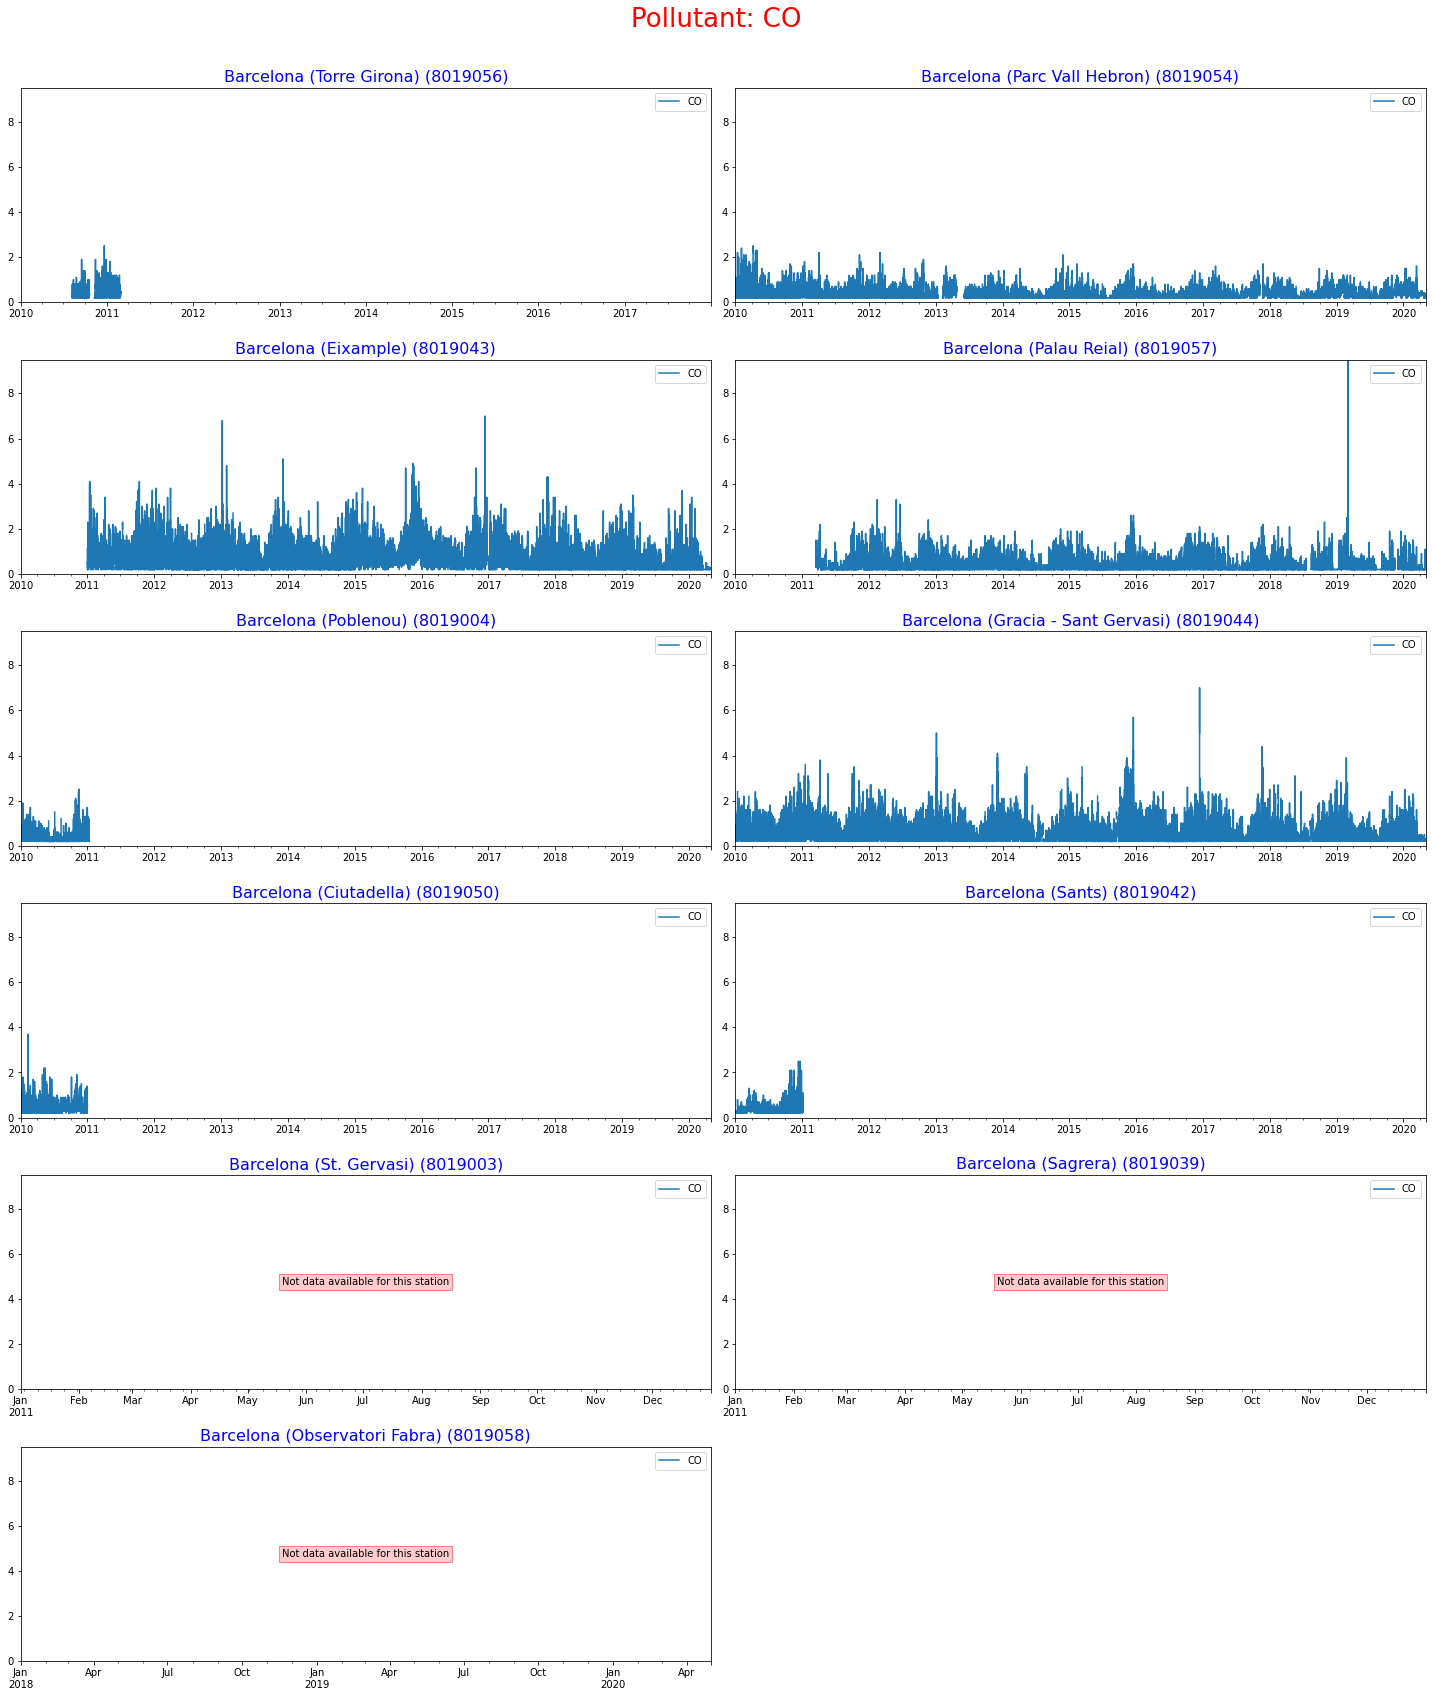

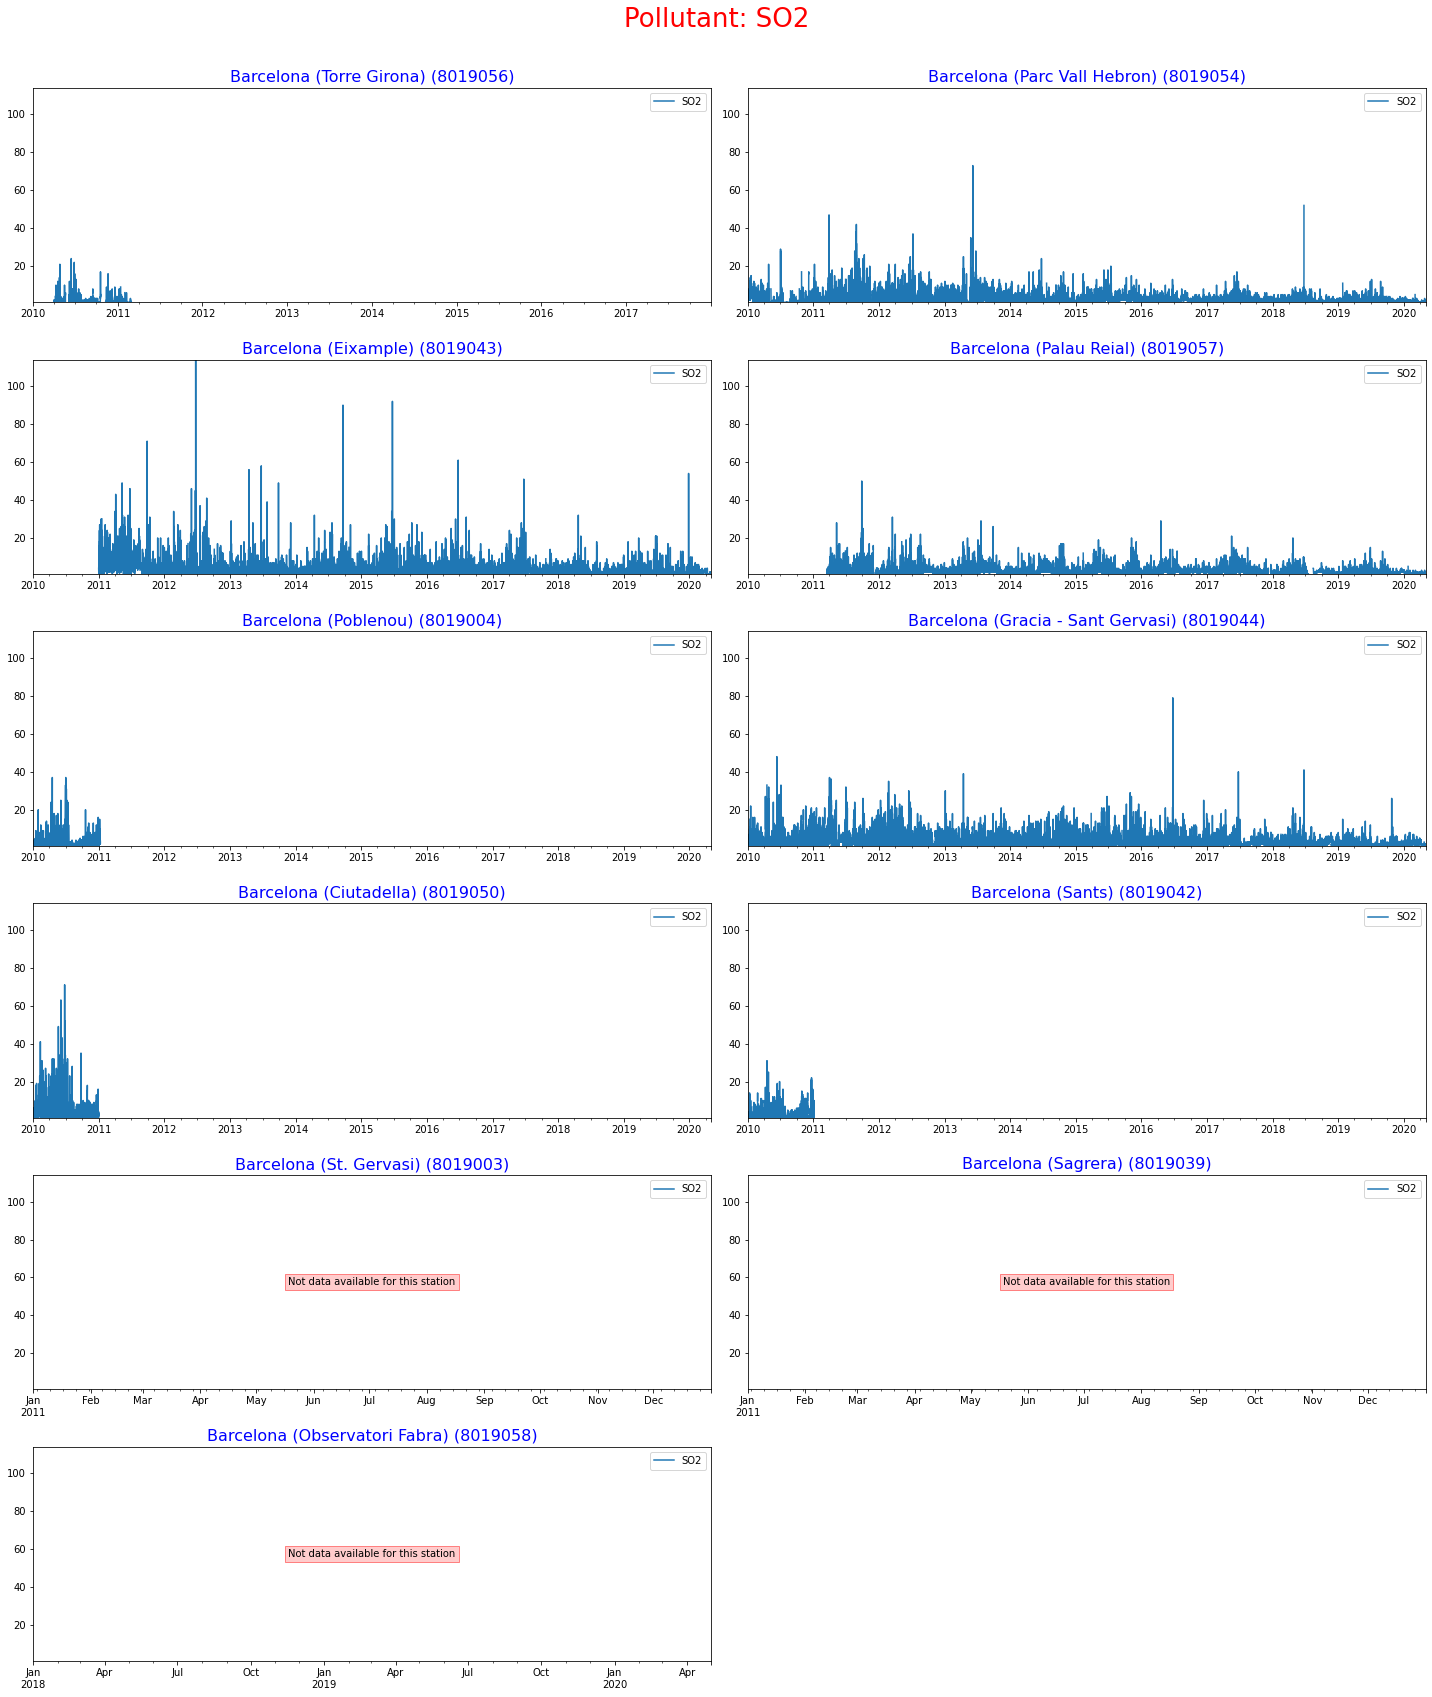

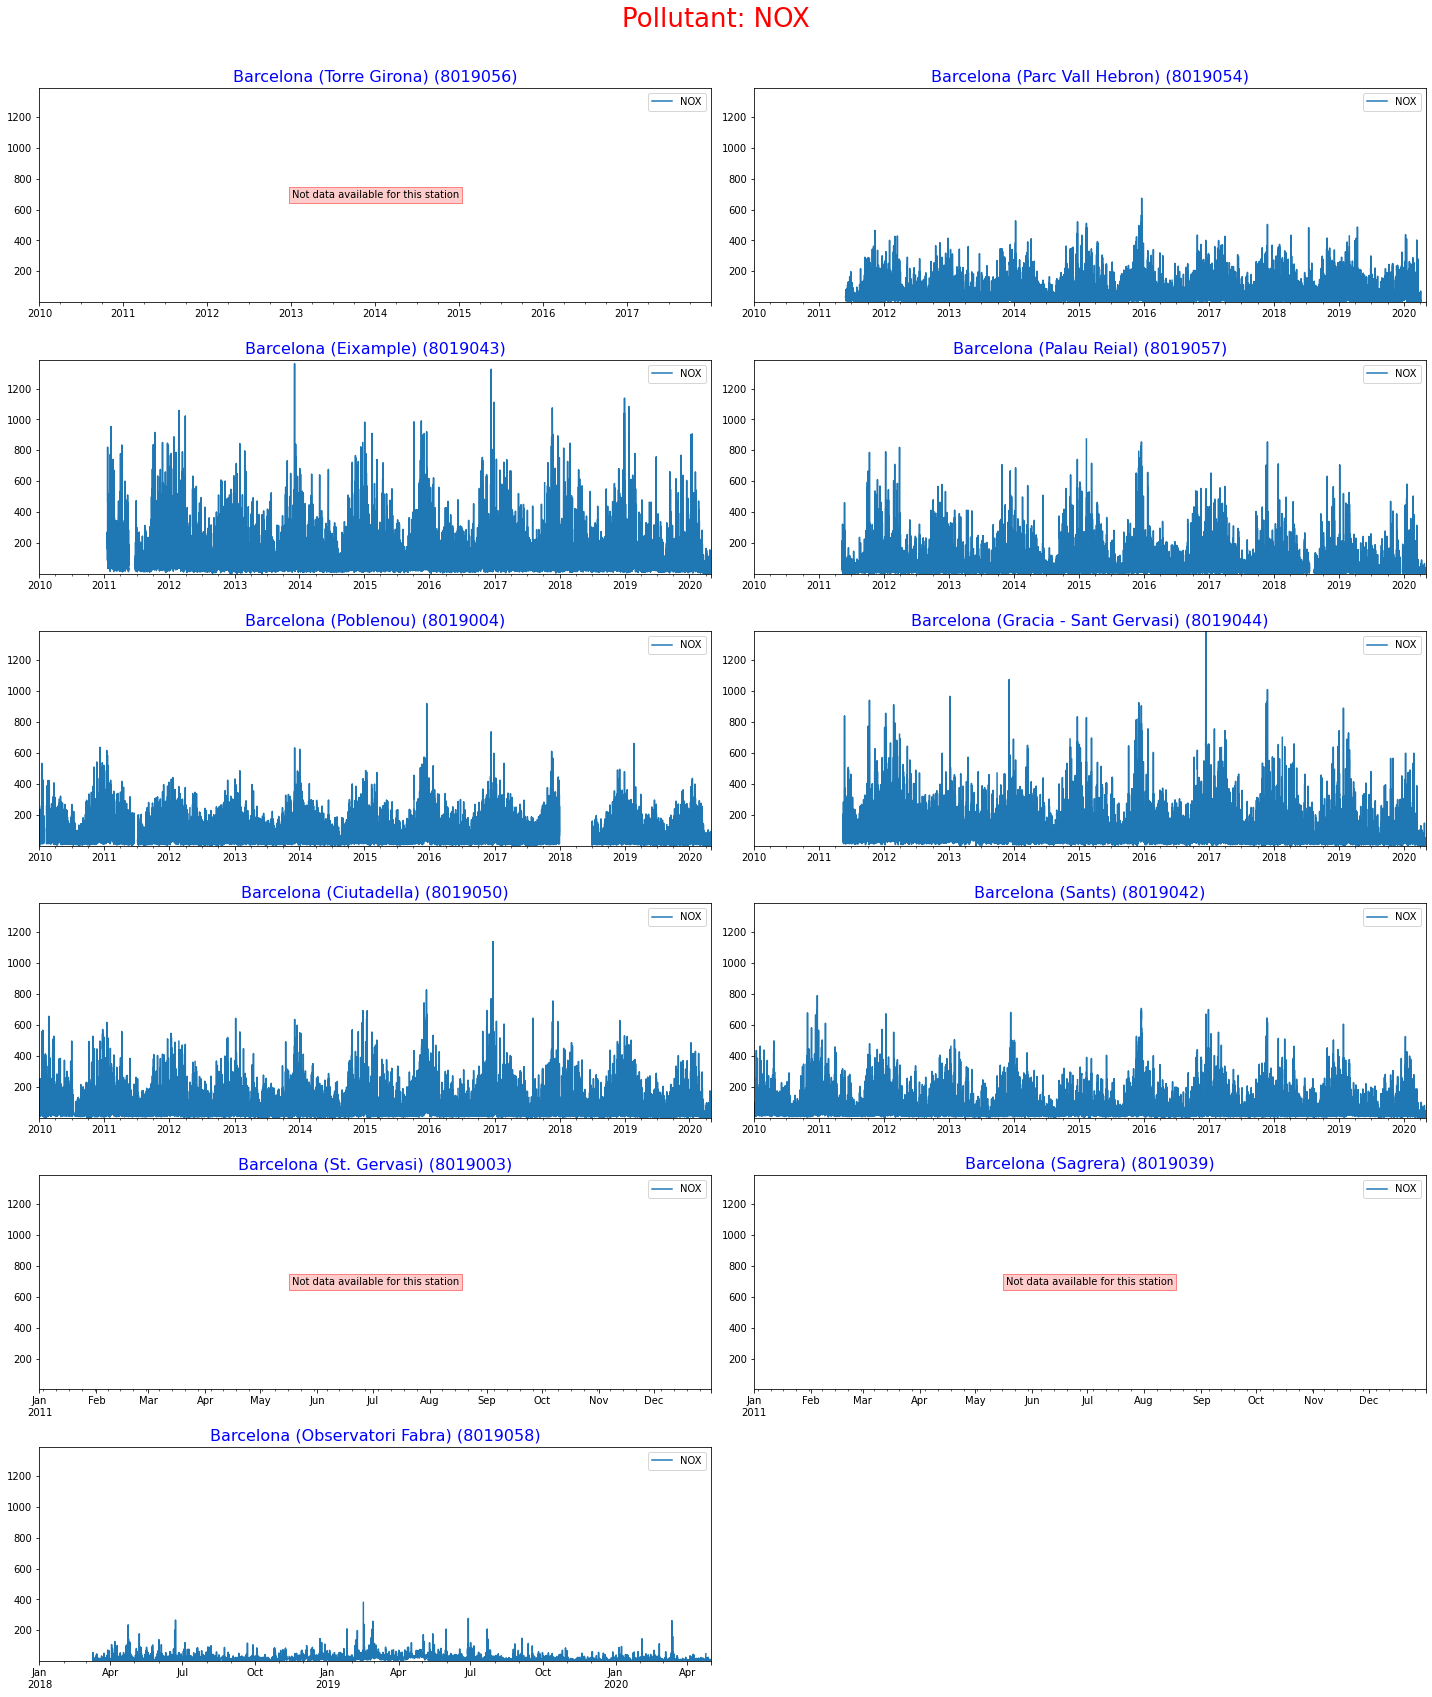

<Figure size 1440x1728 with 0 Axes>

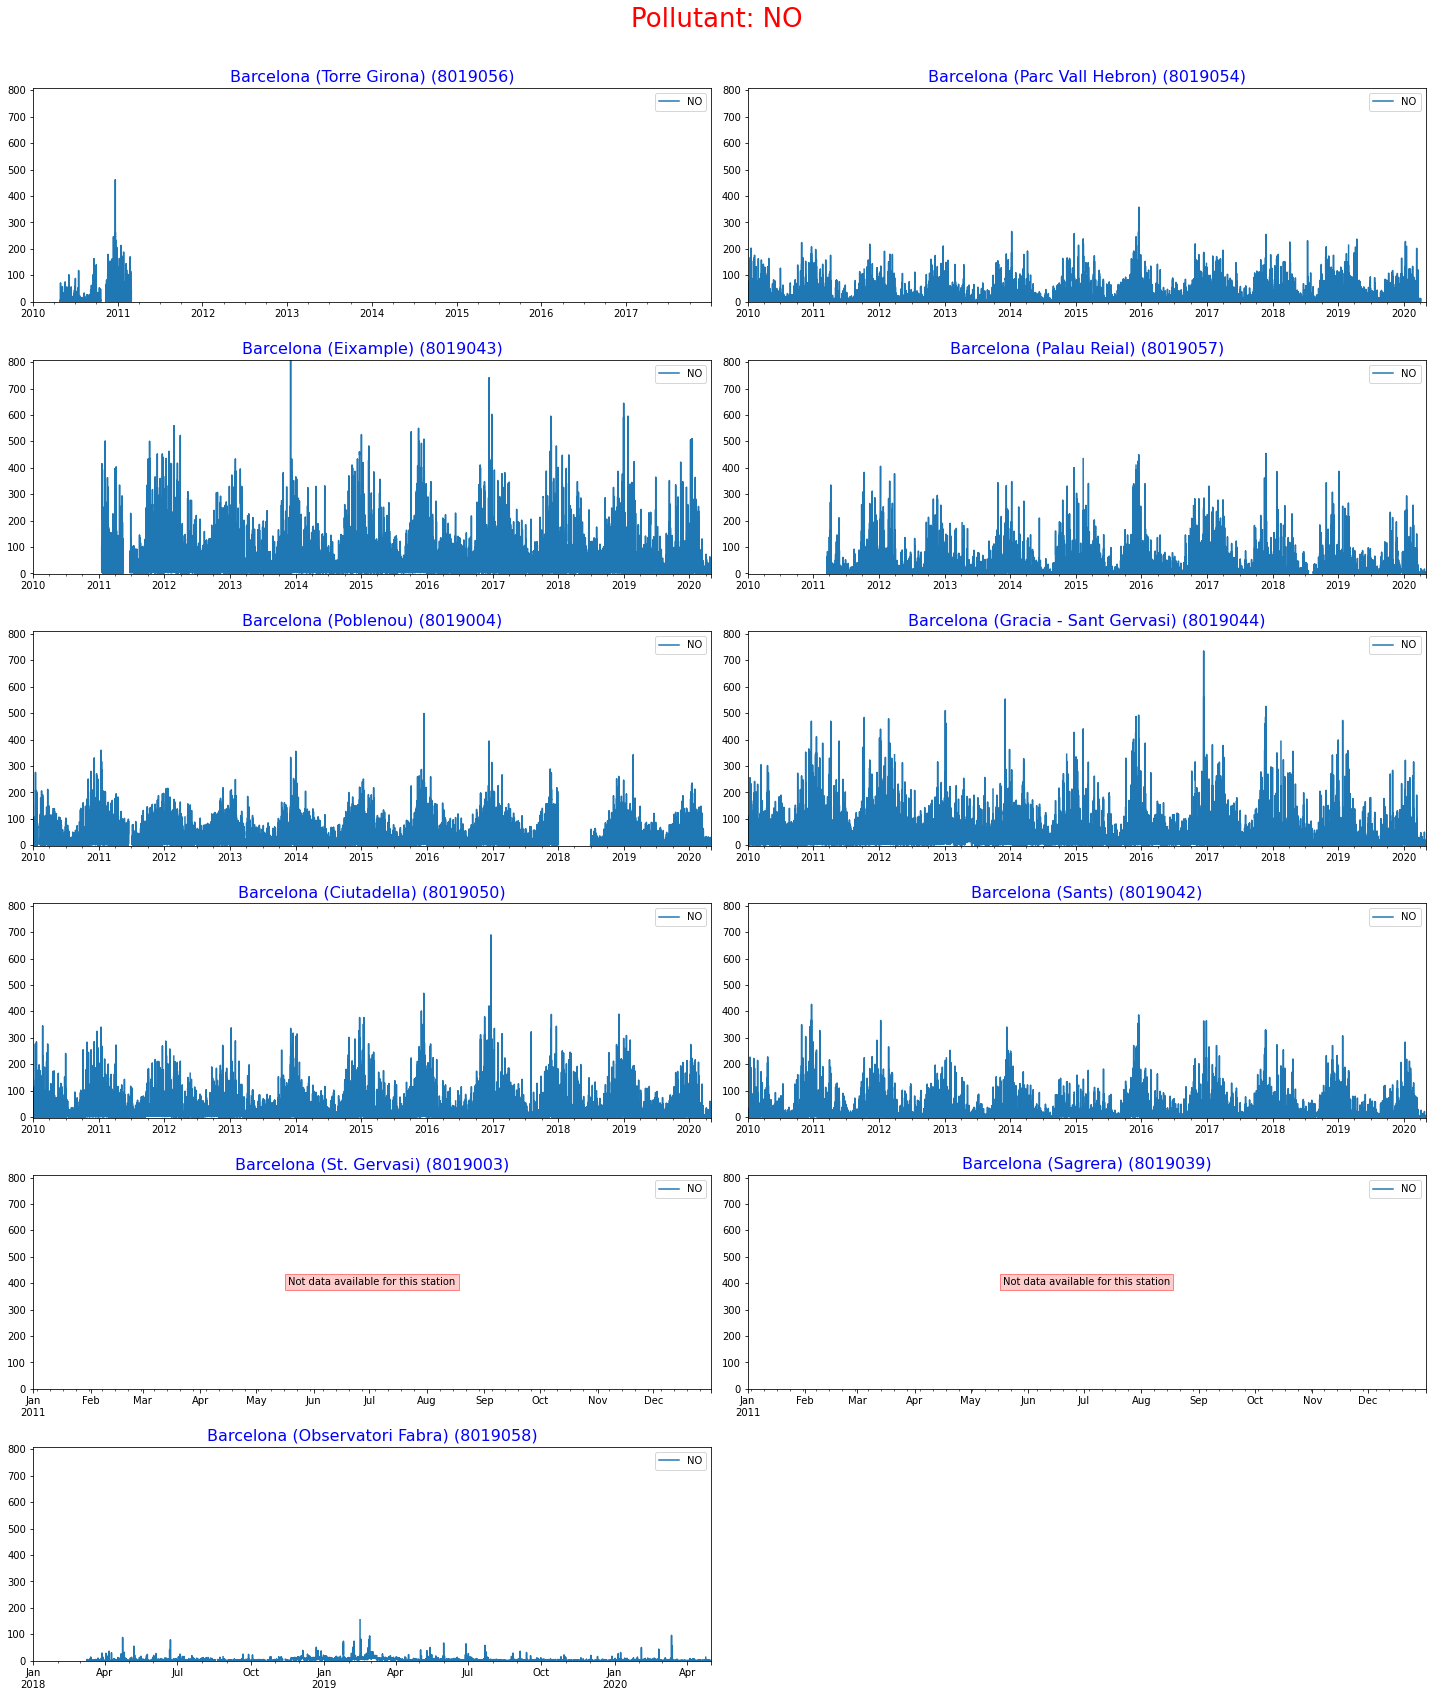

<Figure size 1440x1728 with 0 Axes>

In [ ]:
idStations = data_air_hourly['CODI_EOI'].unique()
nroItems=len(idStations)
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

idStations=np.append(idStations, [None] * (nroItems % ncols))

variables=data_air['CONTAMINANT'].unique()
#variables['PM10', 'O3', 'NO2', 'CO', 'SO2', 'NOX', 'NO']
#variables=np.array(['NO', 'NO2','NOX','PM10','CO','O3','SO2'])

for variable in variables:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*10,nrows*4))
    for idStation, ax in zip(idStations, axes.flatten()) :
        if idStation:
            nom_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == idStation,'NOM_ESTACIO'].iloc[0]
            title='{} ({})'.format(nom_estacio, idStation)
            try:
                data=data_air_hourly.loc[(data_air_hourly["CODI_EOI"] == idStation), ['DATA', variable]].set_index('DATA')    
                if data.count()[0] > 0:  
                    data.plot(ax=ax)     
                    ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                    ax.set_title(title, fontsize=16, color='blue')
                    ax.set_xlabel('')
                else:
                    data.plot(ax=ax)
                    text='Not data available for this station'
                    ax.text(0.5, 0.5, text, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,
                            bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
                    #plt.text(5, 5, text, ha='right', rotation=-15, wrap=True)
                    ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                    ax.set_title(title, fontsize=16, color='blue')
                    ax.set_xlabel('')
            except:
                ax.remove()
        else:
            ax.remove()
        
    plt.suptitle('Pollutant: {}'.format(variable), fontsize=26, color='red')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 3. Selección de estaciones

Para nuestro modelo, utilizaremos solamente aquellas estaciones en las que se recogen el mayor número de variables. Por lo tanto, de momento, descartaremos las estaciones de St. Gervasi y Sagrera. Puesto que, para estas estaciones no tenemos ninguna instacia válida, tal y como se refleja en las gráficas anteriores. Probablemente esto se deba a que sean estaciones antiguas ya desmanteladas. 

En las siguientes dos tablas mostramos, para cada estación de vigilancia, las fechas de inicial y final en las que tenemos valores regristrados para cada contaminante. 

In [ ]:
datas = pd.DataFrame()
stations=data_air_hourly['CODI_EOI'].unique()
variables=data_air['CONTAMINANT'].unique()
for station in stations:
    row = {'CODI_EOI':[station]}
    row['NOM_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'NOM_ESTACIO'].iloc[0]]
    #row['TIPUS_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'TIPUS_ESTACIO'].iloc[0]]
    #row['AREA URBANA']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'AREA URBANA'].iloc[0]]
    for variable in variables:
        data=data_air_hourly.loc[data_air_hourly['CODI_EOI'] == station,].set_index('DATA')
        ts = pd.Series(data[variable].values, index=data.index)
        first_valid_index = ts.first_valid_index()
        row[variable] = [None if first_valid_index is None else first_valid_index.strftime('%Y-%m-%d')]
    datas = datas.append(pd.DataFrame.from_dict(row), ignore_index=True, sort=False)
datas.set_index('CODI_EOI')
datas

CODI_EOI                        NOM_ESTACIO        PM10          O3  \
0   8019056           Barcelona (Torre Girona)        None  2010-04-01   
1   8019054       Barcelona (Parc Vall Hebron)  2015-10-02  2010-01-01   
2   8019043               Barcelona (Eixample)  2011-01-01  2011-01-01   
3   8019057            Barcelona (Palau Reial)  2015-12-17  2011-03-17   
4   8019004               Barcelona (Poblenou)  2015-12-16  2010-01-01   
5   8019044  Barcelona (Gracia - Sant Gervasi)  2015-12-16  2010-01-01   
6   8019050             Barcelona (Ciutadella)        None  2010-01-01   
7   8019042                  Barcelona (Sants)        None        None   
8   8019003            Barcelona (St. Gervasi)        None        None   
9   8019039                Barcelona (Sagrera)        None        None   
10  8019058      Barcelona (Observatori Fabra)  2018-10-05  2018-03-09   

           NO2          CO         SO2         NOX   H2S          NO    PS  
0   2010-04-28  2010-08-05  2010-04-01        None  None  2010-04-28  None  
1   2010-01-01  2010-01-01  2010-01-01  2011-05-30  None  2010-01-01  None  
2   2011-01-17  2011-01-01  2011-01-01  2011-01-17  None  2011-01-17  None  
3   2011-03-17  2011-03-17  2011-03-17  2011-05-11  None  2011-03-17  None  
4   2010-01-01  2010-01-01  2010-01-01  2010-01-01  None  2010-01-01  None  
5   2010-01-01  2010-01-01  2010-01-01  2011-05-16  None  2010-01-01  None  
6   2010-01-01  2010-01-01  2010-01-01  2010-01-01  None  2010-01-01  None  
7   2010-01-01  2010-01-01  2010-01-01  2010-01-01  None  2010-01-01  None  
8         None        None        None        None  None        None  None  
9         None        None        None        None  None        None  None  
10  2018-03-09        None        None  2018-03-09  None  2018-03-09  None

In [ ]:
datas = pd.DataFrame()
stations=data_air_hourly['CODI_EOI'].unique()
variables=data_air['CONTAMINANT'].unique()
for station in stations:
    row = {'CODI_EOI':[station]}
    row['NOM_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'NOM_ESTACIO'].iloc[0]]
    #row['TIPUS_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'TIPUS_ESTACIO'].iloc[0]]
    #row['AREA URBANA']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'AREA URBANA'].iloc[0]]
    for variable in variables:
        data=data_air_hourly.loc[data_air_hourly['CODI_EOI'] == station,].set_index('DATA')
        ts = pd.Series(data[variable].values, index=data.index)
        last_valid_index = ts.last_valid_index()
        row[variable] = [None if last_valid_index is None else last_valid_index.strftime('%Y-%m-%d')]
    datas = datas.append(pd.DataFrame.from_dict(row), ignore_index=True, sort=False)
datas.set_index('CODI_EOI')
datas

CODI_EOI                        NOM_ESTACIO        PM10          O3  \
0   8019056           Barcelona (Torre Girona)        None  2011-02-28   
1   8019054       Barcelona (Parc Vall Hebron)  2020-04-30  2020-04-30   
2   8019043               Barcelona (Eixample)  2020-04-30  2020-04-30   
3   8019057            Barcelona (Palau Reial)  2020-04-30  2020-04-30   
4   8019004               Barcelona (Poblenou)  2020-04-30  2011-01-10   
5   8019044  Barcelona (Gracia - Sant Gervasi)  2020-04-30  2020-04-30   
6   8019050             Barcelona (Ciutadella)        None  2020-04-30   
7   8019042                  Barcelona (Sants)        None        None   
8   8019003            Barcelona (St. Gervasi)        None        None   
9   8019039                Barcelona (Sagrera)        None        None   
10  8019058      Barcelona (Observatori Fabra)  2020-04-30  2020-04-30   

           NO2          CO         SO2         NOX   H2S          NO    PS  
0   2011-02-28  2011-02-28  2011-02-28        None  None  2011-02-28  None  
1   2020-04-03  2020-04-30  2020-04-30  2020-04-03  None  2020-04-03  None  
2   2020-04-30  2020-04-30  2020-04-30  2020-04-30  None  2020-04-30  None  
3   2020-04-30  2020-04-30  2020-04-30  2020-04-30  None  2020-04-30  None  
4   2020-04-30  2011-01-10  2011-01-10  2020-04-30  None  2020-04-30  None  
5   2020-04-30  2020-04-30  2020-04-30  2020-04-30  None  2020-04-30  None  
6   2020-04-30  2010-12-31  2010-12-31  2020-04-30  None  2020-04-30  None  
7   2020-04-30  2011-01-05  2011-01-05  2020-04-30  None  2020-04-30  None  
8         None        None        None        None  None        None  None  
9         None        None        None        None  None        None  None  
10  2020-04-30        None        None  2020-04-30  None  2020-04-30  None

Si analizamos estas tablas, vemos que para la estación de Torre Girona únicamente tenemos datos hasta fin de febrero del año 2011. Por lo tanto, esta estación tampoco nos servirá para nuestro objetivo. También descartamos las estaciones de Poblenou, Sants y Ciutadella, ya que, según vemos en la tabla de arriba, solamente tendrían suficientes datos para NO<sub>2</sub>, NO<sub>x</sub> y NO. También descartaremos la estación de Observatori Fabra, pues empezamos a tener datos a partir del año 2018.

Además de todo esto, observamos que no tenemos disponibilidad de todos las variables hasta finales de 2011, excepto PM<sub>10</sub>, de la cual empezamos a tener disponibilidad a finales de 2015. Por lo tanto, vamos a considerar para nuestro estudio, unicamente las instancias registradas a partir del uno de enero de 2012.

Después de descartar algunas de las estaciones, nos quedan un total de cuatro, dos de tipo 'background' y otras dos de tipo 'traffic'. Así, si solamente visualizamos las estaciones que nos quedan, en el mapa, tenemos:

In [ ]:
# Create a Map instance
m = folium.Map(location=[mean(lat), mean(lon)], 
               width=1250, height=700,
               zoom_start=13, 
               min_zoom=13, max_zoom=13, 
               control_scale=False, zoom_control=False)

discardedEOIs = ['8019003', '8019004', '8019039', '8019042', '8019050', '8019056', '8019058']
codiEOIs = ['8019043', '8019044', '8019054', '8019057']
for index, row in data_air_stations.iterrows():
    if row['CODI_EOI'] in discardedEOIs: 
    #if row['CODI_EOI'] not in codiEOIs: 
        continue
    text='''<b>{}</b>
<br>Code station: <b>{}</b>
<br>Type: <b>{}</b>
<br>Area: <b>{}</b>'''.format(row['NOM_ESTACIO'],row['CODI_EOI'],row['TIPUS_ESTACIO'],row['AREA URBANA'])
    folium.Marker(
        location=[row['LATITUD'], row['LONGITUD']], 
        tooltip=text,
        icon=folium.Icon(color='blue', icon='exclamation-sign'),
    ).add_to(m)
m

Ahora vamos a añadir a este mapa las estaciones de meteorológicas, en Barcelona, que ya hemos visto en otro análisis anterior.

In [ ]:
# Read meteo stations metadata file
meteoStationsPath=os.path.join(rootDataFolder, 'meteo/meta/meteo_stations.json')
if not os.path.exists(meteoStationsPath):
    meteoStationsPath='https://analisi.transparenciacatalunya.cat/resource/yqwd-vj5e.json'
meteoStations=pd.read_json(meteoStationsPath, orient='records', encoding='UTF-8')

Filtramos para quedarnos exclusivamente con las estaciones meteorológicas ubicadas en Barcelona que se encuentren operativa.

In [ ]:
# Aggregate by most frequent value
data_meteo_stations=meteoStations.loc[(meteoStations['nom_estat_ema'] == 'Operativa') & (meteoStations['nom_municipi'] == 'Barcelona'), 
                  ['longitud','latitud','emplacament','data_inici','codi_estacio']]
data_meteo_stations

longitud   latitud                                        emplacament  \
2     2.16775  41.38390  Facultat de Geografia i Història. c. Montalegr...   
74    2.10540  41.37919                                          Pistes UB   
164   2.18847  41.38943                                                Zoo   
221   2.12388  41.41843                                  Observatori Fabra   

                  data_inici codi_estacio  
2    2006-10-11T00:00:00.000           X4  
74   2008-04-17T00:00:00.000           X8  
164  2006-09-22T00:00:00.000           X2  
221  1995-11-03T00:00:00.000           D5

Y añadimos estas estaciones meteorológicas al mapa anterior, en color gris, para distingirlas de las estaciones de vigilancia de contaminación del aire.

In [ ]:
for index, row in data_meteo_stations.iterrows():
    text='<b>{}</b><br>From: {}<br>Code station: <b>{}</b>'.format(row['emplacament'],row['data_inici'],row['codi_estacio'])
    folium.Marker(
        location=[row['latitud'], row['longitud']], 
        tooltip=text,
        icon=folium.Icon(color='lightgray', icon='cloud'),
    ).add_to(m)
m

Según vemos sobre el mapa, observamos que existe una estación meteorológica en el Observatori Fabra. Por lo que, resulta lógico utilizar los datos recogidos por esta estación para analizarlos conjuntamente con los datos de contaminación recogidos en la estación de vigilancia del aire, situada en la misma posición. Para las demás estaciones de vigilancia utilizaremos los datos recogidos en las estaciones meteorológicas más próximas. Como ya vimos en el análisis de los datos meteorológicos, en la estación de Zoo (X2) únicamente tenemos datos de humedad relativa y temperatura. Por lo que hemos decidido prescindir de esta estación, con lo que nos quedarían solamente tres estaciones meteorológicas con las que agrupar nuestras estaciones de vigilancia de calidad del aire. Según los criterios de proximidad, marcados antes, la correspondencia entre estaciones meteorológicas y estaciones de vigilancia de calidad del aire, que utilizaremos en este estudio, será la siguiente:

- Observatori Fabra (D5): Parc Vall Hebron (8019054)
- Facultat de Geografia i Història (X4): Eixample (8019043) y Gracia - Sant Gervasi (8019044)
- Pistes UB (X8): Palau Reial (8019057) 


A continuación, vamos a añadir los tramos de la ciudad de Barcelona para los que se registra información de tránsito de vehículos.

In [ ]:
# Header definition
columns=['Tramo', 'Descripcion', 'Coordenadas']
dtype={'Tramo':np.integer, 'Descripcion':object, 'Coordenadas':object}

filename = os.path.join(rootDataFolder, "trafico/meta/transit_relacio_trams.csv")
data_tramos = pd.read_csv(filename, header=0, names=columns, sep=',', encoding = "UTF-8", dtype=dtype)
data_tramos.head()

Tramo                                   Descripcion  \
0      1     Diagonal (Ronda de Dalt a Doctor Marañón)   
1      2     Diagonal (Doctor Marañón a Ronda de Dalt)   
2      3      Diagonal (Doctor Marañón a Pl. Pius XII)   
3      4      Diagonal (Pl. Pius XII a Doctor Marañón)   
4      5  Diagonal (Pl. Pius XII a Pl. Maria Cristina)   

                                         Coordenadas  
0  2.11203535639414,41.3841912394771,2.1015028628...  
1  2.111944376806616,41.38446666680338,2.10159408...  
2  2.112093343037027,41.38422850920645,2.12264979...  
3  2.122592049318304,41.38719094189204,2.11196902...  
4  2.122657659295115,41.38694195794678,2.12755961...

Añadimos estos datos al mapa de Barcelona:

In [ ]:
# In order to generate random colors
r = lambda: random.randint(0,255)

# Represents all the trafic routes on the map
for index, row in data_tramos.iterrows():
    coordenadas=np.array(row['Coordenadas'].split(','))
    coordenadas = coordenadas.astype(np.float)
    coordenadas=np.reshape(coordenadas, (-1, 2))
    coordenadas[:,[0, 1]] = coordenadas[:,[1, 0]]
    
    if len(coordenadas) > 1:
        # Mark first and last points
        folium.CircleMarker(coordenadas[0],
                            radius=2, color="#3db7e4").add_to(m)
        folium.CircleMarker(coordenadas[len(coordenadas) - 1],
                            radius=2, color="#3db7e4").add_to(m)
        
        # Paint polyline for the trafic route
        text='<b>{}</b><br>{}'.format(row['Tramo'], row['Descripcion'])
        folium.PolyLine(coordenadas, tooltip=text,
                        color='#%02X%02X%02X' % (r(),r(),r()),
                        fill_opacity=0.3
                       ).add_to(m)
m

En este caso, para seleccionar los tramos de la vía que vamos a utilizar en nuestro trabajo, observamos aquellos tramos que se encuentren más cercanos a cada una de las estaciones de vigilancia de contaminación del aire. Al final obtendremos un dato, por cada estación, a partir del valor mayor de todos los registrados en los tramos cercanos a esa estación en un momento dado. Así, realizamos la siguiente selección de tramos por estación:

- Parc Vall Hebron (8019054): 438 y 439
- Eixample (8019043): 118, 138 y 142
- Gracia - Sant Gervasi (8019044): 77, 78, 79, 80 y 467
- Palau Reial (8019057): 3, 4, 16 y 17


In [ ]:
# Create a Map instance
m = folium.Map(location=[mean(lat), mean(lon)], 
               width=1250, height=700,
               zoom_start=13, 
               min_zoom=13, max_zoom=13, 
               control_scale=False, zoom_control=False)

discardedEOIs = ['8019003', '8019004', '8019039', '8019042', '8019050', '8019056', '8019058']
codiEOIs = ['8019043', '8019044', '8019054', '8019057']
for index, row in data_air_stations.iterrows():
    if row['CODI_EOI'] in discardedEOIs: 
    #if row['CODI_EOI'] not in codiEOIs:
      continue
    text='''<b>{}</b>
<br>Code station: <b>{}</b>
<br>Type: <b>{}</b>
<br>Area: <b>{}</b>'''.format(row['NOM_ESTACIO'],row['CODI_EOI'],row['TIPUS_ESTACIO'],row['AREA URBANA'])
    folium.Marker(
        location=[row['LATITUD'], row['LONGITUD']], 
        tooltip=text,
        icon=folium.Icon(color='blue', icon='exclamation-sign'),
    ).add_to(m)

discardedStation = ['X2']
for index, row in data_meteo_stations.iterrows():
    if row['codi_estacio'] in discardedStation: 
        continue
    text='<b>{}</b><br>From: {}<br>Code station: <b>{}</b>'.format(row['emplacament'],row['data_inici'],row['codi_estacio'])
    folium.Marker(
        location=[row['latitud'], row['longitud']], 
        tooltip=text,
        icon=folium.Icon(color='lightgray', icon='cloud'),
    ).add_to(m)
    r = lambda: random.randint(0,255)

studied_trams = [3, 4, 16, 17, 
                 77, 78, 79, 80, 467, 
                 118, 138, 142,
                 438, 439]
# Represents all the trafic routes on the map
for index, row in data_tramos.iterrows():
    if not row['Tramo'] in studied_trams: continue
    coordenadas=np.array(row['Coordenadas'].split(','))
    coordenadas = coordenadas.astype(np.float)
    coordenadas=np.reshape(coordenadas, (-1, 2))
    coordenadas[:,[0, 1]] = coordenadas[:,[1, 0]]
    
    if len(coordenadas) > 1:
        # Mark first and last points
        folium.CircleMarker(coordenadas[0],
                            radius=2, color="#3db7e4").add_to(m)
        folium.CircleMarker(coordenadas[len(coordenadas) - 1],
                            radius=2, color="#3db7e4").add_to(m)
        
        # Paint polyline for the trafic route
        text='<b>{}</b><br>{}'.format(row['Tramo'], row['Descripcion'])
        folium.PolyLine(coordenadas, tooltip=text,
                        color='#%02X%02X%02X' % (r(),r(),r()),
                        fill_opacity=0.3
                       ).add_to(m)
m

Para finalizar este apartado vamos a obtener una versión del dataframe de datos de contaminantes, data_air_hourly, al cual eliminamos aquellos datos que no nos servirán en nuestro estudio posterior.

In [ ]:
discardedEOIs = ['8019003', '8019004', '8019039', '8019042', '8019050', '8019056', '8019058']
data_air_hourly_red = data_air_hourly[data_air_hourly['CODI_EOI'].map(lambda x: x not in discardedEOIs)]
data_air_hourly_red = data_air_hourly_red.drop(['H2S', 'PS'], axis=1)
data_air_hourly_red = data_air_hourly_red.set_index(['DATA'])
data_air_hourly_red = data_air_hourly_red.loc['2012-01-01':].reset_index()
data_air_hourly_red.head()

DATA   CO    NO   NO2    NOX    O3  PM10   SO2 CODI_EOI
0 2012-01-01 00:00:00  0.2   3.0  10.0   14.0  39.0   NaN   1.0  8019057
1 2012-01-01 00:00:00  0.7  71.0  67.0  176.0   8.0  31.0   2.0  8019043
2 2012-01-01 00:00:00  0.4   NaN   NaN    NaN  40.0   NaN  10.0  8019054
3 2012-01-01 00:00:00  0.5  35.0  56.0  110.0  11.0   NaN   1.0  8019044
4 2012-01-01 01:00:00  0.5   1.0  12.0   14.0  41.0   NaN   9.0  8019054

Guardamos el nuevo dataframe en un fichero:

In [ ]:
data_air_hourly_red.to_csv(os.path.join(rootDataFolder, 'data_air_hourly_red.csv'), index = False)

# 4. Imputación de datos

Por ultimo, hemos visto que, a pesar de que, en las estaciones seleccionadas, tenemos datos de varias de las variables, en muchos de estos casos, existen franjas de tiempo en las cuales no se ha registrado ningún valor. Esto puede haber sido causado por motivos tan diversos como: malfuncionamiento de los instrumentos de medida y, por consiguiente, la eliminación de estos valores, o por interrupción de las medidas bien por averia en los instrumentos de medida o mantenimiento en las estaciones.

In [ ]:
datas = pd.DataFrame()
stations=data_air_hourly_red['CODI_EOI'].unique()
variables = np.delete(data_air_hourly_red.columns, np.where(np.isin(data_air_hourly_red.columns, ['CODI_EOI', 'DATA'])))
for station in stations:
    row = {'CODI_EOI':[station]}
    row['NOM_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'NOM_ESTACIO'].iloc[0]]
    #row['TIPUS_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'TIPUS_ESTACIO'].iloc[0]]
    #row['AREA URBANA']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'AREA URBANA'].iloc[0]]
    for variable in variables:
        data=data_air_hourly_red.loc[data_air_hourly_red['CODI_EOI'] == station,].set_index('DATA')
        ts = pd.Series(data[variable].values, index=data.index)
        first_valid_index = ts.first_valid_index()
        row[variable] = [None if first_valid_index is None else first_valid_index.strftime('%Y-%m-%d')]
    datas = datas.append(pd.DataFrame.from_dict(row), ignore_index=True, sort=False)
datas.set_index('CODI_EOI')
datas

CODI_EOI                        NOM_ESTACIO          CO          NO  \
0  8019057            Barcelona (Palau Reial)  2012-01-01  2012-01-01   
1  8019043               Barcelona (Eixample)  2012-01-01  2012-01-01   
2  8019054       Barcelona (Parc Vall Hebron)  2012-01-01  2012-01-01   
3  8019044  Barcelona (Gracia - Sant Gervasi)  2012-01-01  2012-01-01   

          NO2         NOX          O3        PM10         SO2  
0  2012-01-01  2012-01-01  2012-01-01  2015-12-17  2012-01-01  
1  2012-01-01  2012-01-01  2012-01-01  2012-01-01  2012-01-01  
2  2012-01-01  2012-01-01  2012-01-01  2015-10-02  2012-01-01  
3  2012-01-01  2012-01-01  2012-01-01  2015-12-16  2012-01-01

In [ ]:
datas = pd.DataFrame()
stations=data_air_hourly_red['CODI_EOI'].unique()
variables = np.delete(data_air_hourly_red.columns, np.where(np.isin(data_air_hourly_red.columns, ['CODI_EOI', 'DATA'])))
for station in stations:
    row = {'CODI_EOI':[station]}
    row['NOM_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'NOM_ESTACIO'].iloc[0]]
    #row['TIPUS_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'TIPUS_ESTACIO'].iloc[0]]
    #row['AREA URBANA']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'AREA URBANA'].iloc[0]]
    for variable in variables:
        data=data_air_hourly_red.loc[data_air_hourly_red['CODI_EOI'] == station,].set_index('DATA')
        ts = pd.Series(data[variable].values, index=data.index)
        last_valid_index = ts.last_valid_index()
        row[variable] = [None if last_valid_index is None else last_valid_index.strftime('%Y-%m-%d')]
    datas = datas.append(pd.DataFrame.from_dict(row), ignore_index=True, sort=False)
datas.set_index('CODI_EOI')
datas

CODI_EOI                        NOM_ESTACIO          CO          NO  \
0  8019057            Barcelona (Palau Reial)  2020-04-30  2020-04-30   
1  8019043               Barcelona (Eixample)  2020-04-30  2020-04-30   
2  8019054       Barcelona (Parc Vall Hebron)  2020-04-30  2020-04-03   
3  8019044  Barcelona (Gracia - Sant Gervasi)  2020-04-30  2020-04-30   

          NO2         NOX          O3        PM10         SO2  
0  2020-04-30  2020-04-30  2020-04-30  2020-04-30  2020-04-30  
1  2020-04-30  2020-04-30  2020-04-30  2020-04-30  2020-04-30  
2  2020-04-03  2020-04-03  2020-04-30  2020-04-30  2020-04-30  
3  2020-04-30  2020-04-30  2020-04-30  2020-04-30  2020-04-30

En la tabla anterior, también podemos ver que no todas las estaciones cuentan con datos en el periodo completo desde el uno de enero de 2010 y abril de 2020. Para intentar solventar este desequilibrio en la disponibilidad de datos y imputar los datos perdidos en cada una de las estaciones, se ha diseñado un procedimiento de imputación de valores. Este procedimiento tiene en cuenta los valores registrados para una misma variable en cada instante en todas las demás estaciones y el valor registrado, para esa misma variable, en la propia estación, en el mismo día y hora de los demás años en los que se tiene registro. De esta forma, somos capaces de obtener un valor, para los valores pérdidos, que tiene en cuenta, de alguna forma, la variabilidad propia registada en cada estación para un determinado contaminante del aire.

La siguiente función implementa el procedimiento de imputación explicado anteriormente. Esta función toma como entradas el dataframe de datos a ser imputados, un parámetro indicando la columna utilizada para agrupar los datos según la estación de vigilancia (por defecto: CODI_EOI), y un tercer parámetro para indicar la columna utiliza para indexar los datos en timeseries (por defecto: DATA). 

In [ ]:
def data_imputation (data, col_group='CODI_EOI', col_date='DATA'):
    
    # Calculate daily mean values between all the groups (stations) 
    data_daily_mean_groups = data.drop(col_group, axis=1).groupby([col_date]).mean()
    
    # Obtain new column 'at_day_time' to calculate mean station value at a specific day and hour
    at_day_hour_column = 'at_day_hour'
    data[at_day_hour_column] = data[col_date].apply(lambda x: x.strftime('0228%H') if (x.month == 2 and x.day == 29) else x.strftime('%m%d%H'))
    data_mean_dayhour = data.drop(col_date, axis=1).groupby([at_day_hour_column,col_group]).mean()
    #data_mean_dayhour = data.drop(col_date, axis=1).groupby([at_day_hour_column,col_group]).max()
    data.drop(at_day_hour_column, axis=1)
    
    # Get variable columns
    var_cols = np.delete(data.columns, np.where(np.isin(data.columns, [col_group, col_date, at_day_hour_column])))
    
    # Get groups
    groups = data[col_group].unique()
    
    # Obtain global indexes for all the groups
    total_indexes = None
    for group in groups:  
        datas = data.loc[(data[col_group] == group),np.concatenate([[col_date], var_cols])].set_index(col_date)
        total_indexes = datas.index if total_indexes is None else total_indexes.union(datas.index)
    
    # Apply imputation to each group and variable
    data_imputated = pd.DataFrame()
    for group in groups:  
        datas = data.loc[(data[col_group] == group),np.concatenate([[col_date], var_cols])].set_index(col_date)
        datas = datas.append(pd.DataFrame(np.nan, index=total_indexes.difference(datas.index), columns=datas.columns))
        for var in var_cols:
            indexes = datas[var].index[datas[var].apply(np.isnan)]
            mean_dayhour = np.empty(0)
            for index in indexes:
                dayhour = index.strftime('0228%H') if (index.month == 2 and index.day == 29) else index.strftime('%m%d%H') 
                mean_dayhour = np.append(mean_dayhour, data_mean_dayhour.loc[(dayhour,group),var])

            mean_groups = data_daily_mean_groups.loc[indexes,var].values
            #datas.loc[indexes,var] = np.nanmean([mean_groups,mean_dayhour], axis = 0)
            datas.loc[indexes,var] = np.average([mean_groups,mean_dayhour], weights=[1,20], axis=0)
            #datas.loc[indexes,var] = mean_dayhour
        datas[col_group] = group
        data_imputated = data_imputated.append(datas)
    data_imputated = data_imputated.reset_index().sort_values(by=col_date)
    return data_imputated

A continuación, realizamos la imputación sobre los datos horarios de contaminantes del aire anterior:

In [ ]:
data_imputated = data_imputation(data_air_hourly_red)

Vemos, de nuevo, cual es la disponibilidad de datos en cada una de las estaciones para cada una de las variables.

In [ ]:
datas = pd.DataFrame()
stations=data_imputated['CODI_EOI'].unique()
variables = np.delete(data_imputated.columns, np.where(np.isin(data_imputated.columns, ['CODI_EOI', 'DATA'])))
for station in stations:
    row = {'CODI_EOI':[station]}
    row['NOM_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'NOM_ESTACIO'].iloc[0]]
    #row['TIPUS_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'TIPUS_ESTACIO'].iloc[0]]
    #row['AREA URBANA']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'AREA URBANA'].iloc[0]]
    for variable in variables:
        data=data_imputated.loc[data_imputated['CODI_EOI'] == station,].set_index('DATA')
        ts = pd.Series(data[variable].values, index=data.index)
        first_valid_index = ts.first_valid_index()
        row[variable] = [None if first_valid_index is None else first_valid_index.strftime('%Y-%m-%d')]
    datas = datas.append(pd.DataFrame.from_dict(row), ignore_index=True, sort=False)
datas.set_index('CODI_EOI')
datas

CODI_EOI                        NOM_ESTACIO          CO          NO  \
0  8019057            Barcelona (Palau Reial)  2012-01-01  2012-01-01   
1  8019054       Barcelona (Parc Vall Hebron)  2012-01-01  2012-01-01   
2  8019043               Barcelona (Eixample)  2012-01-01  2012-01-01   
3  8019044  Barcelona (Gracia - Sant Gervasi)  2012-01-01  2012-01-01   

          NO2         NOX          O3        PM10         SO2  
0  2012-01-01  2012-01-01  2012-01-01  2012-01-01  2012-01-01  
1  2012-01-01  2012-01-01  2012-01-01  2012-01-01  2012-01-01  
2  2012-01-01  2012-01-01  2012-01-01  2012-01-01  2012-01-01  
3  2012-01-01  2012-01-01  2012-01-01  2012-01-01  2012-01-01

In [ ]:
datas = pd.DataFrame()
stations=data_imputated['CODI_EOI'].unique()
variables = np.delete(data_imputated.columns, np.where(np.isin(data_imputated.columns, ['CODI_EOI', 'DATA'])))
for station in stations:
    row = {'CODI_EOI':[station]}
    row['NOM_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'NOM_ESTACIO'].iloc[0]]
    #row['TIPUS_ESTACIO']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'TIPUS_ESTACIO'].iloc[0]]
    #row['AREA URBANA']=[data_air_stations.loc[data_air_stations["CODI_EOI"] == station,'AREA URBANA'].iloc[0]]
    for variable in variables:
        data=data_imputated.loc[data_imputated['CODI_EOI'] == station,].set_index('DATA')
        ts = pd.Series(data[variable].values, index=data.index)
        last_valid_index = ts.last_valid_index()
        row[variable] = [None if last_valid_index is None else last_valid_index.strftime('%Y-%m-%d')]
    datas = datas.append(pd.DataFrame.from_dict(row), ignore_index=True, sort=False)
datas.set_index('CODI_EOI')
datas

CODI_EOI                        NOM_ESTACIO          CO          NO  \
0  8019057            Barcelona (Palau Reial)  2020-04-30  2020-04-30   
1  8019054       Barcelona (Parc Vall Hebron)  2020-04-30  2020-04-30   
2  8019043               Barcelona (Eixample)  2020-04-30  2020-04-30   
3  8019044  Barcelona (Gracia - Sant Gervasi)  2020-04-30  2020-04-30   

          NO2         NOX          O3        PM10         SO2  
0  2020-04-30  2020-04-30  2020-04-30  2020-04-30  2020-04-30  
1  2020-04-30  2020-04-30  2020-04-30  2020-04-30  2020-04-30  
2  2020-04-30  2020-04-30  2020-04-30  2020-04-30  2020-04-30  
3  2020-04-30  2020-04-30  2020-04-30  2020-04-30  2020-04-30

Comparamos ahora, graficamente, los datos imputados obtenidos con los originales:

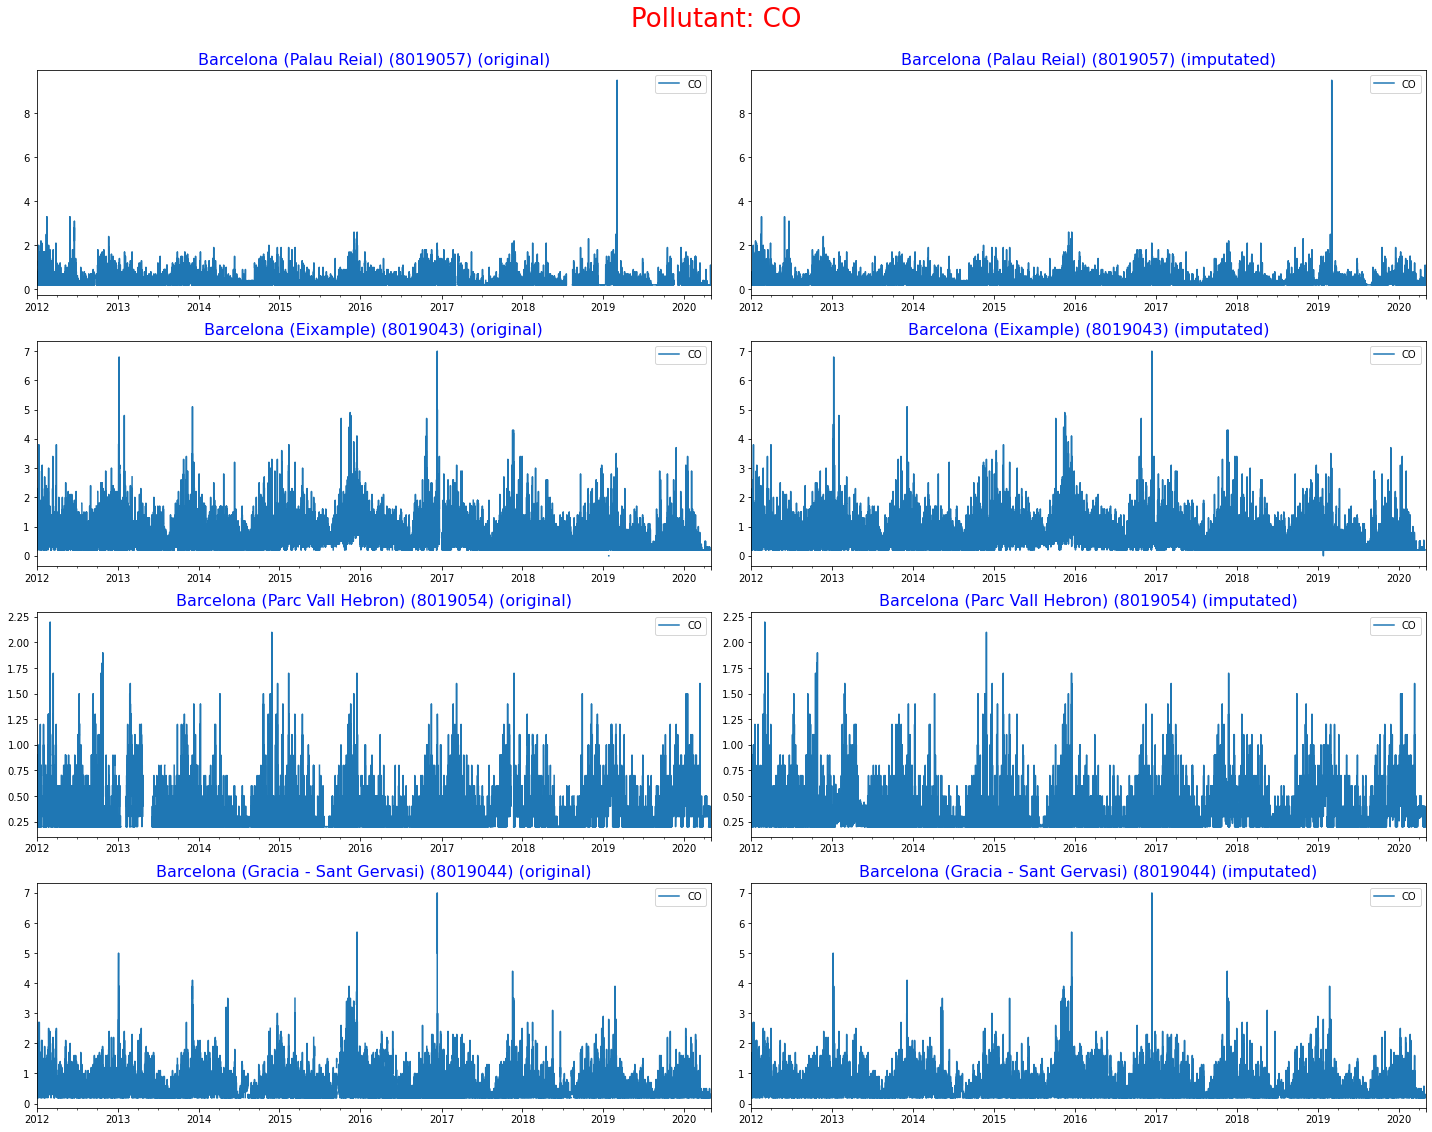

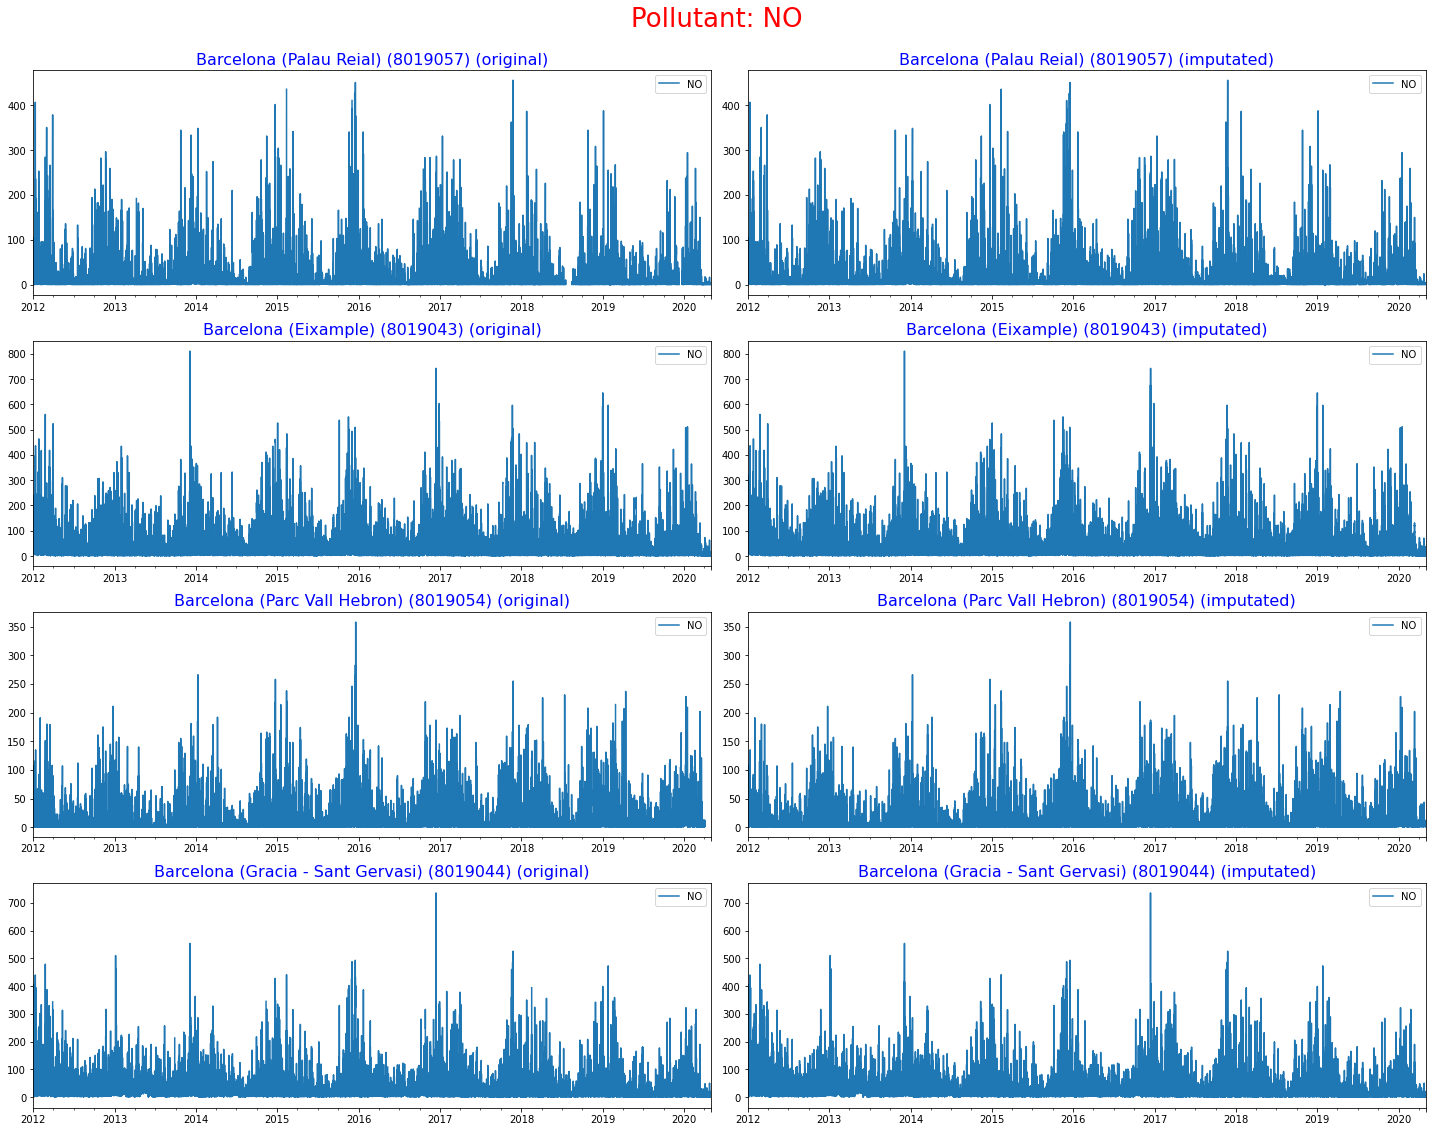

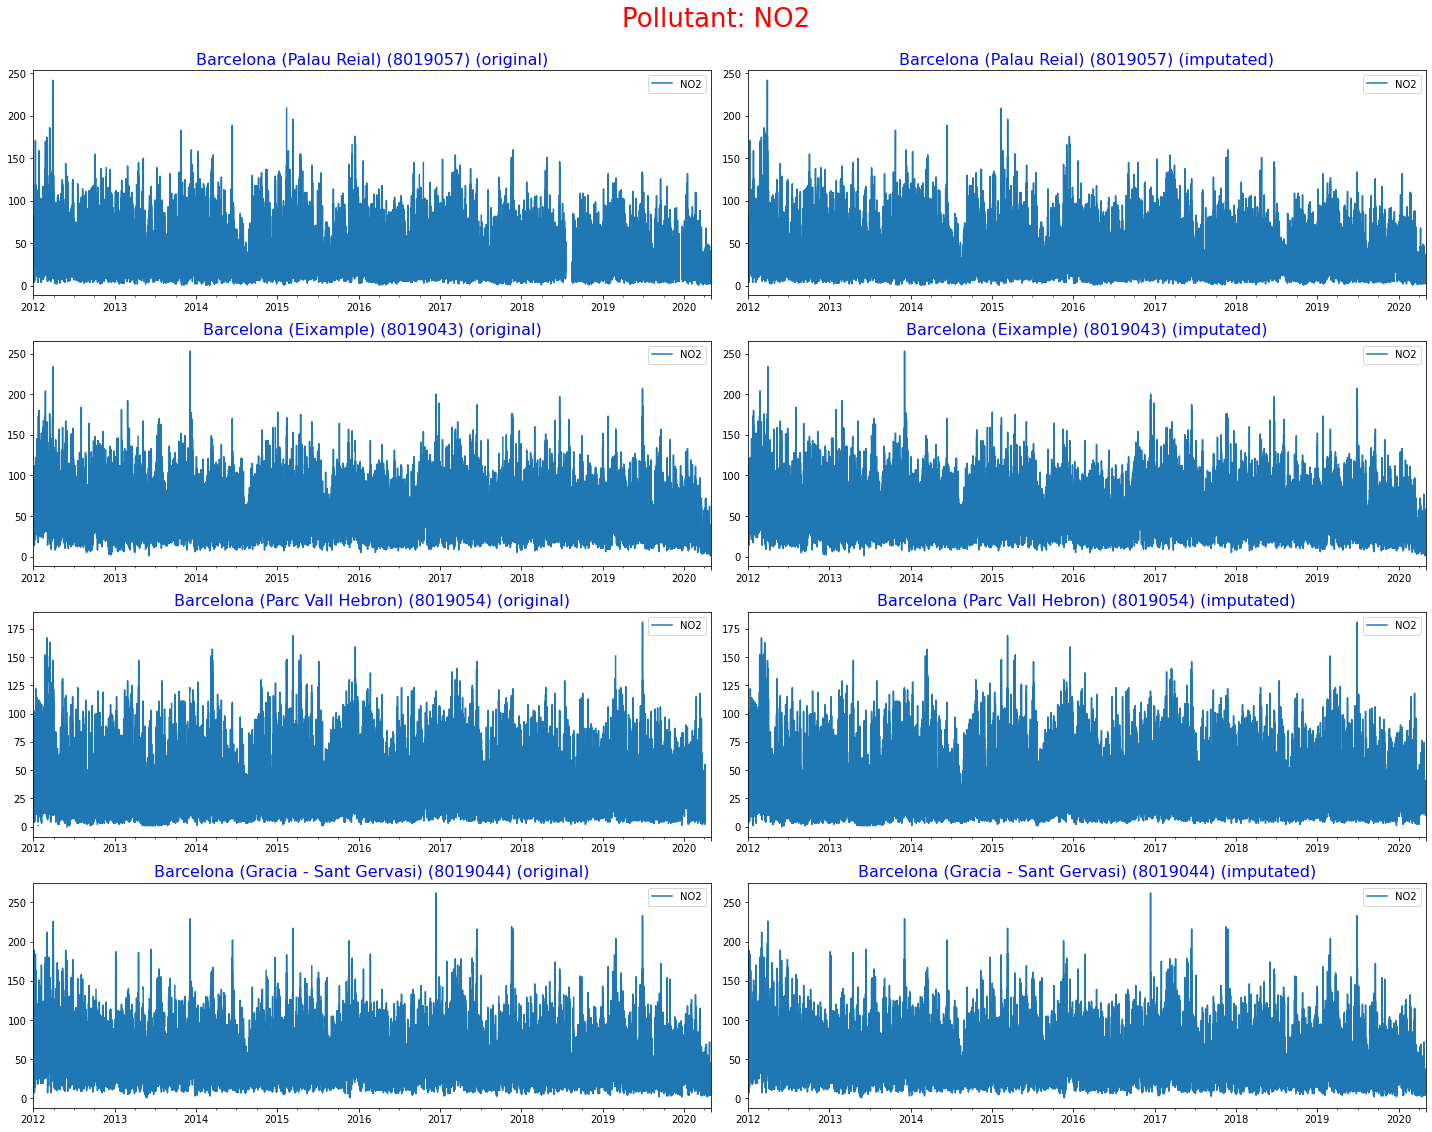

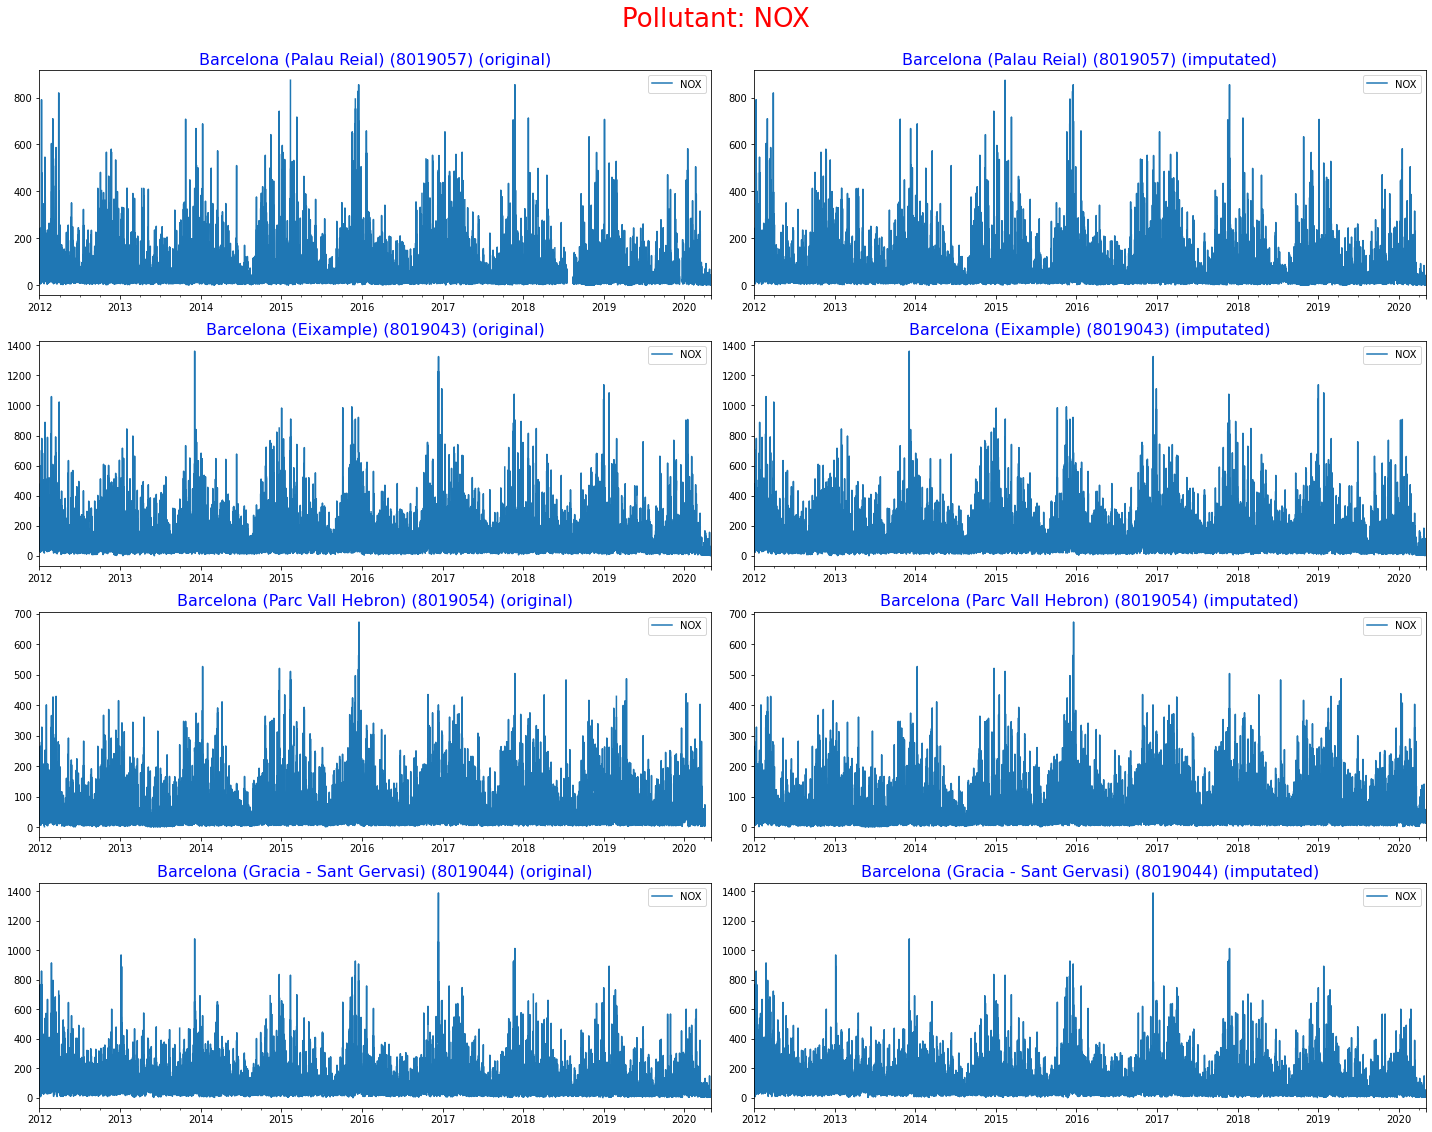

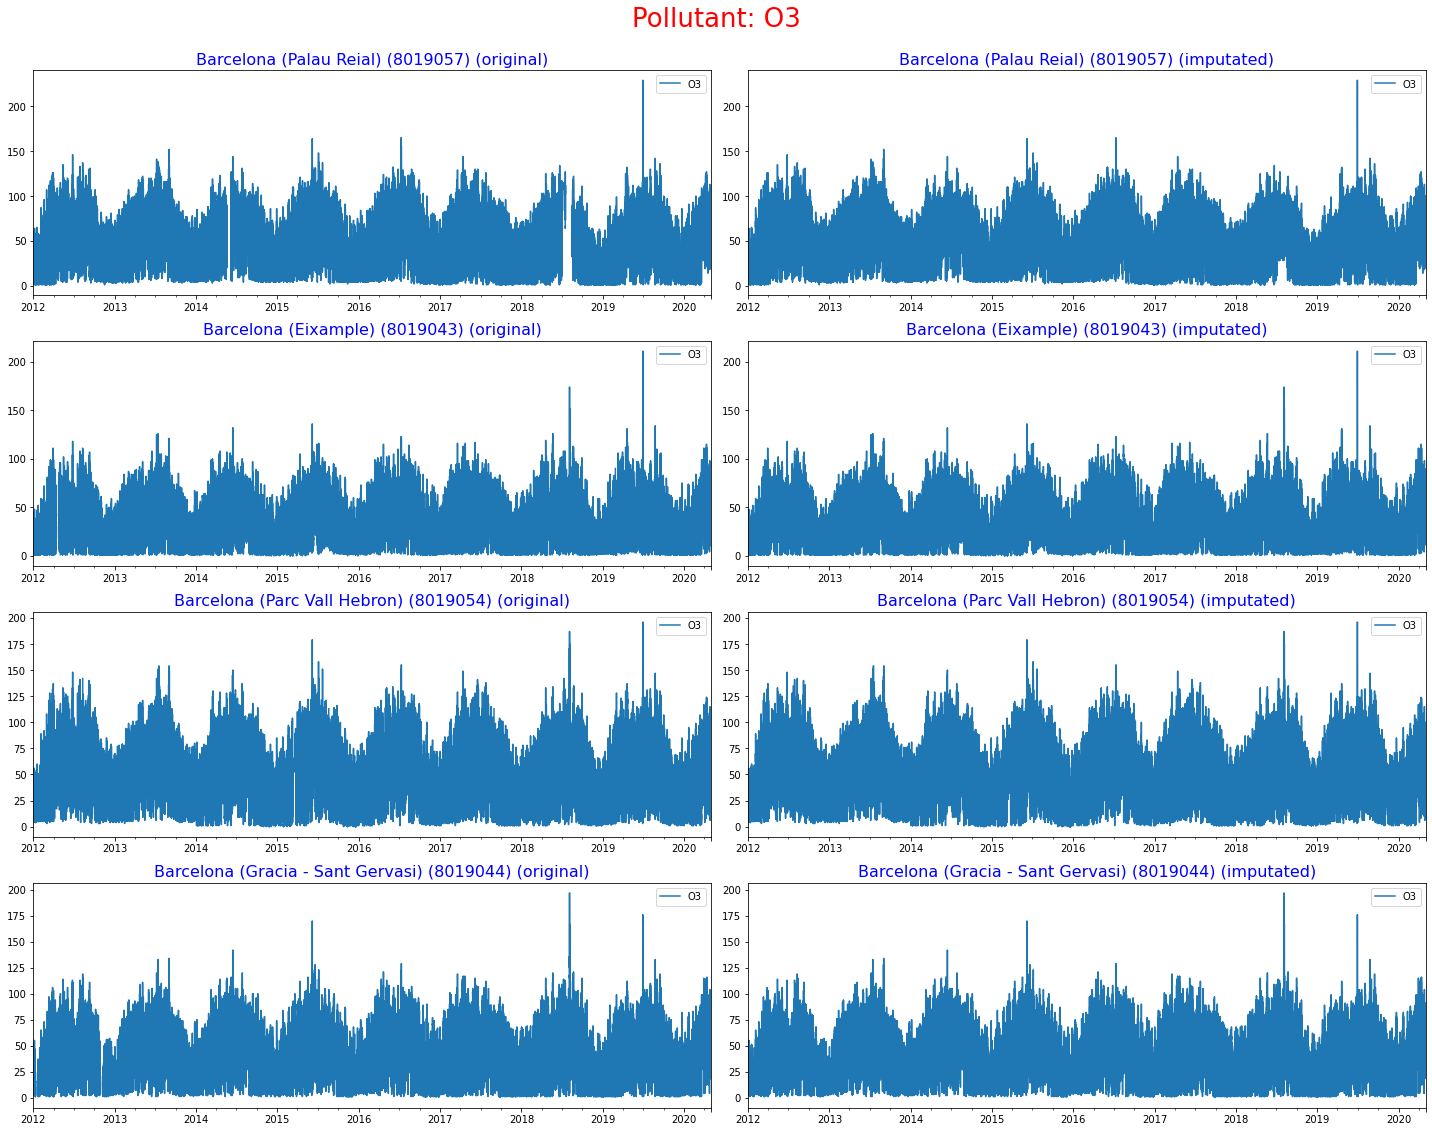

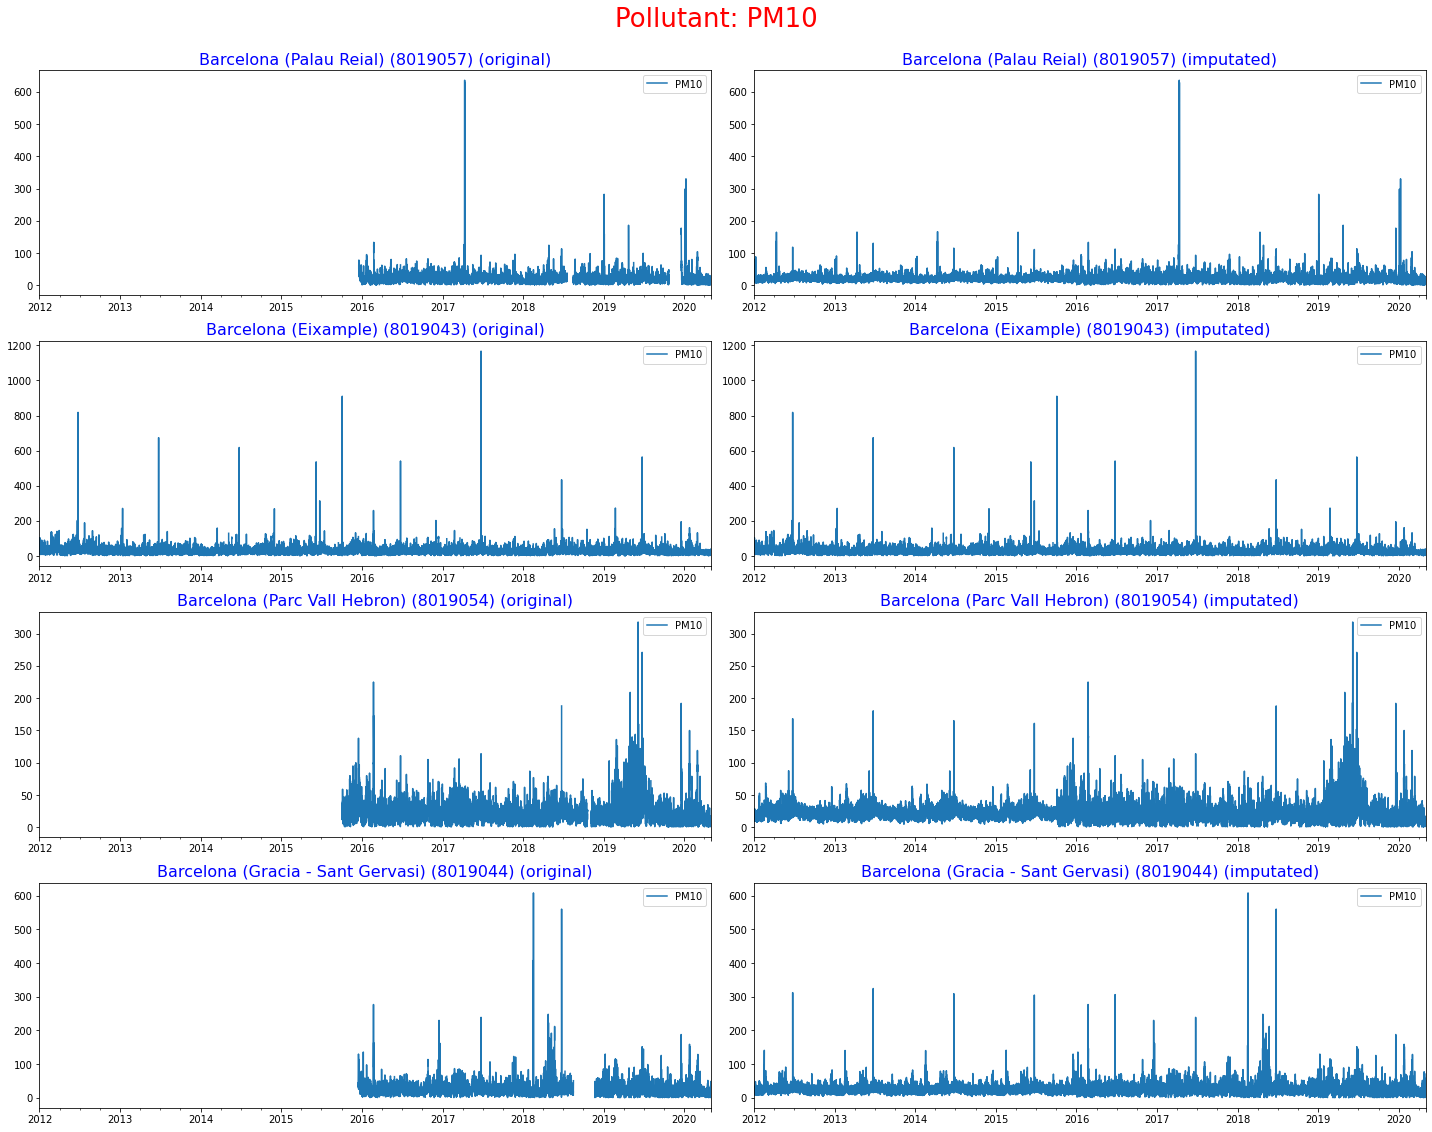

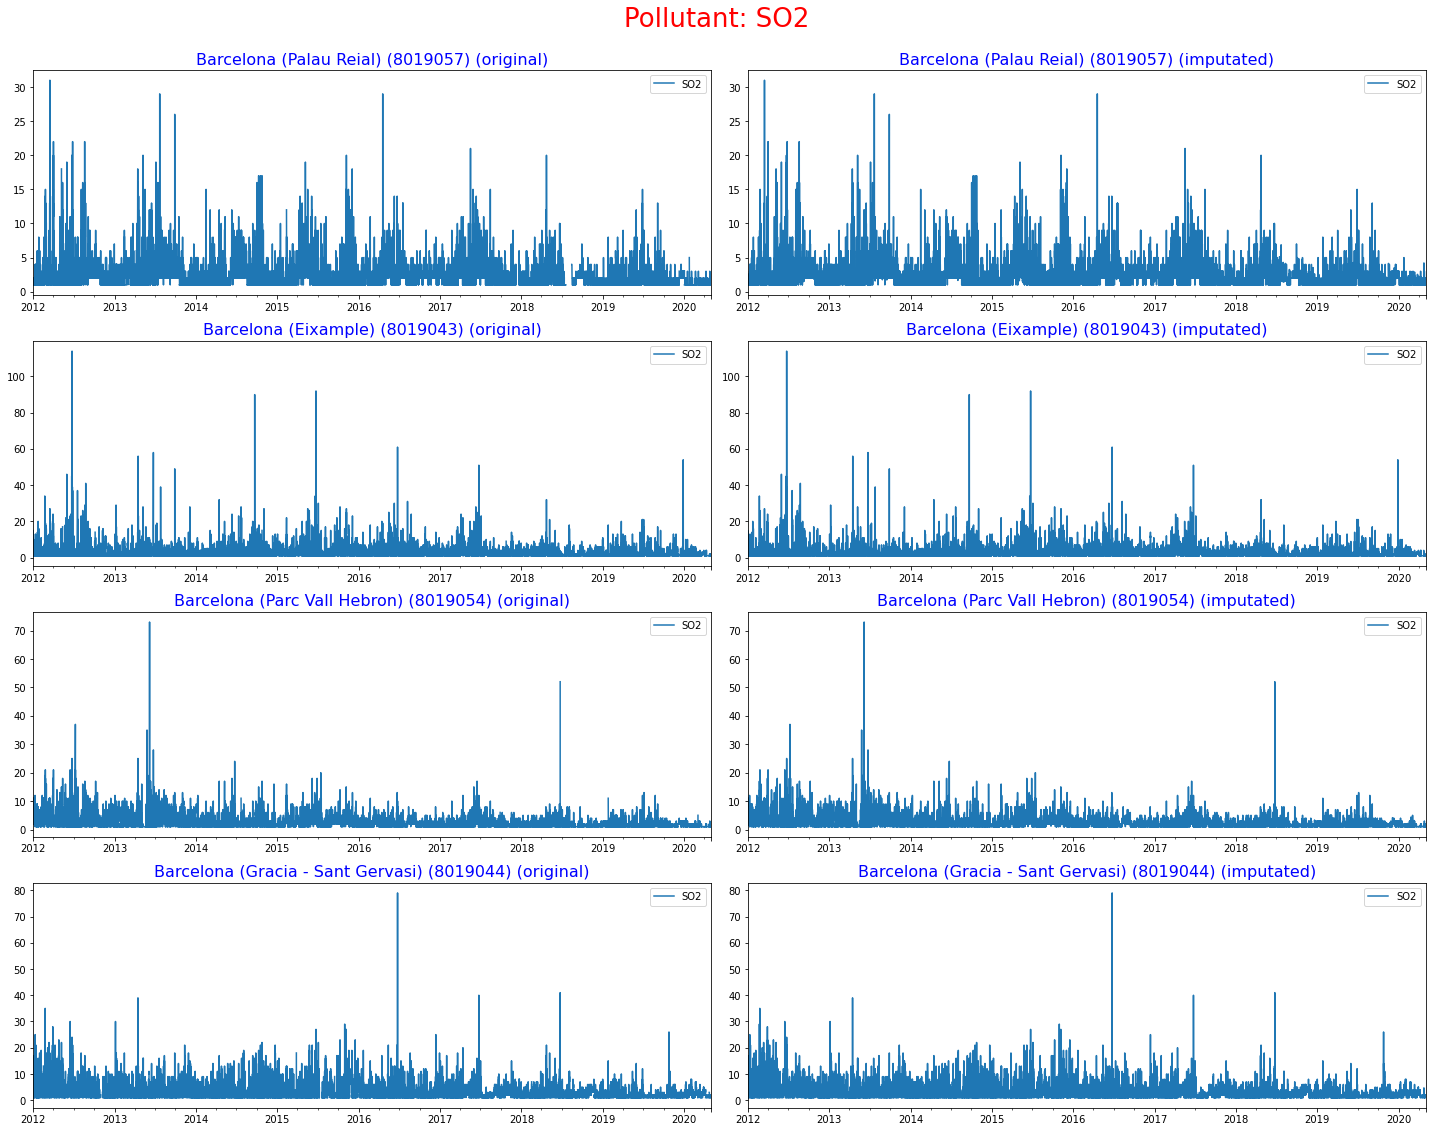

In [ ]:
data_in_1 = data_air_hourly_red
data_in_2 = data_imputated
idStations = data_in_1['CODI_EOI'].unique()
nroItems=len(idStations) * 2
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

idStations=np.append(idStations, [None] * (nroItems % ncols))
variables=np.delete(data_imputated.columns, np.where(np.isin(data_imputated.columns, ['CODI_EOI', 'DATA'])))

for variable in variables:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*10,nrows*4))
    for idx in range(len(idStations)):
        idStation = idStations[idx]
        ax1 = axes[idx, 0]
        ax2 = axes[idx, 1]
        if idStation:            
            nom_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == idStation,'NOM_ESTACIO'].iloc[0]
            title='{} ({})'.format(nom_estacio, int(idStation))
            try:
                data1=data_in_1.loc[(data_in_1["CODI_EOI"] == idStation), ['DATA', variable]].set_index('DATA')   
                if data1.count()[0] > 0:  
                    data1.plot(ax=ax1)     
                    #ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                    ax1.set_title(title + ' (original)', fontsize=16, color='blue')
                    ax1.set_xlabel('')
            except:
                ax1.remove()
            try:
                data2=data_in_2.loc[(data_in_2["CODI_EOI"] == idStation), ['DATA', variable]].set_index('DATA')    
                if data2.count()[0] > 0:  
                    data2.plot(ax=ax2)     
                    #ax.set_ylim(stats[variable]['min'],stats[variable]['max'])
                    ax2.set_title(title + ' (imputated)', fontsize=16, color='blue')
                    ax2.set_xlabel('')
            except:
                ax2.remove()
        else:
            ax1.remove()
            ax2.remove()
        
    plt.suptitle('Pollutant: {}'.format(variable), fontsize=26, color='red')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Si agrupamos los datos para los distintos contaminantes según los días de la semana podremos ver si, en término medio, se produce un mayor aumento en algún día concreto:

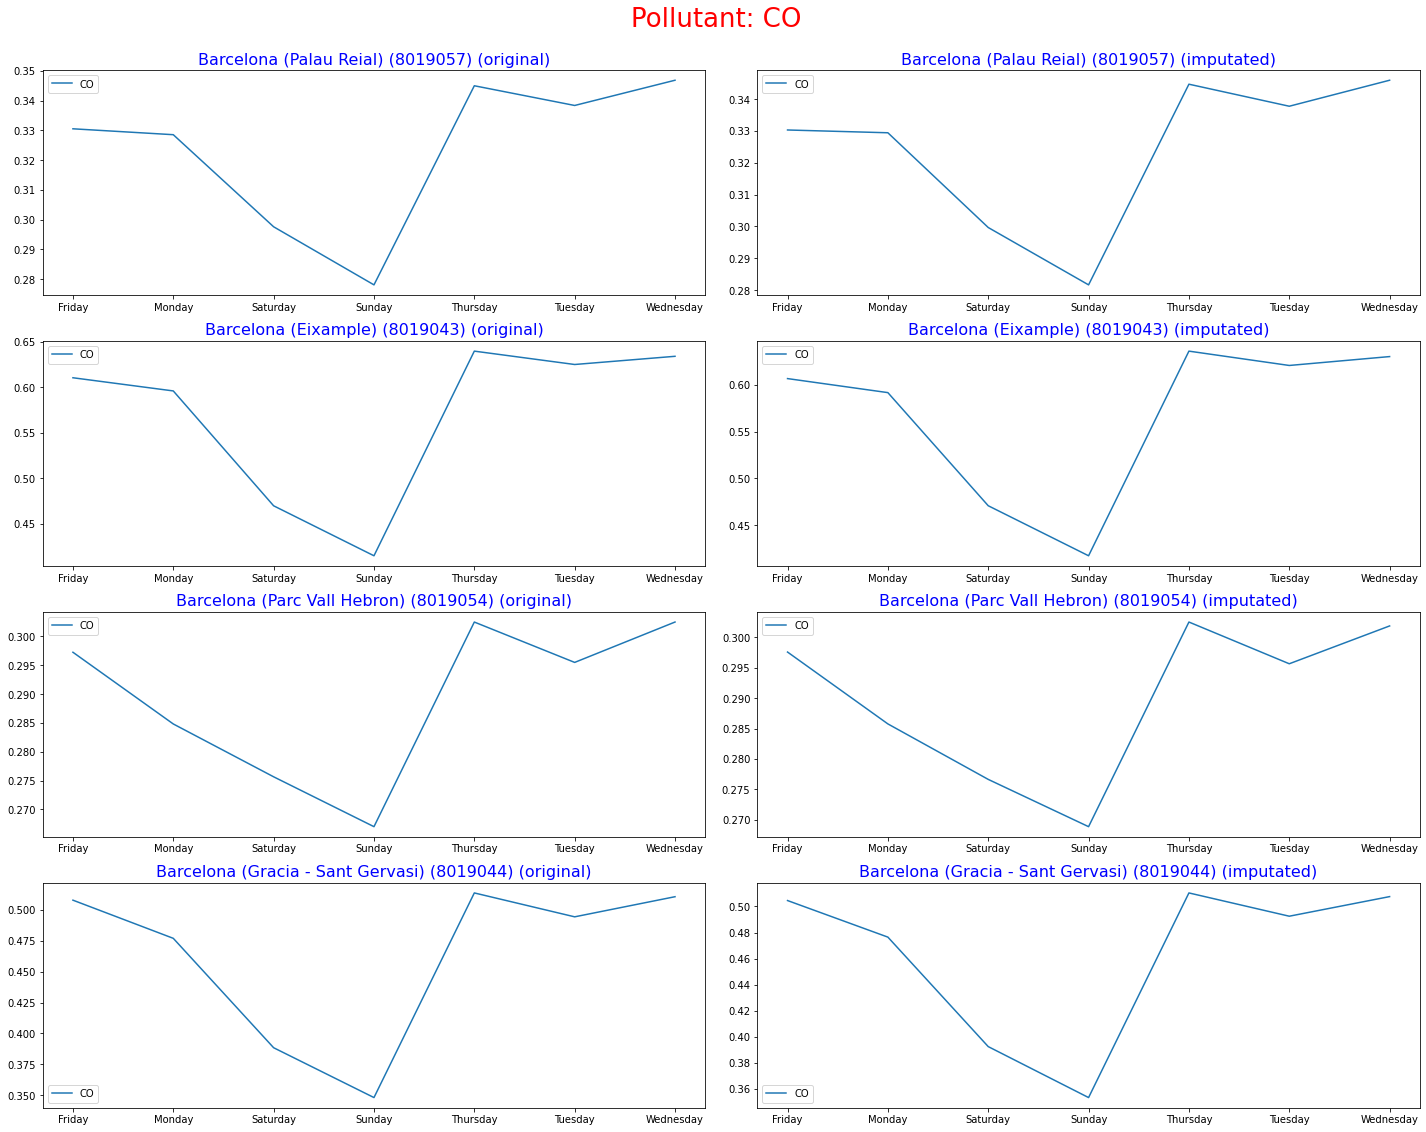

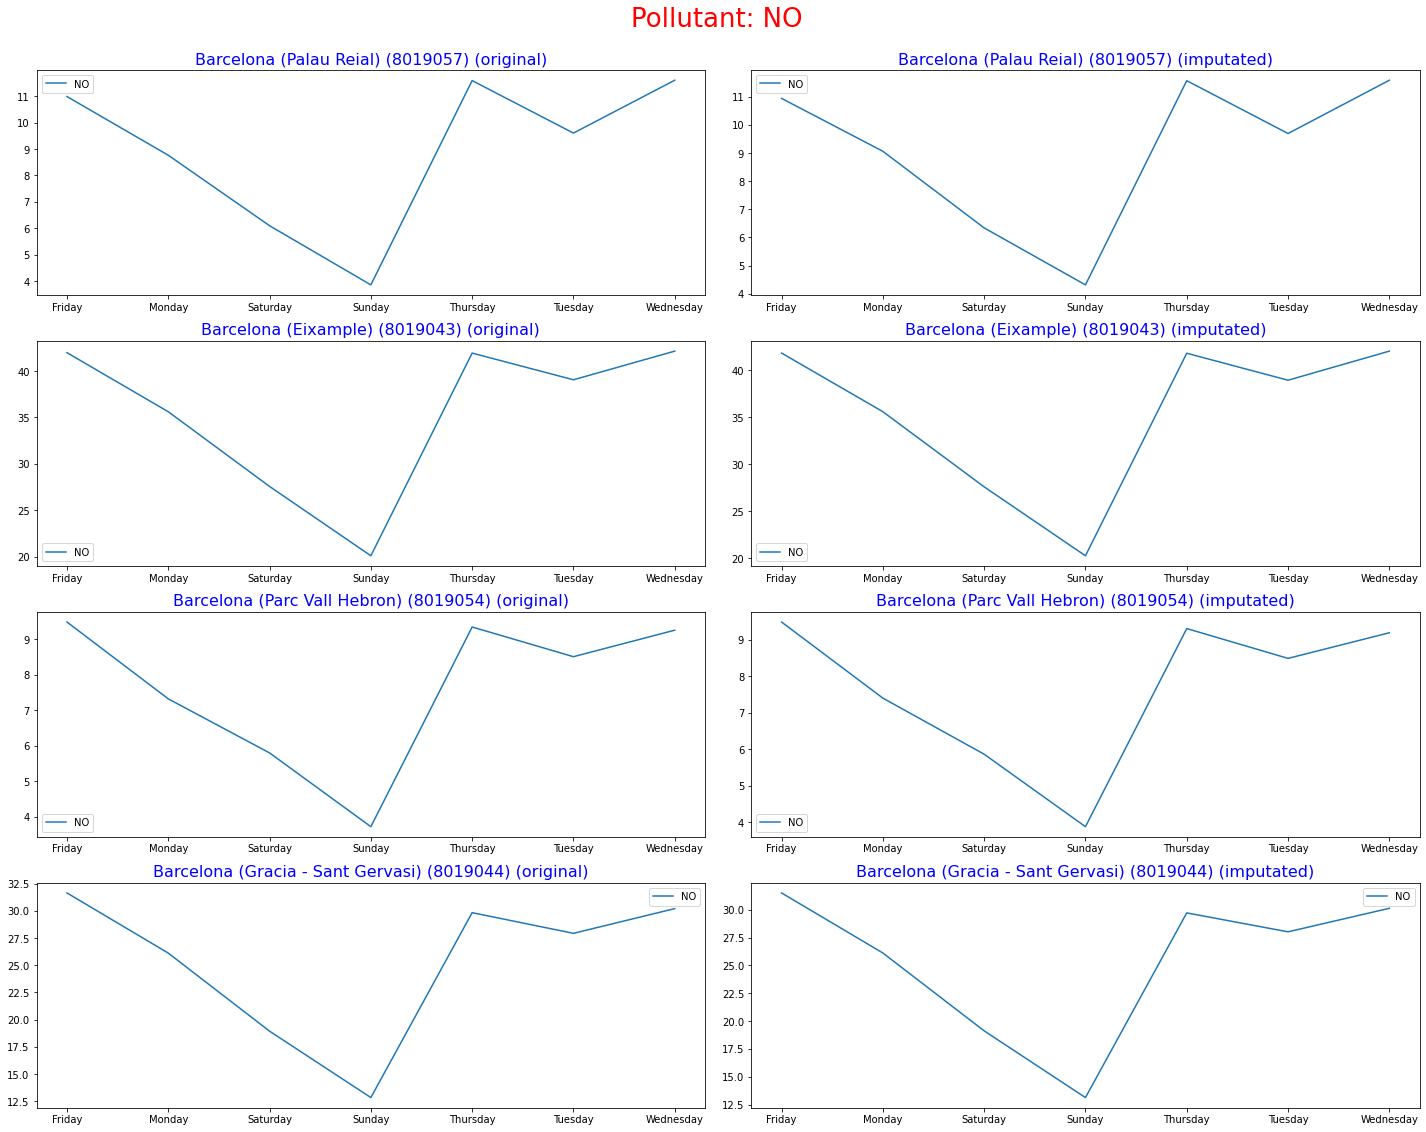

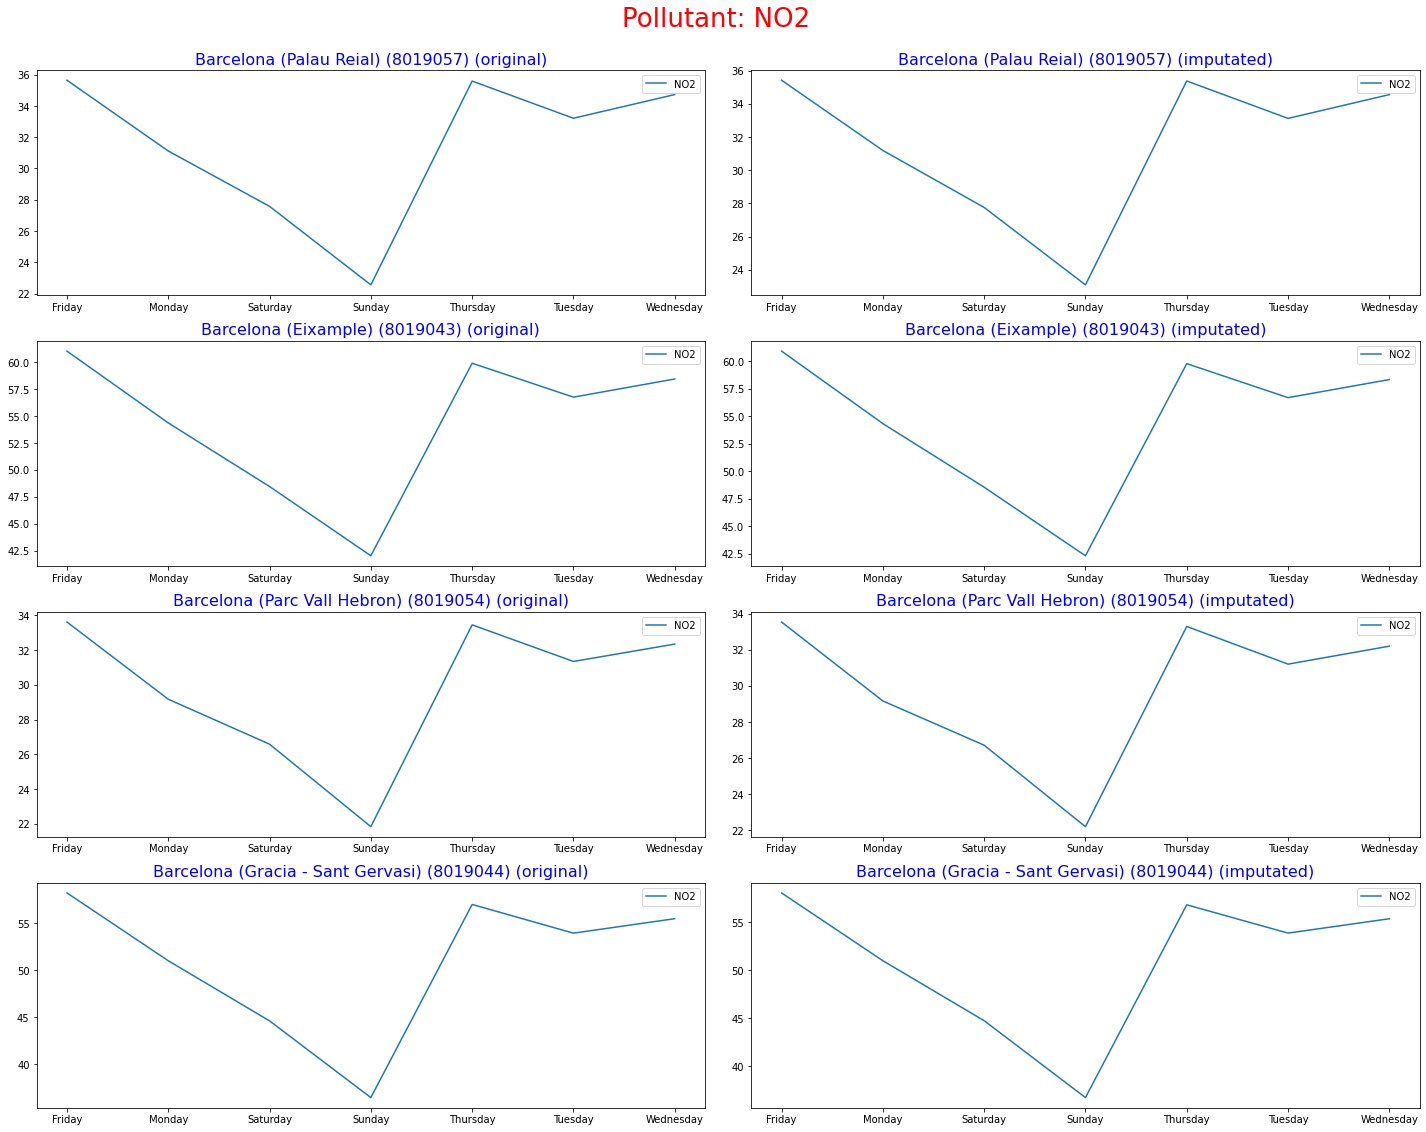

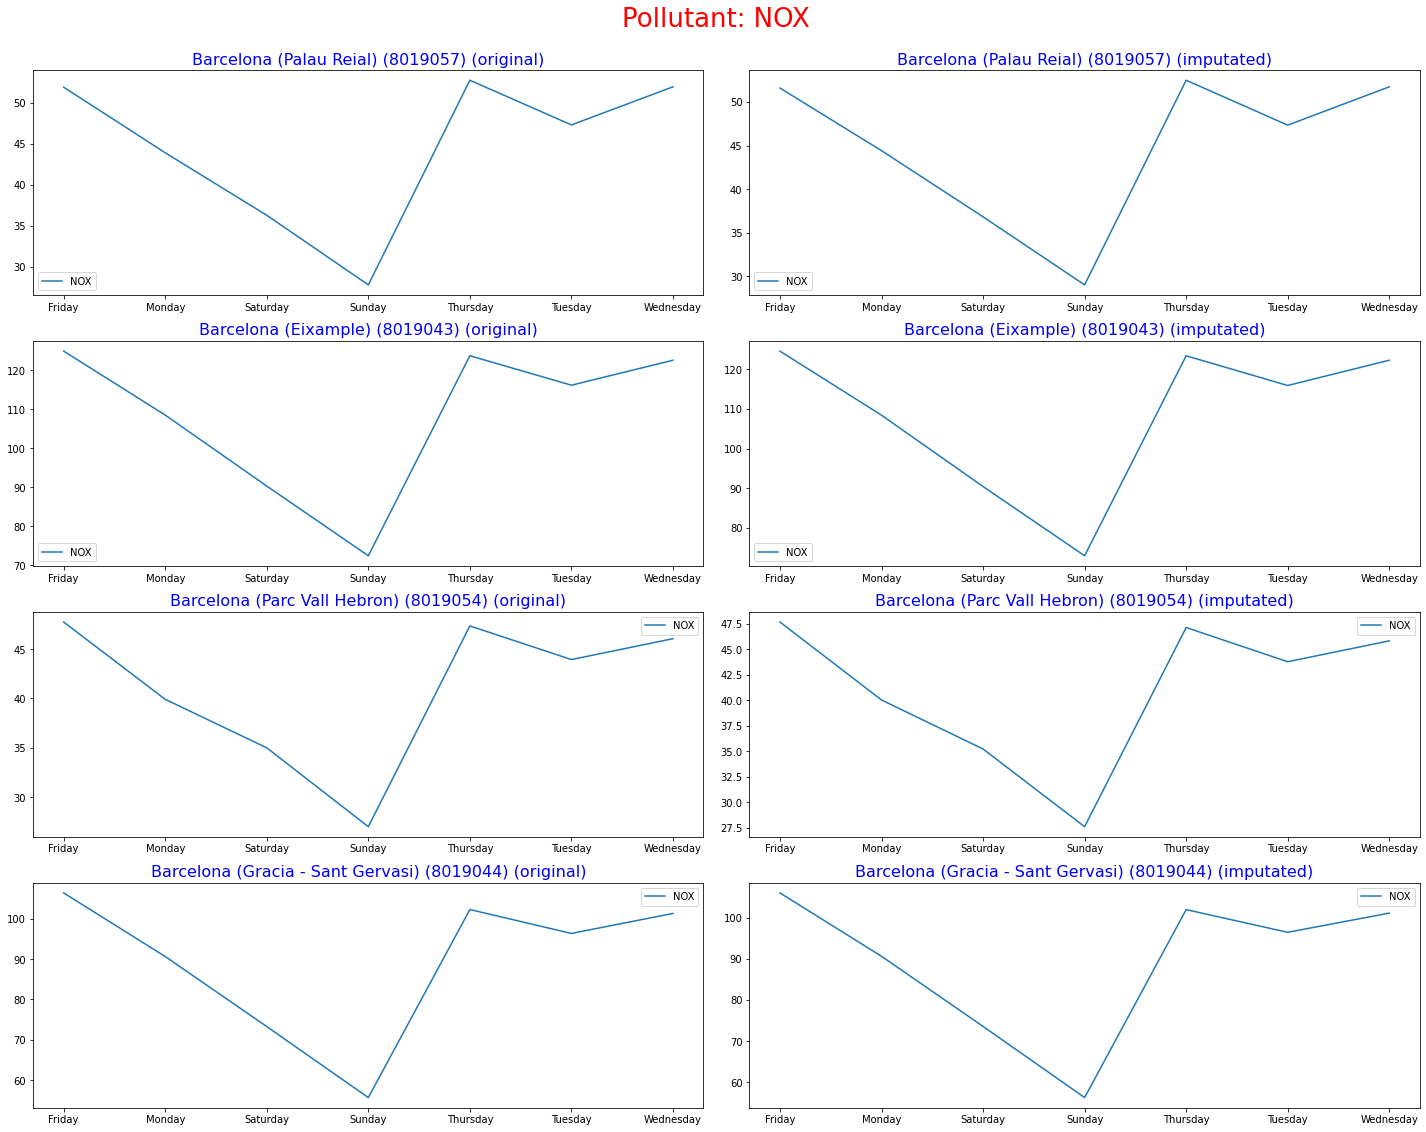

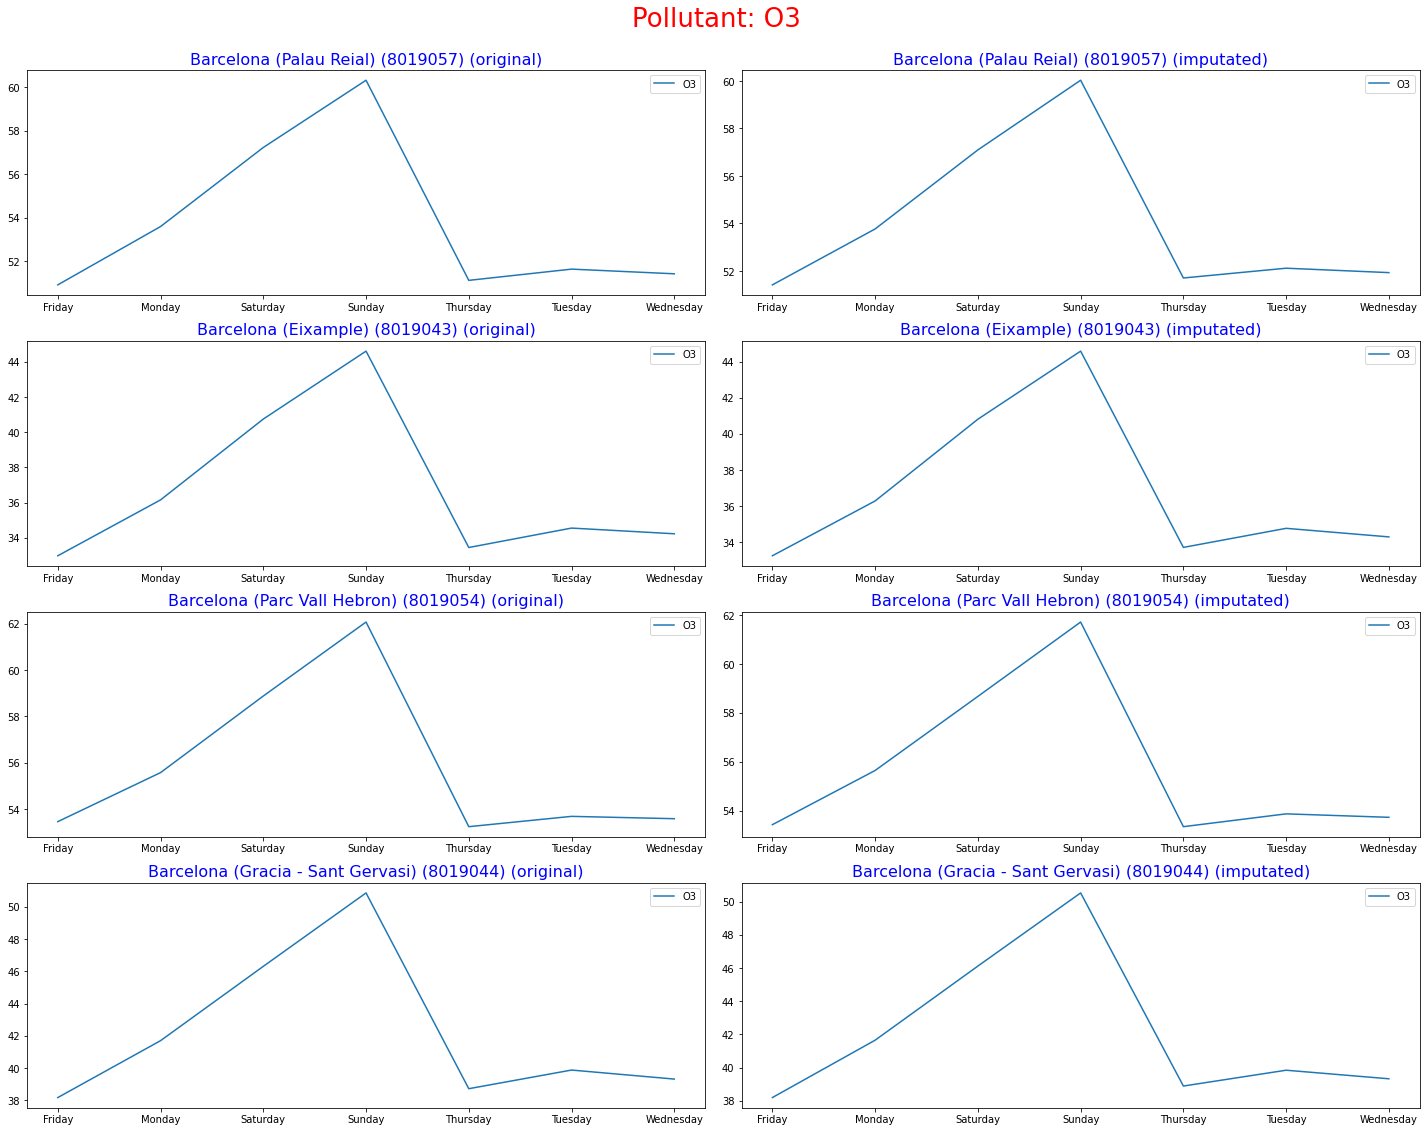

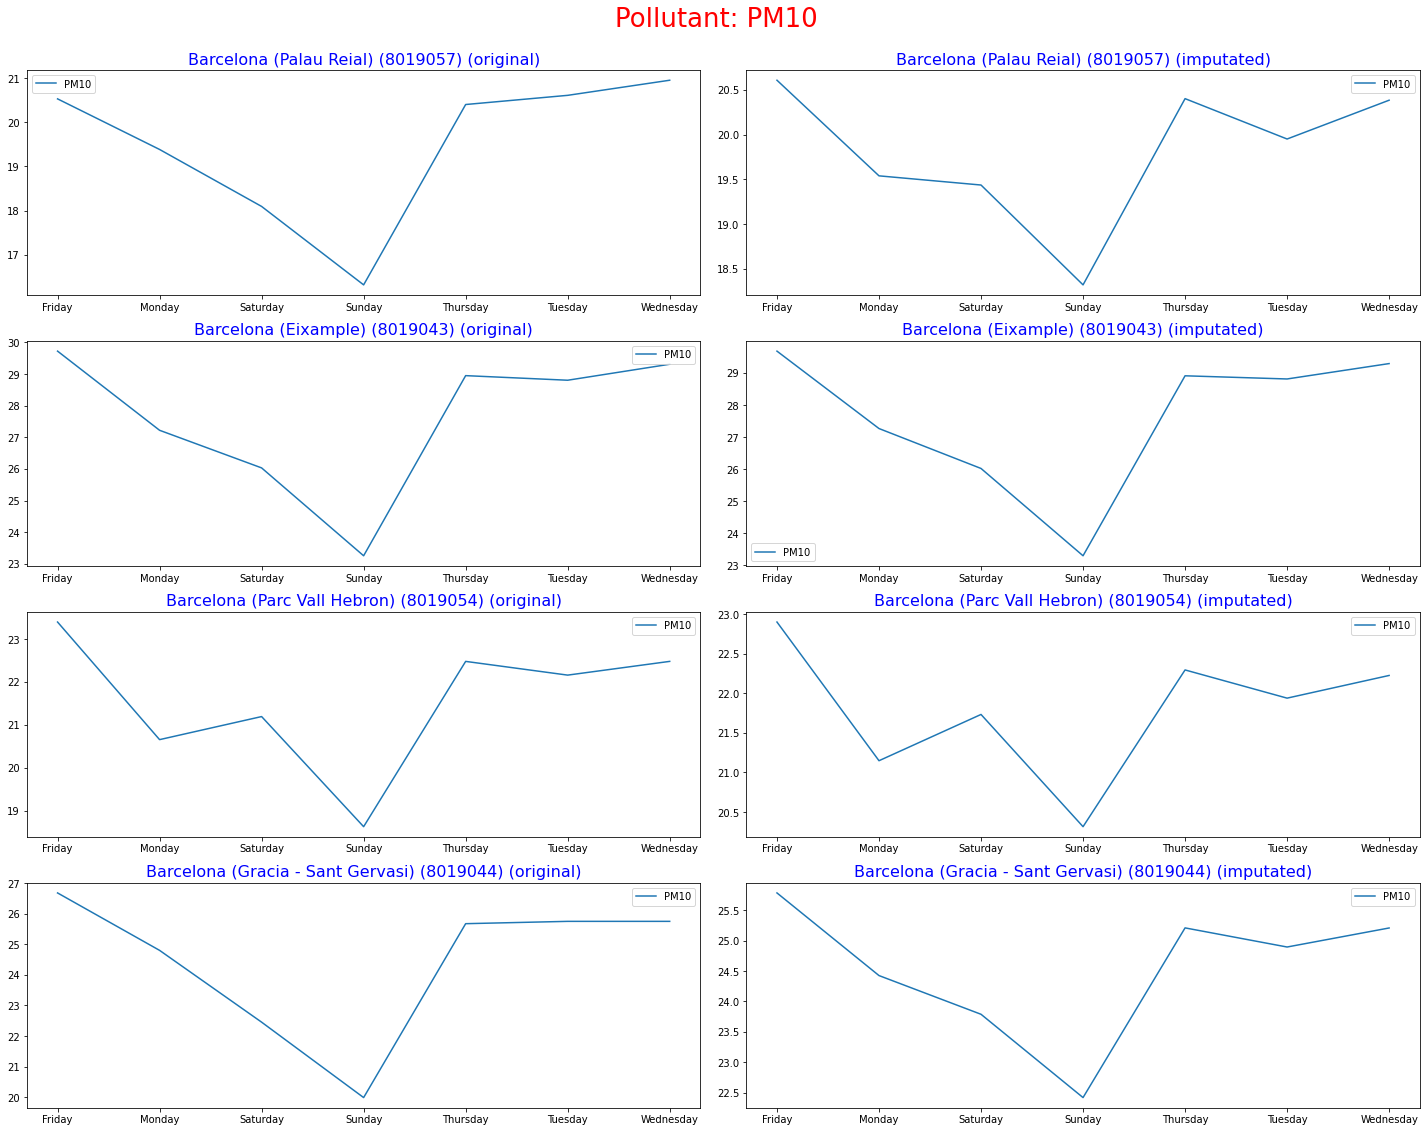

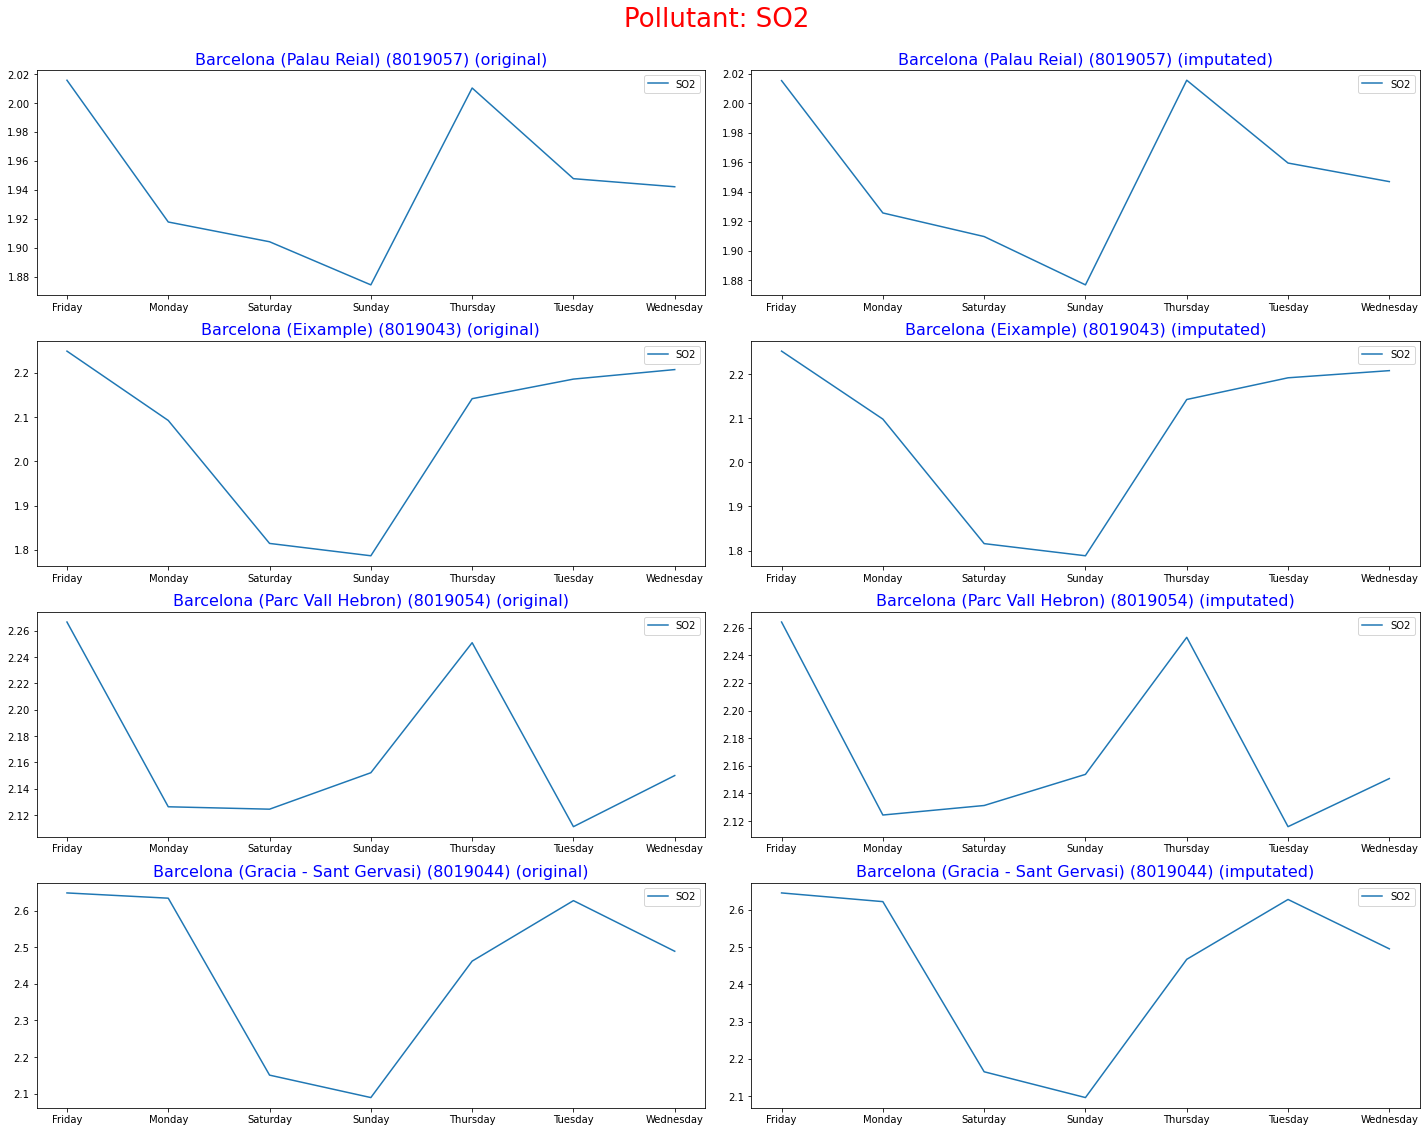

In [ ]:
data_in_1 = data_air_hourly_red
data_in_2 = data_imputated
idStations = data_in_1['CODI_EOI'].unique()
nroItems=len(idStations) * 2
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

idStations=np.append(idStations, [None] * (nroItems % ncols))
variables=np.delete(data_imputated.columns, np.where(np.isin(data_imputated.columns, ['CODI_EOI', 'DATA'])))

for variable in variables:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*10,nrows*4))
    for idx in range(len(idStations)):
        idStation = idStations[idx]
        ax1 = axes[idx, 0]
        ax2 = axes[idx, 1]
        if idStation:            
            nom_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == idStation,'NOM_ESTACIO'].iloc[0]
            title='{} ({})'.format(nom_estacio, int(idStation))
            try:
                data1=data_in_1.loc[(data_in_1["CODI_EOI"] == idStation), ['DATA', variable]].set_index('DATA')
                data1=data1.groupby(data1.index.day_name()).mean()
                if data1.count()[0] > 0:  
                    data1.plot(ax=ax1)     
                    ax1.set_title(title + ' (original)', fontsize=16, color='blue')
                    ax1.set_xlabel('')
            except:
                ax1.remove()
            try:
                data2=data_in_2.loc[(data_in_2["CODI_EOI"] == idStation), ['DATA', variable]].set_index('DATA')
                data2=data2.groupby(data2.index.day_name()).mean()    
                if data2.count()[0] > 0:  
                    data2.plot(ax=ax2)     
                    ax2.set_title(title + ' (imputated)', fontsize=16, color='blue')
                    ax2.set_xlabel('')
            except:
                ax2.remove()
        else:
            ax1.remove()
            ax2.remove()
        
    plt.suptitle('Pollutant: {}'.format(variable), fontsize=26, color='red')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Vemos como se observa distinción entre los días del fin de semana, sábado y domingo, y el resto de la semana. Seguramente influenciado por la jornada laboral.

Si mostramos ahora los datos agrupados mensualmente:

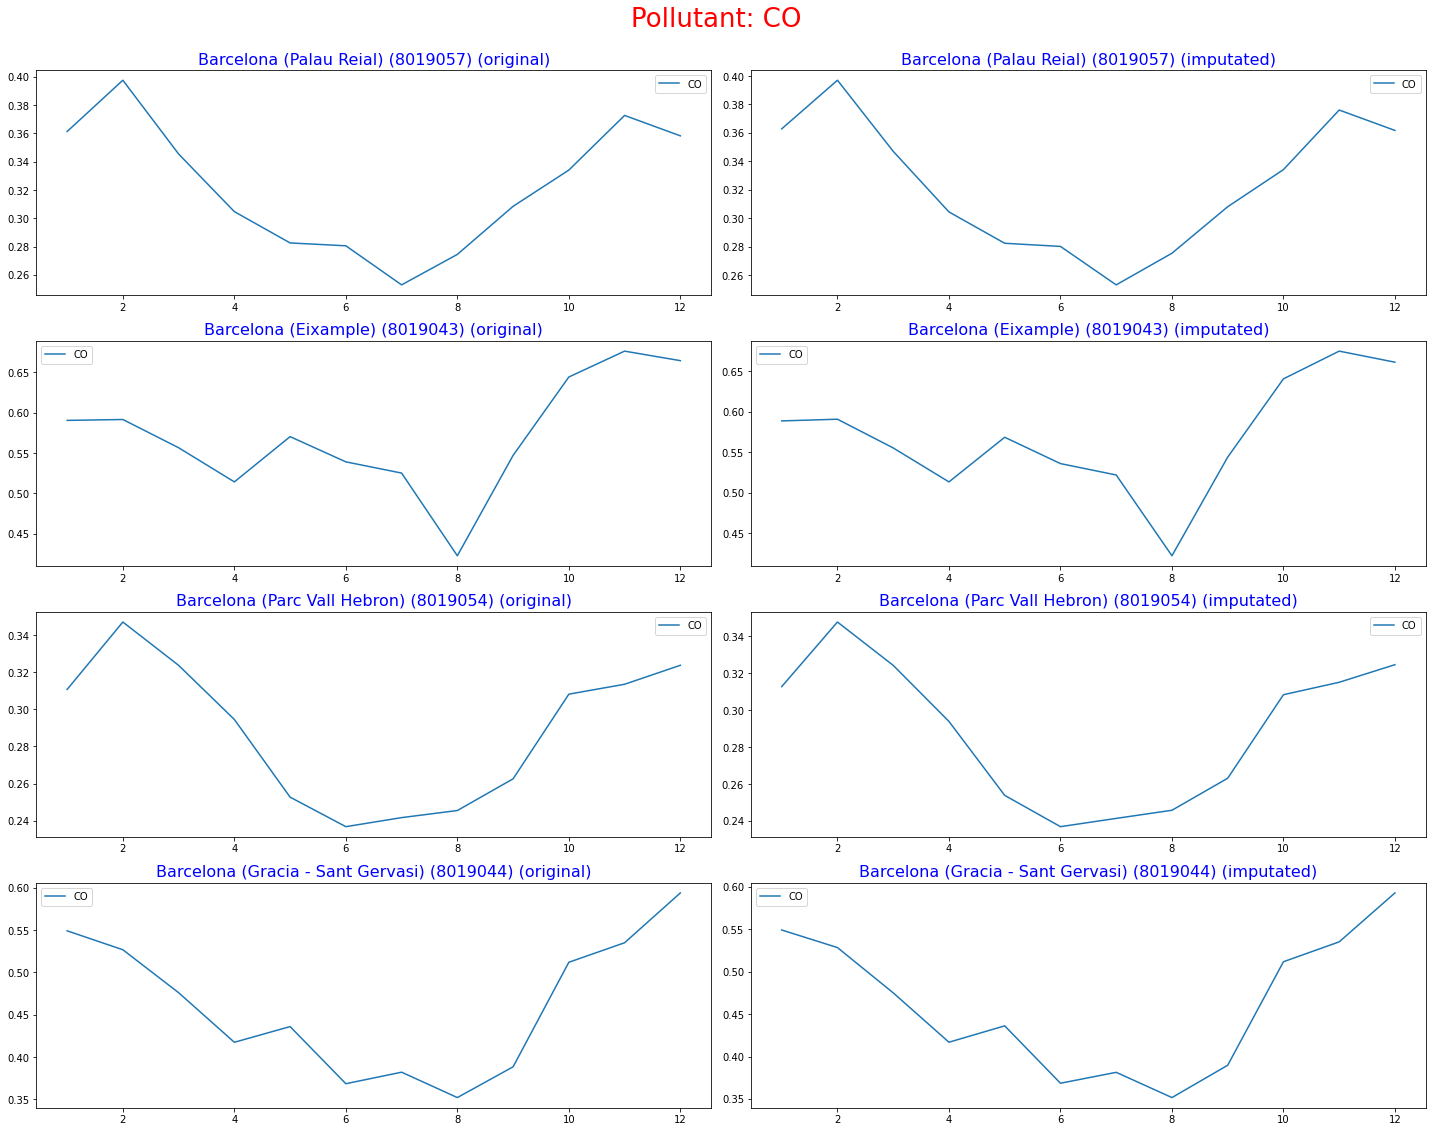

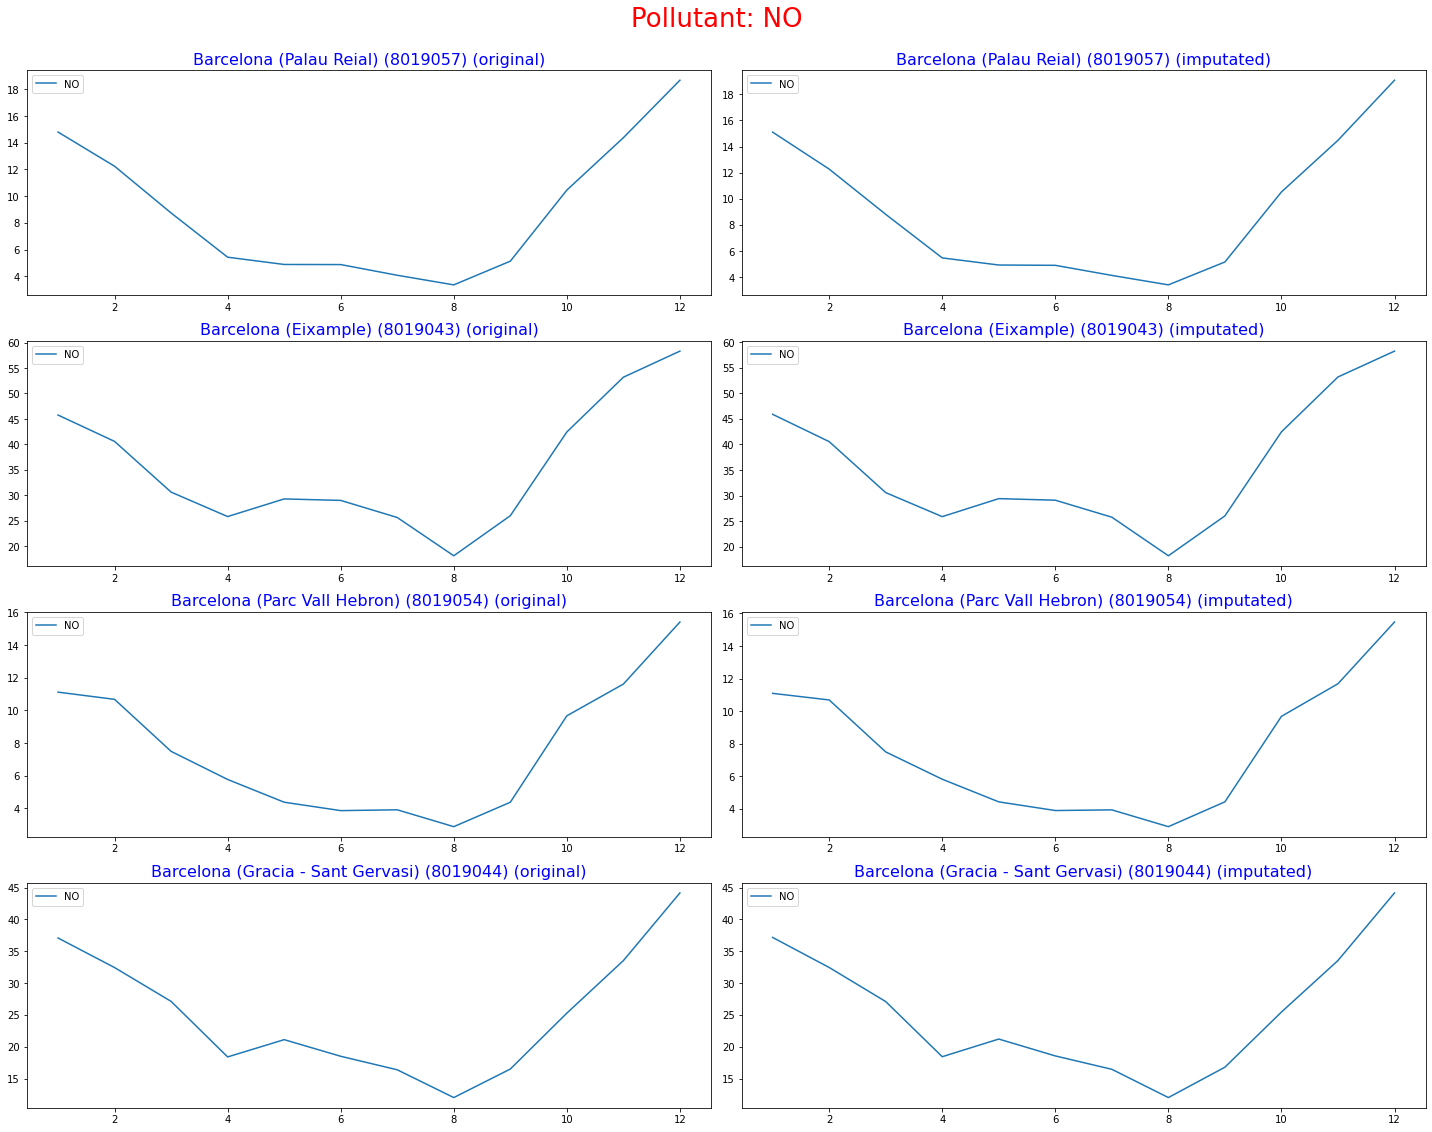

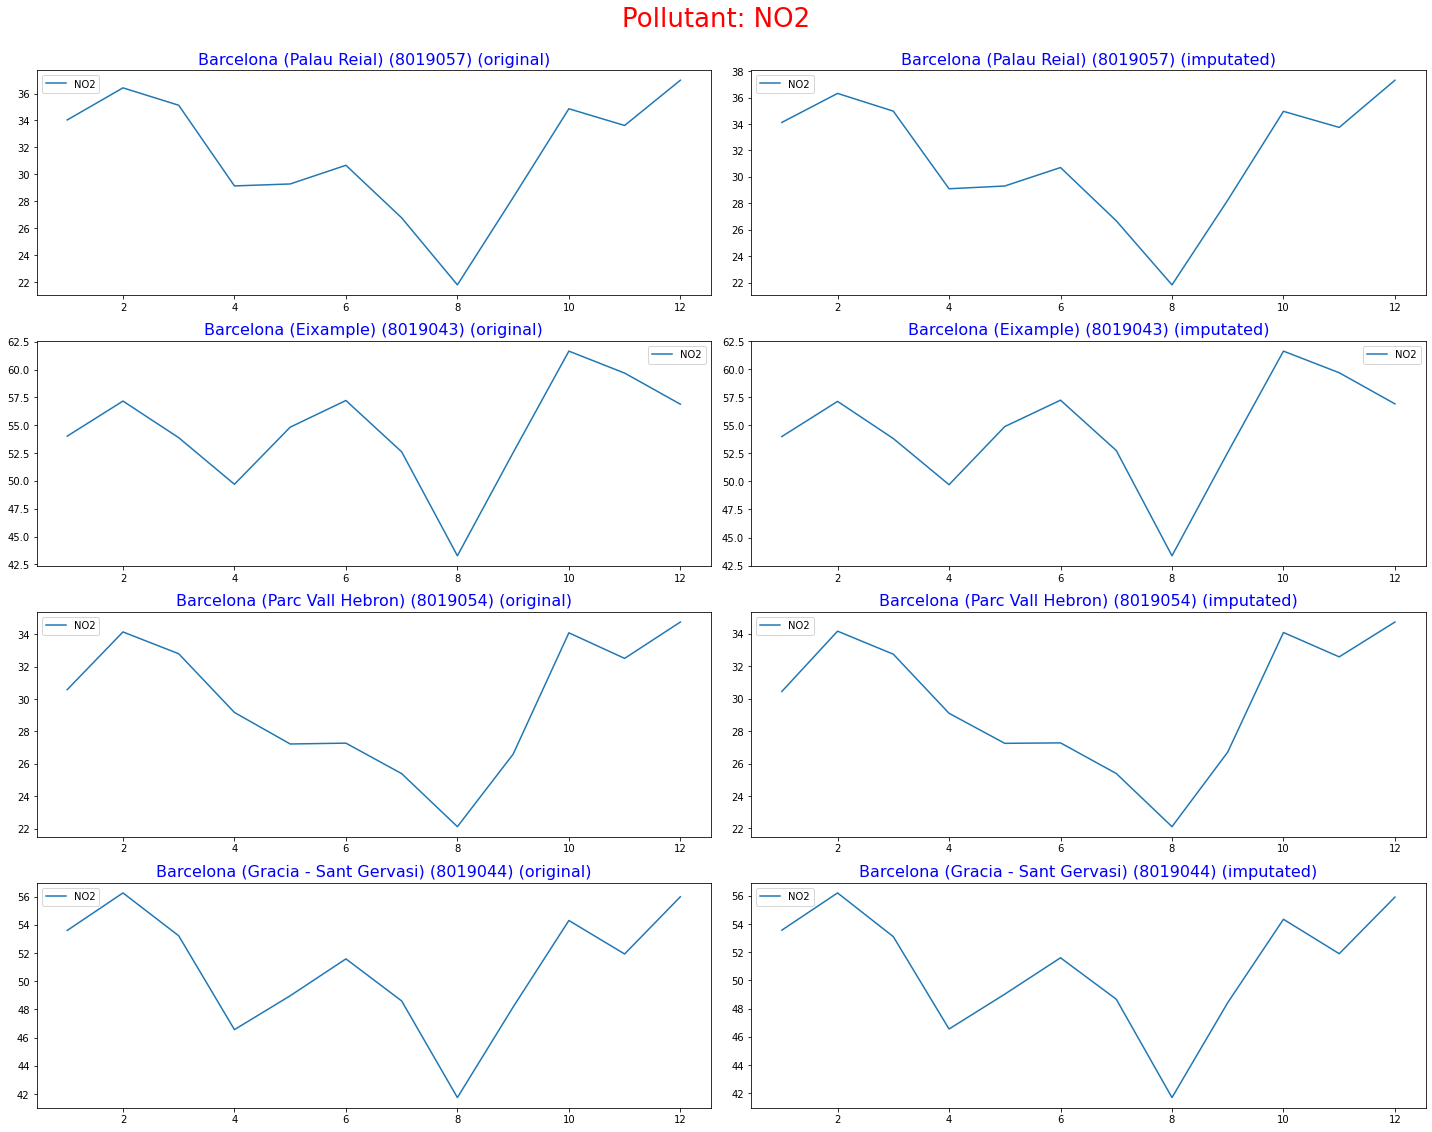

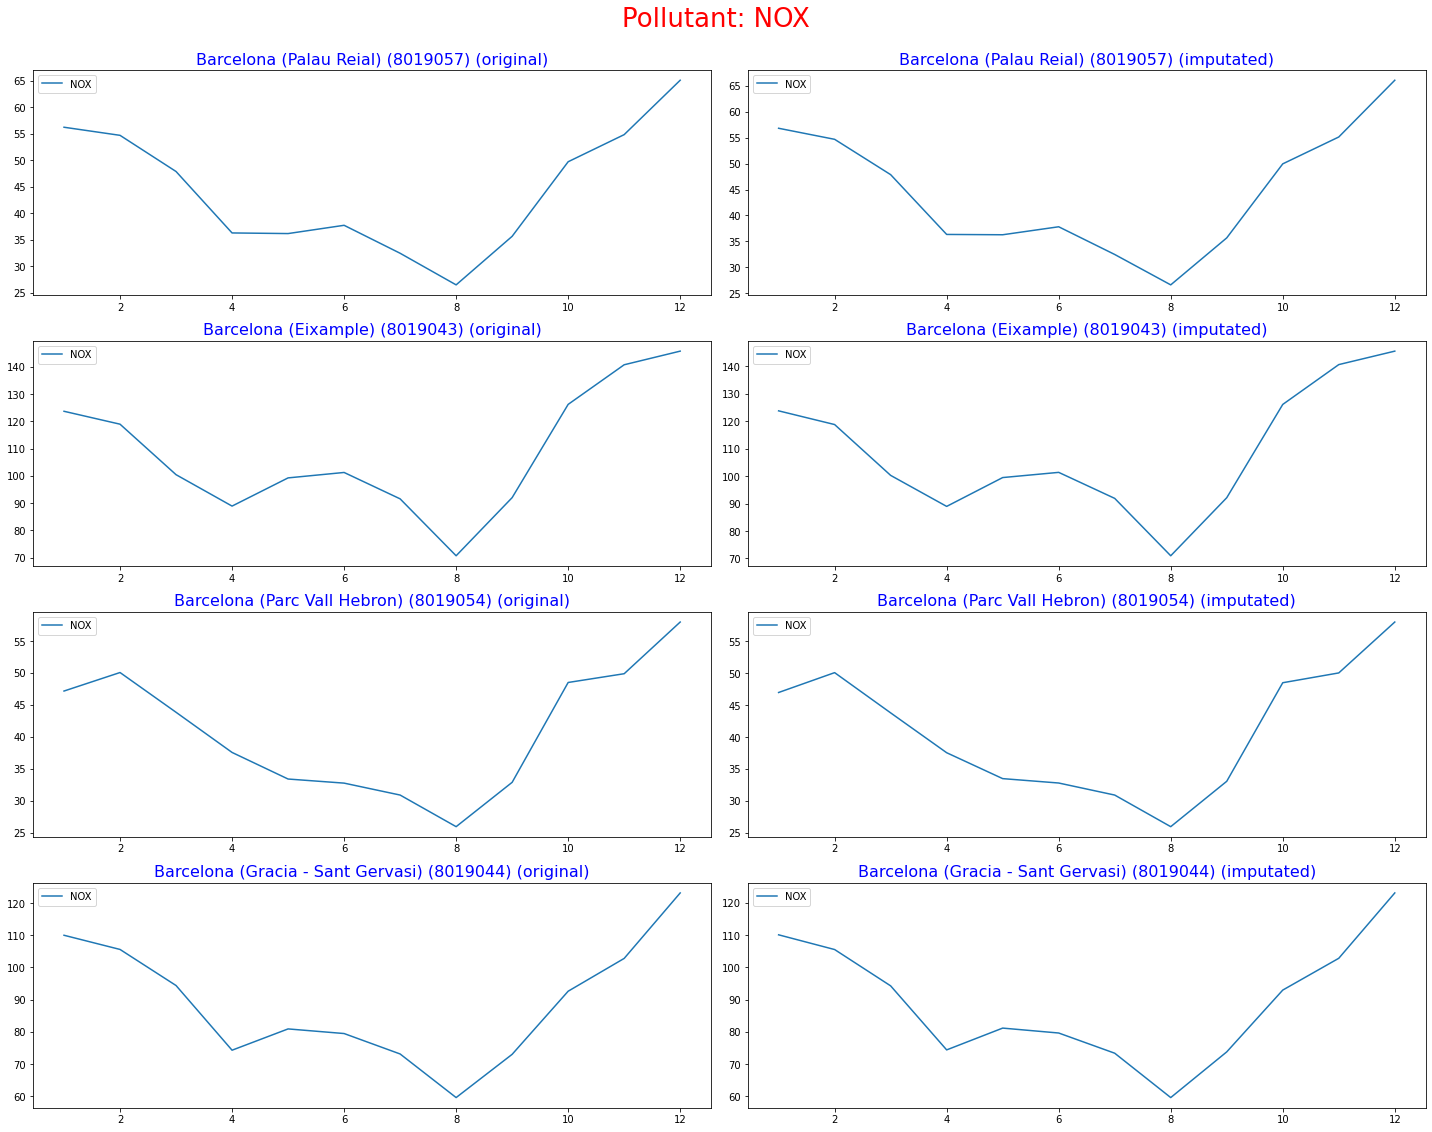

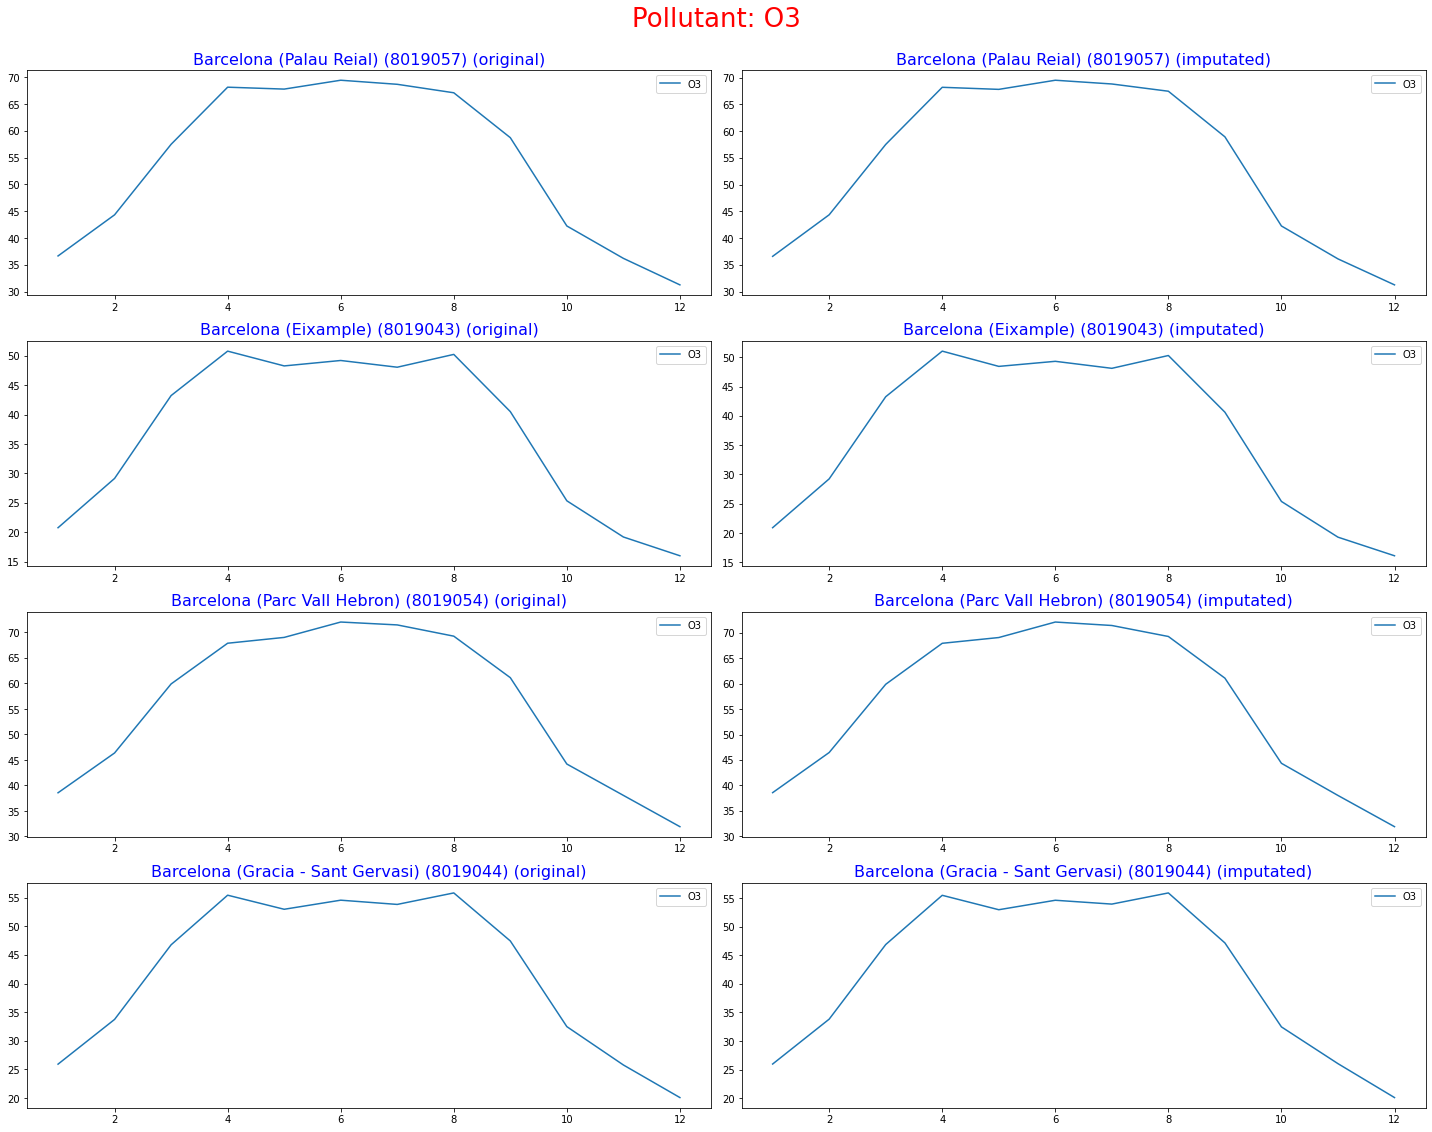

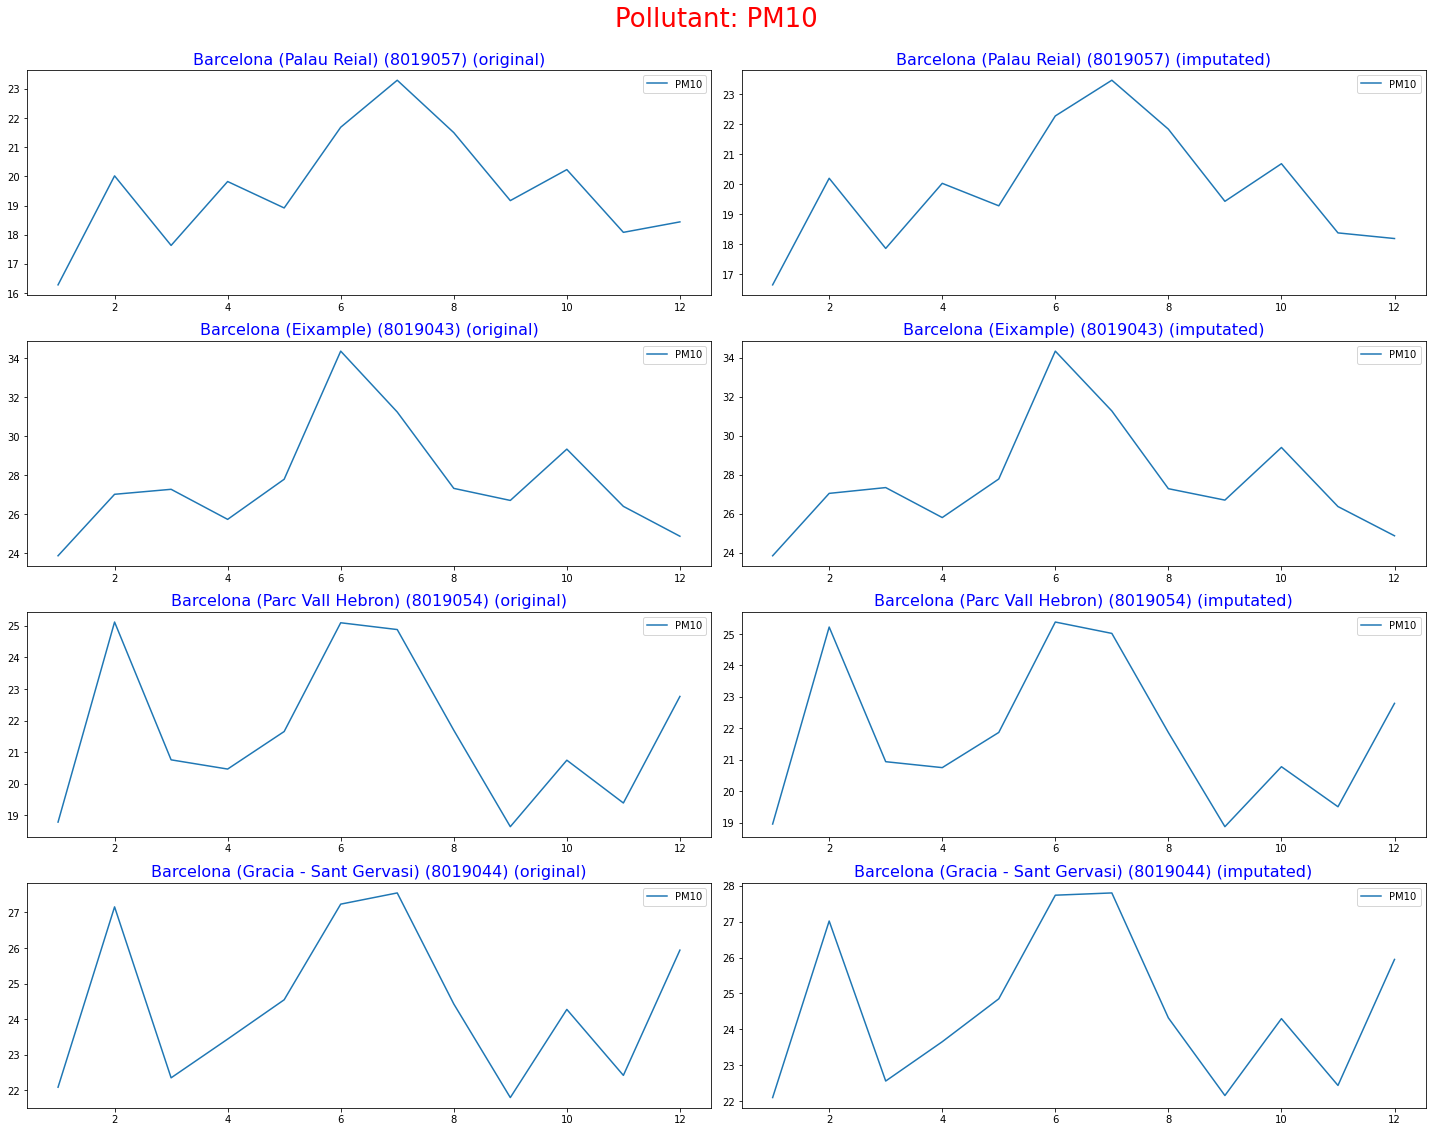

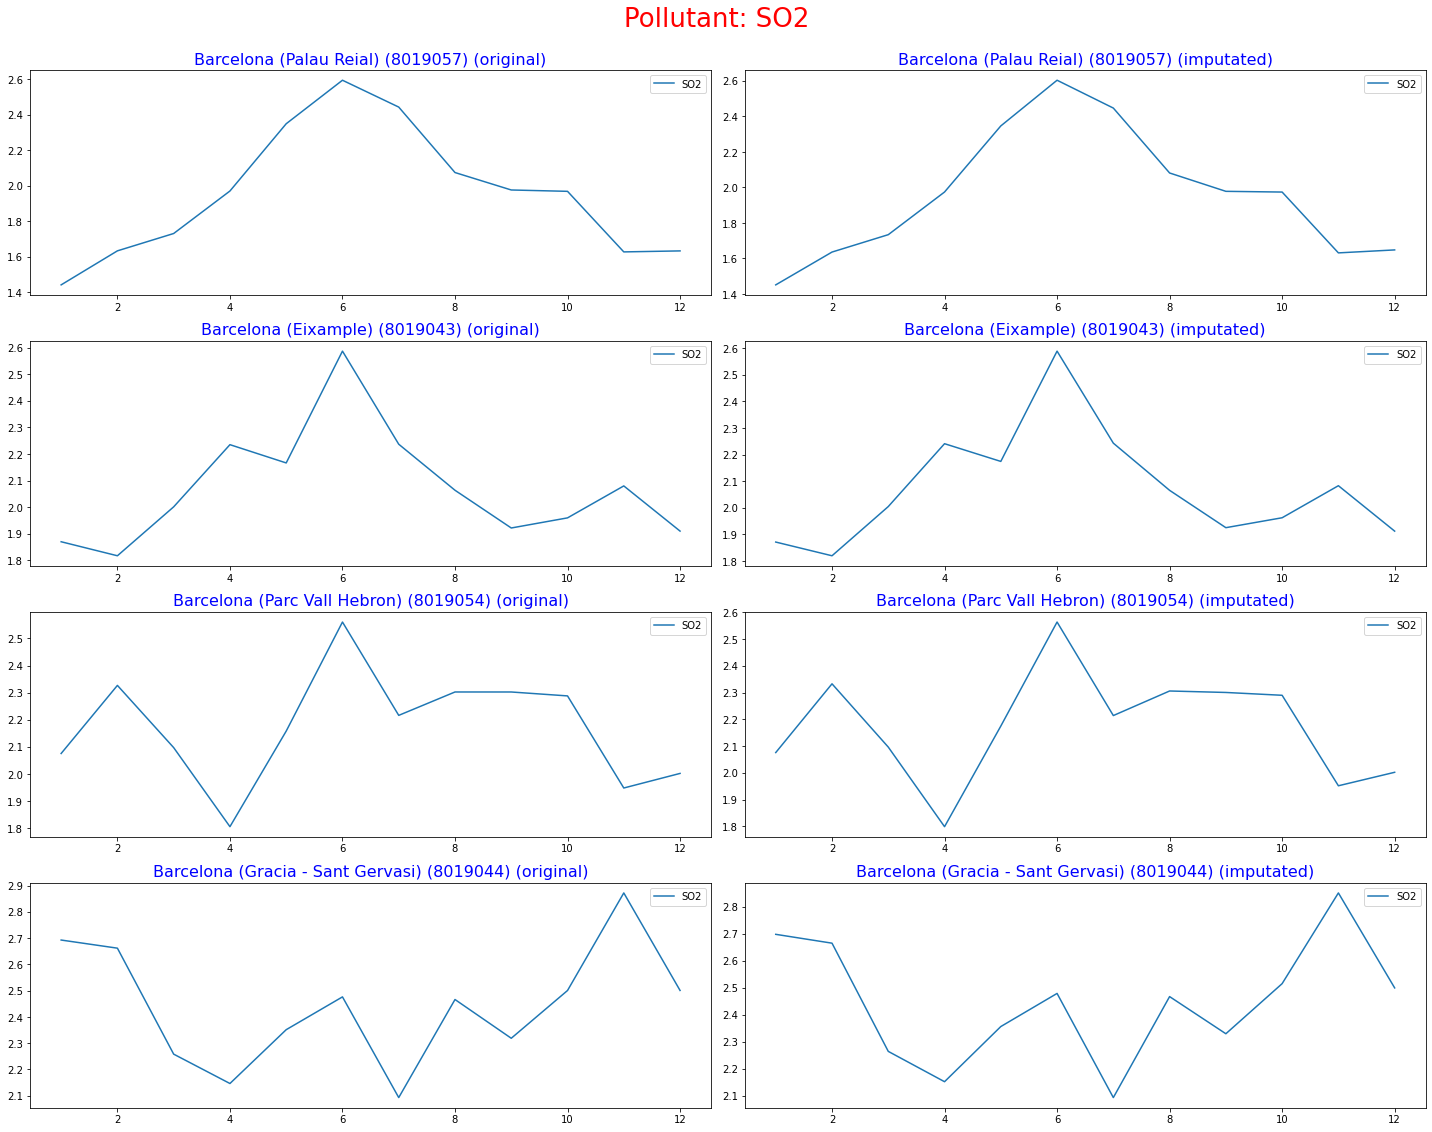

In [ ]:
data_in_1 = data_air_hourly_red
data_in_2 = data_imputated
idStations = data_in_1['CODI_EOI'].unique()
nroItems=len(idStations) * 2
ncols=2
nrows=int((nroItems / ncols) + (nroItems % ncols))

idStations=np.append(idStations, [None] * (nroItems % ncols))
variables=np.delete(data_imputated.columns, np.where(np.isin(data_imputated.columns, ['CODI_EOI', 'DATA'])))

for variable in variables:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*10,nrows*4))
    for idx in range(len(idStations)):
        idStation = idStations[idx]
        ax1 = axes[idx, 0]
        ax2 = axes[idx, 1]
        if idStation:            
            nom_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == idStation,'NOM_ESTACIO'].iloc[0]
            title='{} ({})'.format(nom_estacio, int(idStation))
            try:
                data1=data_in_1.loc[(data_in_1["CODI_EOI"] == idStation), ['DATA', variable]].set_index('DATA')
                #data1=data1.groupby(pd.Grouper(freq='M')).mean()
                data1=data1.groupby(data1.index.month).mean()
                if data1.count()[0] > 0:  
                    data1.plot(ax=ax1)     
                    ax1.set_title(title + ' (original)', fontsize=16, color='blue')
                    ax1.set_xlabel('')
            except:
                ax1.remove()
            try:
                data2=data_in_2.loc[(data_in_2["CODI_EOI"] == idStation), ['DATA', variable]].set_index('DATA')
                #data2=data2.groupby(pd.Grouper(freq='M')).mean()   
                data2=data2.groupby(data2.index.month).mean() 
                if data2.count()[0] > 0:  
                    data2.plot(ax=ax2)     
                    ax2.set_title(title + ' (imputated)', fontsize=16, color='blue')
                    ax2.set_xlabel('')
            except:
                ax2.remove()
        else:
            ax1.remove()
            ax2.remove()
        
    plt.suptitle('Pollutant: {}'.format(variable), fontsize=26, color='red')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

En este caso no se observa un patrón fijo según los meses de los años.

Finalmente, guardamos estos datos imputados en un fichero para poder utilizarlos posteriormente.

In [ ]:
data_imputated.to_csv(os.path.join(rootDataFolder, 'data_air_hourly_imp.csv'), index = False)

# Bibliografía

- Numpy developer manual. https://numpy.org/devdocs/

- Pandas documentation. https://pandas.pydata.org/docs/

- Folium. https://python-visualization.github.io/folium/

- [Óxidos de nitrógeno](http://www.crana.org/es/contaminacion/mas-informacion_3/axidos-nitrageno-nox-no2)